In [ ]:
!pip install wandb

wandb.login()

In [2]:
import wandb
wandb.login()

wandb: Currently logged in as: zolotarev (use `wandb login --relogin` to force relogin)


True

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor as cb_reg
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
names = pd.read_csv('dataset.csv')
names = names.drop(names.loc[names.TICKER.isin(['MVID', 'RNFT', 'SFIN', 'LNTA', 'UPRO', 'LSRG'])].index).reset_index(drop=True)
names.TICKER.unique()

array(['AFKS', 'AFLT', 'ALRS', 'CBOM', 'CHMF', 'DSKY', 'ENPG', 'FEES',
       'FIVE', 'FIXP', 'GAZP', 'GLTR', 'GMKN', 'HHRU', 'HYDR', 'IRAO',
       'LKOH', 'MAGN', 'MGNT', 'MOEX', 'MTSS', 'NLMK', 'NVTK', 'OZON',
       'PHOR', 'PIKK', 'PLZL', 'POGR', 'POLY', 'ROSN', 'RTKM', 'RUAL',
       'SBER', 'SBERP', 'SNGS', 'SNGSP', 'TATN', 'TATNP', 'TCSG', 'TRNFP',
       'VKCO', 'VTBR', 'YNDX'], dtype=object)

# Featured dataset split

In [4]:
data = pd.read_csv('dataset_features.csv')
data

,RV_EST_MEAN_AFKS_TARGET,RV_EST_MEAN_AFLT_TARGET,RV_EST_MEAN_ALRS_TARGET,RV_EST_MEAN_CBOM_TARGET,RV_EST_MEAN_CHMF_TARGET,RV_EST_MEAN_DSKY_TARGET,RV_EST_MEAN_ENPG_TARGET,RV_EST_MEAN_FEES_TARGET,RV_EST_MEAN_FIVE_TARGET,RV_EST_MEAN_FIXP_TARGET,...,RV_EST_STD_TATNP,RV_EST_STD_TCSG,RV_EST_STD_TRNFP,RV_EST_STD_VKCO,RV_EST_STD_VTBR,RV_EST_STD_YNDX,YEAR,MONTH,DAY,day_period
0,0.000015,0.000020,NaN,NaN,0.000042,NaN,NaN,0.000023,NaN,NaN,...,0.000004,NaN,0.000040,NaN,9.500616e-07,NaN,2010,2,1,0
1,0.000016,0.000019,NaN,NaN,0.000065,NaN,NaN,0.000037,NaN,NaN,...,0.000012,NaN,0.000008,NaN,2.145903e-05,NaN,2010,2,1,1
2,0.000056,0.000091,NaN,NaN,0.000047,NaN,NaN,0.000053,NaN,NaN,...,0.000002,NaN,0.000007,NaN,1.934337e-05,NaN,2010,2,1,2
3,0.000051,0.000067,NaN,NaN,0.000024,NaN,NaN,0.000026,NaN,NaN,...,0.000061,NaN,0.000032,NaN,2.613301e-06,NaN,2010,2,2,0
4,0.000032,0.000008,NaN,NaN,0.000110,NaN,NaN,0.000027,NaN,NaN,...,0.000028,NaN,0.000021,NaN,1.511274e-05,NaN,2010,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9151,0.000080,0.000010,0.000036,0.000004,0.000013,1.616739e-05,0.000035,0.000013,0.000045,0.000036,...,0.000031,0.000047,0.000004,0.000055,1.985965e-05,0.000009,2022,1,31,1
9152,0.000141,0.000035,0.000102,0.000055,0.000035,3.015687e-05,0.000067,0.000041,0.000077,0.000139,...,0.000012,0.000022,0.000016,0.000067,1.034818e-05,0.000051,2022,1,31,2
9153,0.000018,0.000019,0.000032,0.000008,0.000018,4.254454e-05,0.000022,0.000034,0.000033,0.000081,...,0.000017,0.000052,0.000015,0.000291,7.759391e-05,0.000590,2022,2,1,0
9154,0.000044,0.000025,0.000019,0.000007,0.000015,8.518451e-06,0.000030,0.000012,0.000044,0.000091,...,0.000020,0.000017,0.000017,0.000033,1.585212e-05,0.000038,2022,2,1,1


In [5]:
np.random.seed(2022)
train_ids = np.random.choice(data.TIMESTAMP.unique(), int(data.TIMESTAMP.nunique()*0.8), replace=False)
train = data.loc[data['TIMESTAMP'].isin(train_ids)]
test = data.loc[~data['TIMESTAMP'].isin(train_ids)]
test_ids = np.random.choice(test.TIMESTAMP.unique(), int(test.TIMESTAMP.nunique()*0.5), replace=False)
val = test.loc[test['TIMESTAMP'].isin(test_ids)]
test = test.loc[~test['TIMESTAMP'].isin(test_ids)]
test.TIMESTAMP

0       201002010
30      201002150
44      201002192
48      201002250
84      201003150
          ...    
9026    202112032
9065    202112212
9067    202112221
9129    202201202
9138    202201251
Name: TIMESTAMP, Length: 916, dtype: int64

In [6]:
def plot_hists(X1, X2, X3, names, label1, label2, label3):
    fig, axs = plt.subplots(len(names)//2, 2, figsize=(20, 12))
    for i, column in enumerate(names):
        bins = np.max([X1[column].nunique(), X2[column].nunique(), X2[column].nunique()])
        if bins<50:
            axs[i//2, i%2].hist(X1[column], bins=bins, alpha=0.3, label=label1, color='C0', density=True)
            axs[i//2, i%2].hist(X2[column], bins=bins, alpha=0.3, label=label2, color='C1', density=True)
            axs[i//2, i%2].hist(X3[column], bins=bins, alpha=0.3, label=label3, color='C2', density=True)
        else:
            axs[i//2, i%2].hist(X1[column], bins=20, alpha=0.3, label=label1, color='C0', density=True)
            axs[i//2, i%2].hist(X2[column], bins=20, alpha=0.3, label=label2, color='C1', density=True)
            axs[i//2, i%2].hist(X3[column], bins=20, alpha=0.3, label=label3, color='C2', density=True)
        axs[i//2, i%2].set_title(column)
        axs[i//2, i%2].legend(loc='best')
    plt.tight_layout()

In [ ]:
names = ['YEAR', 'MONTH', 'DAY', 'day_period']

In [ ]:
plot_hists(train, val, test, names, label1="train", label2="val", label3='test')

In [ ]:
train.loc[:, ~train.columns.str.endswith('_TARGET')]

In [7]:
X_train = train.loc[:, ~train.columns.str.endswith('_TARGET')]
y_train = train.loc[:, train.columns.str.endswith('_TARGET')]

X_val = val.loc[:, ~val.columns.str.endswith('_TARGET')]
y_val = val.loc[:, val.columns.str.endswith('_TARGET')]

X_test = test.loc[:, ~test.columns.str.endswith('_TARGET')]
y_test = test.loc[:, test.columns.str.endswith('_TARGET')]

# Modelling

In [2]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
def calc_metrics(y_true, y_pred):
    print('R2 для каждого столбца =', np.round(r2_score(y_true, y_pred, multioutput='uniform_average'), decimals=3))
    print('MAPE для каждого столбца =', np.round(np.sqrt(mean_absolute_percentage_error(y_true, y_pred, multioutput='uniform_average')), decimals=3).astype(np.float16))
    print('MSE для каждого столбца =', np.round(np.sqrt(mean_squared_error(y_true, y_pred, multioutput='uniform_average')), decimals=3).astype(np.float16))
    print('R2 для каждого столбца =', np.round(r2_score(y_true, y_pred, multioutput='raw_values'), decimals=3))
    print('MAPE для каждого столбца =', np.round(np.sqrt(mean_absolute_percentage_error(y_true, y_pred, multioutput='raw_values')), decimals=3).astype(np.float16))
    print('MSE для каждого столбца =', np.round(np.sqrt(mean_squared_error(y_true, y_pred, multioutput='raw_values')), decimals=3).astype(np.float16))

In [3]:
from sklearn.multioutput import MultiOutputRegressor

In [4]:
import wandb
wandb.init(project="diploma")

wandb: Currently logged in as: zolotarev (use `wandb login --relogin` to force relogin)


## xgboost

In [83]:
X_train.fillna(0, inplace=True)
y_train.fillna(0, inplace=True)

X_val.fillna(0, inplace=True)
y_val.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
y_test.fillna(0, inplace=True)

In [90]:
sweep_config = {
    "method": "random", # try grid or random
    "metric": {
       "name": "rmse",
       "name": "mape",
       "name": "r2"
    },
    "parameters": {
        "booster": {
            "values": ["gbtree"]
        },
        "max_depth": {
            "values": [4, 5, 6, 7, 8]
        },
        "learning_rate": {
            "values": [0.05, 0.1, 0.2, 0.3]
        },
        "subsample": {
            "values": [1]
        },
        "n_estimators":{
            "values": [200, 400, 800],
        },
        "colsample_bytree":{
            "values": [0.005]
        },
        "colsample_bylevel":{
            "values": [0.5, 1]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="diploma")

Create sweep with ID: wtf6pmv9
Sweep URL: https://wandb.ai/zolotarev/diploma/sweeps/wtf6pmv9


In [88]:
def train():
    config_defaults = {
    "booster": "gbtree",
    "max_depth": 3,
    "learning_rate": 0.1,
    "n_estimators": 10,
    "colsample_bytree": 0.01,
    "colsample_bylevel": 1,
    "subsample": 0.5
    }

    wandb.init(config=config_defaults)  # defaults are over-ridden during the sweep
    config = wandb.config

    # fit model on train
    model = MultiOutputRegressor(xgb.XGBRegressor(booster=config.booster, max_depth=config.max_depth,
                        learning_rate=config.learning_rate, n_estimators=config.n_estimators,
                        colsample_bytree=config.colsample_bytree, colsample_bylevel=config.colsample_bylevel,
                        subsample=config.subsample, seed=123, gpu_id=0, tree_method='gpu_hist'))
    model.fit(X_train, y_train)

    # make predictions on test
    y_pred = model.predict(X_val)
    
    # evaluate predictions
    val_rmse = np.sqrt(mean_squared_error(y_val, y_pred, multioutput='uniform_average'))
    val_mape = mean_absolute_percentage_error(y_val, y_pred, multioutput='uniform_average')
    val_r2 = r2_score(y_val, y_pred, multioutput='uniform_average')
    val_metrics = {"rmse": val_rmse, "mape": val_mape, "r2": val_r2}
    print(val_metrics)
    wandb.log({"rmse": val_metrics["rmse"]})
    wandb.log({"mape": val_metrics["mape"]})
    wandb.log({"r2": val_metrics["r2"]})    

In [91]:
wandb.agent(sweep_id, train, count=20)

wandb: Agent Starting Run: wh3cdgta with config:
wandb: 	booster: gbtree
wandb: 	colsample_bylevel: 0.5
wandb: 	colsample_bytree: 0.005
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 8
wandb: 	n_estimators: 400
wandb: 	subsample: 1


{'rmse': 0.00021680131818655198, 'mape': 7840609365.423089, 'r2': -0.16141186704896376}



mape,▁
r2,▁
rmse,▁
mape,7840609365.42309
r2,-0.16141
rmse,0.00022


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xjl6bm1n with config:
wandb: 	booster: gbtree
wandb: 	colsample_bylevel: 0.5
wandb: 	colsample_bytree: 0.005
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	n_estimators: 400
wandb: 	subsample: 1


{'rmse': 0.00021289202486425224, 'mape': 7825753711.557766, 'r2': 0.1655791592580296}



mape,▁
r2,▁
rmse,▁
mape,7825753711.55777
r2,0.16558
rmse,0.00021


wandb: Agent Starting Run: lkhe8a4v with config:
wandb: 	booster: gbtree
wandb: 	colsample_bylevel: 0.5
wandb: 	colsample_bytree: 0.005
wandb: 	learning_rate: 0.3
wandb: 	max_depth: 4
wandb: 	n_estimators: 400
wandb: 	subsample: 1


{'rmse': 0.00022641319670679903, 'mape': 5560775529.923222, 'r2': -0.9405901474213814}



mape,▁
r2,▁
rmse,▁
mape,5560775529.92322
r2,-0.94059
rmse,0.00023


wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
sweep_config = {
    "method": "random", # try grid or random
    "metric": {
       "name": "rmse",
       "name": "mape",
       "name": "r2"
    },
    "parameters": {
        "booster": {
            "values": ["gbtree"]
        },
        "max_depth": {
            "values": [2, 4, 5, 6, 7]
        },
        "learning_rate": {
            "values": [0.075, 0.1, 0.125, 0.15, 0.3]
        },
        "subsample": {
            "values": [1, 0.5, 0.3]
        },
        "n_estimators":{
            "values": [20, 50, 100, 200],
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="diploma")

In [ ]:
wandb.agent(sweep_id, train, count=100)

In [ ]:
config = {
    "booster": "gbtree",
    "max_depth": 2,
    "learning_rate": 0.125,
    "subsample": 1,
    "seed": 123,
    "test_size": 0.33,
    "n_estimators": 100,
    }

# fit model on train
model = MultiOutputRegressor(xgb.XGBRegressor(booster=config['booster'], max_depth=config['max_depth'],
                    learning_rate=config['learning_rate'], subsample=config['subsample'], n_estimators=config['n_estimators'], seed=123,
                                             gpu_id=0, tree_method='gpu_hist'))
model.fit(X_train, y_train)

# make predictions on test
y_pred = model.predict(X_val)

# evaluate predictions
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred, multioutput='uniform_average'))
val_mape = mean_absolute_percentage_error(y_val, y_pred, multioutput='uniform_average')
val_r2 = r2_score(y_val, y_pred, multioutput='uniform_average')
val_metrics = {"rmse": val_rmse, "mape": val_mape, "r2": val_r2}
print(val_metrics)

In [ ]:
coefs = model.estimators_[0].feature_importances_ * X_train.mean().to_numpy() / y_train.iloc[:, 0].mean()
for i in range(len(model.estimators_)-1):
    coefs = np.vstack([coefs, 
                       model.estimators_[i+1].feature_importances_ * X_train.mean().to_numpy() / \
                                                   y_train.iloc[:, i+1].mean()])

indexes = np.argpartition(np.abs(coefs[0, ]), -15)[-15:]
for i in range(len(model.estimators_)-1):
    indexes = np.vstack([indexes, np.argpartition(np.abs(coefs[i+1, ]), -15)[-15:]])
indexes

In [ ]:
model.estimators_[0].feature_importances_[np.argpartition(model.estimators_[0].feature_importances_, -15)[-15:]]

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(X_val.columns[indexes[0]], model.estimators_[0].feature_importances_[np.argpartition(model.estimators_[0].feature_importances_, -15)[-15:]])
plt.xticks(X_val.columns[indexes[0]], X_val.columns[indexes[0]], rotation=45, horizontalalignment='right')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(X_val.columns, model.feature_importances_)
plt.xticks(X_val.columns, X_val.columns, rotation=45, horizontalalignment='right')
plt.show()

# catboost

In [13]:
from catboost import Pool
train_pool = Pool(X_train, label=y_train)
val_pool = Pool(X_val, label=y_val)
test_pool = Pool(X_test, label=y_test)

In [ ]:
cb = cb_reg(depth=3, l2_leaf_reg=7, 
                        iterations=200, learning_rate=0.1,
                        random_state=21,
                       loss_function='MultiRMSE', eval_metric='MultiRMSE')
cb.fit(train_pool, plot=True, 
           eval_set=val_pool, verbose=True, metric_period=20)
y_pred = cb.predict(X_val)
calc_metrics(y_val, y_pred)

In [10]:
sweep_config = {
    "method": "random", # try grid or random
    "metric": {
       "name": "rmse",
       "name": "mape",
       "name": "r2"
    },
    "parameters": {
        "max_depth": {
            "values": [2, 3, 4, 6, 8]
        },
        "learning_rate": {
            "values": [0.01, 0.05, 0.1, 0.2, 0.3]
        },
        "iterations":{
            "values": [20, 40, 70, 100, 200],
        },
        "l2_leaf_reg": {
            "values": [1, 3, 5, 7]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="diploma")

Create sweep with ID: 7yc3kmas
Sweep URL: https://wandb.ai/zolotarev/diploma/sweeps/7yc3kmas


In [11]:
def train():
    config_defaults = {
    "max_depth": 3,
    "learning_rate": 0.1,
    "seed": 123,
    "test_size": 0.33,
    }

    wandb.init(config=config_defaults)  # defaults are over-ridden during the sweep
    config = wandb.config

    # fit model on train
    model = cb_reg(iterations=config.iterations, max_depth=config.max_depth,
                        learning_rate=config.learning_rate, l2_leaf_reg=config.l2_leaf_reg, random_state=123,
                        loss_function='MultiRMSE', eval_metric='MultiRMSE')
    model.fit(train_pool, plot=False, 
           eval_set=val_pool, verbose=True, metric_period=20, early_stopping_rounds=20)

    # make predictions on test
    y_pred = model.predict(X_val)
    
    # evaluate predictions
    val_rmse = np.sqrt(mean_squared_error(y_val, y_pred, multioutput='uniform_average'))
    val_mape = mean_absolute_percentage_error(y_val, y_pred, multioutput='uniform_average')
    val_r2 = r2_score(y_val, y_pred, multioutput='uniform_average')
    val_metrics = {"rmse": val_rmse, "mape": val_mape, "r2": val_r2}
    print(val_metrics)
    wandb.log({"rmse": val_metrics["rmse"]})
    wandb.log({"mape": val_metrics["mape"]})
    wandb.log({"r2": val_metrics["r2"]})    

In [ ]:
wandb.agent(sweep_id, train, count=100)

wandb: Agent Starting Run: ojh1vt1c with config:
wandb: 	iterations: 20
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 3


0:	learn: 0.0018446	test: 0.0018371	best: 0.0018371 (0)	total: 896ms	remaining: 17s
19:	learn: 0.0017165	test: 0.0018310	best: 0.0018307 (17)	total: 14.7s	remaining: 0us

bestTest = 0.001830741462
bestIteration = 17

Shrink model to first 18 iterations.
{'rmse': 0.0002791854544831916, 'mape': 15146509273.662596, 'r2': 0.03442169994267351}



mape,▁
r2,▁
rmse,▁
mape,15146509273.6626
r2,0.03442
rmse,0.00028


wandb: Agent Starting Run: x443gtlu with config:
wandb: 	iterations: 20
wandb: 	l2_leaf_reg: 7
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 3


0:	learn: 0.0018591	test: 0.0018376	best: 0.0018376 (0)	total: 878ms	remaining: 16.7s
19:	learn: 0.0018528	test: 0.0018367	best: 0.0018367 (19)	total: 15.8s	remaining: 0us

bestTest = 0.001836702756
bestIteration = 19

{'rmse': 0.0002800945434070031, 'mape': 19907094454.444958, 'r2': 0.0015129945476059644}



mape,▁
r2,▁
rmse,▁
mape,19907094454.44496
r2,0.00151
rmse,0.00028


wandb: Agent Starting Run: bmmt3wsy with config:
wandb: 	iterations: 70
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6


0:	learn: 0.0018589	test: 0.0018376	best: 0.0018376 (0)	total: 7.61s	remaining: 8m 45s
20:	learn: 0.0018434	test: 0.0018363	best: 0.0018363 (20)	total: 2m 44s	remaining: 6m 24s
40:	learn: 0.0018316	test: 0.0018353	best: 0.0018353 (40)	total: 5m 9s	remaining: 3m 38s
60:	learn: 0.0018196	test: 0.0018342	best: 0.0018342 (60)	total: 7m 44s	remaining: 1m 8s
69:	learn: 0.0018145	test: 0.0018337	best: 0.0018337 (69)	total: 8m 55s	remaining: 0us

bestTest = 0.001833690836
bestIteration = 69

{'rmse': 0.0002796352298910902, 'mape': 18500937794.839687, 'r2': 0.03346101532646478}



mape,▁
r2,▁
rmse,▁
mape,18500937794.83969
r2,0.03346
rmse,0.00028


wandb: Agent Starting Run: 1xvdxng6 with config:
wandb: 	iterations: 40
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 2


0:	learn: 0.0018590	test: 0.0018376	best: 0.0018376 (0)	total: 482ms	remaining: 18.8s
20:	learn: 0.0018527	test: 0.0018369	best: 0.0018369 (20)	total: 8.75s	remaining: 7.92s
39:	learn: 0.0018466	test: 0.0018363	best: 0.0018363 (37)	total: 16.4s	remaining: 0us

bestTest = 0.00183631673
bestIteration = 37

Shrink model to first 38 iterations.
{'rmse': 0.00028003567491751406, 'mape': 19941490924.025066, 'r2': 0.0065649190909797045}



mape,▁
r2,▁
rmse,▁
mape,19941490924.02507
r2,0.00656
rmse,0.00028


wandb: Agent Starting Run: ge93lyse with config:
wandb: 	iterations: 40
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.3
wandb: 	max_depth: 3


0:	learn: 0.0018447	test: 0.0018372	best: 0.0018372 (0)	total: 775ms	remaining: 30.2s
20:	learn: 0.0016985	test: 0.0018277	best: 0.0018275 (17)	total: 13.9s	remaining: 12.6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001827526277
bestIteration = 17

Shrink model to first 18 iterations.
{'rmse': 0.00027869514341248125, 'mape': 14573007430.70376, 'r2': 0.08123878426915283}



mape,▁
r2,▁
rmse,▁
mape,14573007430.70376
r2,0.08124
rmse,0.00028


wandb: Agent Starting Run: txg0syq1 with config:
wandb: 	iterations: 100
wandb: 	l2_leaf_reg: 7
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 8


0:	learn: 0.0018572	test: 0.0018374	best: 0.0018374 (0)	total: 25.7s	remaining: 42m 22s
20:	learn: 0.0017923	test: 0.0018326	best: 0.0018326 (20)	total: 8m 43s	remaining: 32m 48s
40:	learn: 0.0017342	test: 0.0018295	best: 0.0018295 (40)	total: 17m	remaining: 24m 27s
60:	learn: 0.0016884	test: 0.0018273	best: 0.0018273 (60)	total: 25m 12s	remaining: 16m 6s
80:	learn: 0.0016465	test: 0.0018243	best: 0.0018243 (80)	total: 33m 20s	remaining: 7m 49s
99:	learn: 0.0016107	test: 0.0018232	best: 0.0018232 (99)	total: 41m 5s	remaining: 0us

bestTest = 0.001823244965
bestIteration = 99

{'rmse': 0.00027804224939161217, 'mape': 12446734518.413284, 'r2': 0.1277778808237711}



mape,▁
r2,▁
rmse,▁
mape,12446734518.41328
r2,0.12778
rmse,0.00028


wandb: Agent Starting Run: 0lp3a40d with config:
wandb: 	iterations: 20
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 3


0:	learn: 0.0018570	test: 0.0018376	best: 0.0018376 (0)	total: 722ms	remaining: 13.7s
19:	learn: 0.0018255	test: 0.0018340	best: 0.0018340 (19)	total: 12.8s	remaining: 0us

bestTest = 0.001833985442
bestIteration = 19

{'rmse': 0.0002796801568097136, 'mape': 19016674164.78634, 'r2': 0.029783476254854262}



mape,▁
r2,▁
rmse,▁
mape,19016674164.78634
r2,0.02978
rmse,0.00028


wandb: Agent Starting Run: fhs27iqw with config:
wandb: 	iterations: 70
wandb: 	l2_leaf_reg: 1
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 8


0:	learn: 0.0018485	test: 0.0018369	best: 0.0018369 (0)	total: 23.9s	remaining: 27m 32s
20:	learn: 0.0016425	test: 0.0018298	best: 0.0018298 (20)	total: 8m 30s	remaining: 19m 50s
40:	learn: 0.0015066	test: 0.0018252	best: 0.0018252 (40)	total: 16m 37s	remaining: 11m 45s
60:	learn: 0.0014049	test: 0.0018232	best: 0.0018232 (60)	total: 24m 45s	remaining: 3m 39s
69:	learn: 0.0013675	test: 0.0018226	best: 0.0018223 (64)	total: 28m 26s	remaining: 0us

bestTest = 0.001822328702
bestIteration = 64

Shrink model to first 65 iterations.
{'rmse': 0.0002779025206677978, 'mape': 12128658728.489424, 'r2': 0.1284756618870611}



mape,▁
r2,▁
rmse,▁
mape,12128658728.48942
r2,0.12848
rmse,0.00028


wandb: Agent Starting Run: n88wuu1n with config:
wandb: 	iterations: 20
wandb: 	l2_leaf_reg: 1
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6


0:	learn: 0.0018444	test: 0.0018371	best: 0.0018371 (0)	total: 6.54s	remaining: 2m 4s
19:	learn: 0.0016000	test: 0.0018288	best: 0.0018288 (19)	total: 2m 12s	remaining: 0us

bestTest = 0.001828774097
bestIteration = 19

{'rmse': 0.00027888543414157424, 'mape': 14864942428.173225, 'r2': 0.09268377776837777}



mape,▁
r2,▁
rmse,▁
mape,14864942428.17323
r2,0.09268
rmse,0.00028


wandb: Agent Starting Run: 7kbb8dr6 with config:
wandb: 	iterations: 70
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6


0:	learn: 0.0018540	test: 0.0018371	best: 0.0018371 (0)	total: 6.59s	remaining: 7m 34s
20:	learn: 0.0017202	test: 0.0018300	best: 0.0018300 (20)	total: 2m 19s	remaining: 5m 25s
40:	learn: 0.0016369	test: 0.0018260	best: 0.0018259 (39)	total: 4m 32s	remaining: 3m 12s
60:	learn: 0.0015691	test: 0.0018233	best: 0.0018233 (60)	total: 6m 45s	remaining: 59.8s
69:	learn: 0.0015374	test: 0.0018228	best: 0.0018228 (67)	total: 7m 45s	remaining: 0us

bestTest = 0.00182276186
bestIteration = 67

Shrink model to first 68 iterations.
{'rmse': 0.00027796857667245373, 'mape': 12017637202.78474, 'r2': 0.142107277765372}



mape,▁
r2,▁
rmse,▁
mape,12017637202.78474
r2,0.14211
rmse,0.00028


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mr8htcy8 with config:
wandb: 	iterations: 20
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4


0:	learn: 0.0018569	test: 0.0018375	best: 0.0018375 (0)	total: 1.95s	remaining: 37.1s
19:	learn: 0.0018120	test: 0.0018332	best: 0.0018332 (19)	total: 39.1s	remaining: 0us

bestTest = 0.001833239558
bestIteration = 19

{'rmse': 0.00027956641058218254, 'mape': 18980804827.823727, 'r2': 0.038697179994852324}



mape,▁
r2,▁
rmse,▁
mape,18980804827.82373
r2,0.0387
rmse,0.00028


wandb: Agent Starting Run: ggg2cprv with config:
wandb: 	iterations: 100
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 3


0:	learn: 0.0018446	test: 0.0018371	best: 0.0018371 (0)	total: 708ms	remaining: 1m 10s
20:	learn: 0.0017108	test: 0.0018309	best: 0.0018307 (17)	total: 13.4s	remaining: 50.6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001830741462
bestIteration = 17

Shrink model to first 18 iterations.
{'rmse': 0.0002791854544831916, 'mape': 15146509273.662596, 'r2': 0.03442169994267351}



mape,▁
r2,▁
rmse,▁
mape,15146509273.6626
r2,0.03442
rmse,0.00028


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 608ovsmu with config:
wandb: 	iterations: 70
wandb: 	l2_leaf_reg: 7
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6


0:	learn: 0.0018574	test: 0.0018375	best: 0.0018375 (0)	total: 6.59s	remaining: 7m 34s
20:	learn: 0.0018032	test: 0.0018331	best: 0.0018331 (20)	total: 2m 18s	remaining: 5m 23s
40:	learn: 0.0017638	test: 0.0018308	best: 0.0018308 (40)	total: 4m 31s	remaining: 3m 12s
60:	learn: 0.0017275	test: 0.0018277	best: 0.0018276 (59)	total: 6m 44s	remaining: 59.7s
69:	learn: 0.0017125	test: 0.0018271	best: 0.0018271 (68)	total: 7m 44s	remaining: 0us

bestTest = 0.001827066501
bestIteration = 68

Shrink model to first 69 iterations.
{'rmse': 0.0002786250281592437, 'mape': 14987208210.23952, 'r2': 0.0939473544173599}



mape,▁
r2,▁
rmse,▁
mape,14987208210.23952
r2,0.09395
rmse,0.00028


wandb: Agent Starting Run: kvtd35p3 with config:
wandb: 	iterations: 100
wandb: 	l2_leaf_reg: 7
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 8


0:	learn: 0.0018550	test: 0.0018372	best: 0.0018372 (0)	total: 24.2s	remaining: 40m
20:	learn: 0.0017345	test: 0.0018296	best: 0.0018296 (20)	total: 8m 33s	remaining: 32m 11s
40:	learn: 0.0016391	test: 0.0018256	best: 0.0018256 (40)	total: 16m 43s	remaining: 24m 3s
60:	learn: 0.0015675	test: 0.0018244	best: 0.0018244 (59)	total: 24m 53s	remaining: 15m 54s
80:	learn: 0.0015085	test: 0.0018229	best: 0.0018229 (80)	total: 33m 4s	remaining: 7m 45s
99:	learn: 0.0014524	test: 0.0018222	best: 0.0018222 (99)	total: 40m 49s	remaining: 0us

bestTest = 0.00182215119
bestIteration = 99

{'rmse': 0.0002778754503093715, 'mape': 11911256226.971148, 'r2': 0.13614323149517935}



mape,▁
r2,▁
rmse,▁
mape,11911256226.97115
r2,0.13614
rmse,0.00028


wandb: Agent Starting Run: wpaoyyje with config:
wandb: 	iterations: 70
wandb: 	l2_leaf_reg: 7
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 3


0:	learn: 0.0018576	test: 0.0018376	best: 0.0018376 (0)	total: 730ms	remaining: 50.4s
20:	learn: 0.0018291	test: 0.0018340	best: 0.0018340 (20)	total: 13.5s	remaining: 31.5s
40:	learn: 0.0018031	test: 0.0018321	best: 0.0018321 (39)	total: 26.2s	remaining: 18.5s
60:	learn: 0.0017816	test: 0.0018306	best: 0.0018306 (60)	total: 39.1s	remaining: 5.77s
69:	learn: 0.0017733	test: 0.0018296	best: 0.0018296 (69)	total: 45s	remaining: 0us

bestTest = 0.001829551871
bestIteration = 69

{'rmse': 0.00027900404363046265, 'mape': 17345837138.56587, 'r2': 0.07090379639781196}



mape,▁
r2,▁
rmse,▁
mape,17345837138.56587
r2,0.0709
rmse,0.00028


wandb: Agent Starting Run: e09hpyzf with config:
wandb: 	iterations: 40
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 2


0:	learn: 0.0018587	test: 0.0018376	best: 0.0018376 (0)	total: 402ms	remaining: 15.7s
20:	learn: 0.0018508	test: 0.0018368	best: 0.0018368 (20)	total: 7.47s	remaining: 6.76s
39:	learn: 0.0018429	test: 0.0018361	best: 0.0018361 (37)	total: 14.2s	remaining: 0us

bestTest = 0.001836070977
bestIteration = 37

Shrink model to first 38 iterations.
{'rmse': 0.00027999819791017083, 'mape': 19951674496.736988, 'r2': 0.009335359736346064}



mape,▁
r2,▁
rmse,▁
mape,19951674496.73699
r2,0.00934
rmse,0.00028


wandb: Agent Starting Run: jkipeewh with config:
wandb: 	iterations: 70
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 8


0:	learn: 0.0018509	test: 0.0018367	best: 0.0018367 (0)	total: 24.4s	remaining: 28m 1s
20:	learn: 0.0016422	test: 0.0018283	best: 0.0018283 (20)	total: 8m 35s	remaining: 20m 2s
40:	learn: 0.0015022	test: 0.0018237	best: 0.0018237 (40)	total: 16m 45s	remaining: 11m 50s
60:	learn: 0.0013914	test: 0.0018243	best: 0.0018237 (40)	total: 24m 56s	remaining: 3m 40s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001823722521
bestIteration = 40

Shrink model to first 41 iterations.
{'rmse': 0.0002781150760183992, 'mape': 11843485695.162584, 'r2': 0.10433710020605433}



mape,▁
r2,▁
rmse,▁
mape,11843485695.16258
r2,0.10434
rmse,0.00028


wandb: Agent Starting Run: r5vjfxqt with config:
wandb: 	iterations: 20
wandb: 	l2_leaf_reg: 7
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 2


0:	learn: 0.0018576	test: 0.0018376	best: 0.0018376 (0)	total: 404ms	remaining: 7.67s
19:	learn: 0.0018350	test: 0.0018350	best: 0.0018350 (19)	total: 7.12s	remaining: 0us

bestTest = 0.001835030612
bestIteration = 19

{'rmse': 0.0002798395438364107, 'mape': 19282547108.55689, 'r2': 0.022267632379407116}



mape,▁
r2,▁
rmse,▁
mape,19282547108.55689
r2,0.02227
rmse,0.00028


wandb: Agent Starting Run: les08e00 with config:
wandb: 	iterations: 20
wandb: 	l2_leaf_reg: 1
wandb: 	learning_rate: 0.3
wandb: 	max_depth: 3


0:	learn: 0.0018177	test: 0.0018369	best: 0.0018369 (0)	total: 709ms	remaining: 13.5s
19:	learn: 0.0015693	test: 0.0018443	best: 0.0018323 (3)	total: 12.9s	remaining: 0us

bestTest = 0.001832294528
bestIteration = 3

Shrink model to first 4 iterations.
{'rmse': 0.0002794222949374771, 'mape': 16196893713.989351, 'r2': 0.04798196466373338}



mape,▁
r2,▁
rmse,▁
mape,16196893713.98935
r2,0.04798
rmse,0.00028


wandb: Agent Starting Run: gifzpeu4 with config:
wandb: 	iterations: 20
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 2


0:	learn: 0.0018590	test: 0.0018376	best: 0.0018376 (0)	total: 404ms	remaining: 7.67s
19:	learn: 0.0018531	test: 0.0018369	best: 0.0018369 (19)	total: 7.1s	remaining: 0us

bestTest = 0.001836875745
bestIteration = 19

{'rmse': 0.0002801209238497327, 'mape': 20000437652.151863, 'r2': 0.0008595087640256965}



mape,▁
r2,▁
rmse,▁
mape,20000437652.15186
r2,0.00086
rmse,0.00028


wandb: Agent Starting Run: eofrzzaj with config:
wandb: 	iterations: 20
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 8


0:	learn: 0.0018566	test: 0.0018373	best: 0.0018373 (0)	total: 24s	remaining: 7m 36s
19:	learn: 0.0017787	test: 0.0018327	best: 0.0018327 (19)	total: 8m 10s	remaining: 0us

bestTest = 0.001832651873
bestIteration = 19

{'rmse': 0.0002794767895029895, 'mape': 17052644986.376152, 'r2': 0.04432287403326974}



mape,▁
r2,▁
rmse,▁
mape,17052644986.37615
r2,0.04432
rmse,0.00028


wandb: Agent Starting Run: hgjcgy1c with config:
wandb: 	iterations: 70
wandb: 	l2_leaf_reg: 1
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 3


0:	learn: 0.0018449	test: 0.0018374	best: 0.0018374 (0)	total: 698ms	remaining: 48.2s
20:	learn: 0.0017288	test: 0.0018322	best: 0.0018322 (20)	total: 13.4s	remaining: 31.2s
40:	learn: 0.0016332	test: 0.0018335	best: 0.0018318 (27)	total: 26.3s	remaining: 18.6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001831824676
bestIteration = 27

Shrink model to first 28 iterations.
{'rmse': 0.000279350643054893, 'mape': 16513720621.744682, 'r2': 0.06851379750341757}



mape,▁
r2,▁
rmse,▁
mape,16513720621.74468
r2,0.06851
rmse,0.00028


wandb: Agent Starting Run: p0c6iru0 with config:
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 2


0:	learn: 0.0018521	test: 0.0018375	best: 0.0018375 (0)	total: 398ms	remaining: 1m 19s
20:	learn: 0.0017909	test: 0.0018332	best: 0.0018332 (19)	total: 7.45s	remaining: 1m 3s
40:	learn: 0.0017288	test: 0.0018319	best: 0.0018311 (37)	total: 14.3s	remaining: 55.5s
60:	learn: 0.0016857	test: 0.0018320	best: 0.0018310 (49)	total: 21.5s	remaining: 48.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001830968445
bestIteration = 49

Shrink model to first 50 iterations.
{'rmse': 0.00027922006917828105, 'mape': 16846341261.734835, 'r2': 0.06805011305874391}



mape,▁
r2,▁
rmse,▁
mape,16846341261.73483
r2,0.06805
rmse,0.00028


wandb: Agent Starting Run: oxyp4n7u with config:
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.3
wandb: 	max_depth: 4


0:	learn: 0.0018372	test: 0.0018366	best: 0.0018366 (0)	total: 1.96s	remaining: 6m 29s
20:	learn: 0.0016022	test: 0.0018347	best: 0.0018326 (14)	total: 41.7s	remaining: 5m 55s
40:	learn: 0.0014299	test: 0.0018360	best: 0.0018314 (23)	total: 1m 22s	remaining: 5m 18s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001831438317
bestIteration = 23

Shrink model to first 24 iterations.
{'rmse': 0.00027929172398263776, 'mape': 14450368298.898918, 'r2': 0.06858134236500589}



mape,▁
r2,▁
rmse,▁
mape,14450368298.89892
r2,0.06858
rmse,0.00028


wandb: Agent Starting Run: wzqbwicz with config:
wandb: 	iterations: 40
wandb: 	l2_leaf_reg: 7
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 6


0:	learn: 0.0018512	test: 0.0018372	best: 0.0018372 (0)	total: 6.63s	remaining: 4m 18s
20:	learn: 0.0016857	test: 0.0018292	best: 0.0018291 (19)	total: 2m 20s	remaining: 2m 6s
39:	learn: 0.0015729	test: 0.0018268	best: 0.0018268 (36)	total: 4m 27s	remaining: 0us

bestTest = 0.001826789051
bestIteration = 36

Shrink model to first 37 iterations.
{'rmse': 0.0002785827175181482, 'mape': 13348493908.896513, 'r2': 0.11257470864738628}



mape,▁
r2,▁
rmse,▁
mape,13348493908.89651
r2,0.11257
rmse,0.00028


wandb: Agent Starting Run: 9m6rbxwq with config:
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 1
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 2


0:	learn: 0.0018313	test: 0.0018374	best: 0.0018374 (0)	total: 401ms	remaining: 1m 19s
20:	learn: 0.0016689	test: 0.0018364	best: 0.0018344 (5)	total: 7.6s	remaining: 1m 4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001834438501
bestIteration = 5

Shrink model to first 6 iterations.
{'rmse': 0.00027974924765190835, 'mape': 19625750056.381477, 'r2': 0.02975594202980917}



mape,▁
r2,▁
rmse,▁
mape,19625750056.38148
r2,0.02976
rmse,0.00028


wandb: Agent Starting Run: fat34d25 with config:
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 6


0:	learn: 0.0018486	test: 0.0018367	best: 0.0018367 (0)	total: 6.57s	remaining: 21m 47s
20:	learn: 0.0016268	test: 0.0018281	best: 0.0018281 (20)	total: 2m 19s	remaining: 19m 47s
40:	learn: 0.0014978	test: 0.0018265	best: 0.0018265 (40)	total: 4m 32s	remaining: 17m 38s
60:	learn: 0.0013876	test: 0.0018265	best: 0.0018256 (49)	total: 6m 46s	remaining: 15m 26s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.0018255932
bestIteration = 49

Shrink model to first 50 iterations.
{'rmse': 0.00027840035186291645, 'mape': 11988450254.42567, 'r2': 0.11295134214259232}



mape,▁
r2,▁
rmse,▁
mape,11988450254.42567
r2,0.11295
rmse,0.00028


wandb: Agent Starting Run: 8ygujjqj with config:
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 7
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 6


0:	learn: 0.0018512	test: 0.0018372	best: 0.0018372 (0)	total: 6.62s	remaining: 21m 56s
20:	learn: 0.0016857	test: 0.0018292	best: 0.0018291 (19)	total: 2m 30s	remaining: 21m 21s
40:	learn: 0.0015663	test: 0.0018263	best: 0.0018263 (40)	total: 5m 1s	remaining: 19m 28s
60:	learn: 0.0014822	test: 0.0018267	best: 0.0018262 (44)	total: 7m 23s	remaining: 16m 49s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001826195153
bestIteration = 44

Shrink model to first 45 iterations.
{'rmse': 0.0002784921489559255, 'mape': 13089152805.728468, 'r2': 0.11564949212387367}



mape,▁
r2,▁
rmse,▁
mape,13089152805.72847
r2,0.11565
rmse,0.00028


wandb: Agent Starting Run: r7gmhz1q with config:
wandb: 	iterations: 100
wandb: 	l2_leaf_reg: 1
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 2


0:	learn: 0.0018580	test: 0.0018376	best: 0.0018376 (0)	total: 419ms	remaining: 41.5s
20:	learn: 0.0018464	test: 0.0018367	best: 0.0018367 (20)	total: 7.81s	remaining: 29.4s
40:	learn: 0.0018341	test: 0.0018359	best: 0.0018359 (40)	total: 15.9s	remaining: 22.9s
60:	learn: 0.0018242	test: 0.0018349	best: 0.0018349 (60)	total: 23.6s	remaining: 15.1s
80:	learn: 0.0018149	test: 0.0018344	best: 0.0018344 (80)	total: 31.2s	remaining: 7.33s
99:	learn: 0.0018055	test: 0.0018337	best: 0.0018337 (99)	total: 38.5s	remaining: 0us

bestTest = 0.001833730626
bestIteration = 99

{'rmse': 0.00027964129773440626, 'mape': 19427047210.270977, 'r2': 0.03200708537757986}



mape,▁
r2,▁
rmse,▁
mape,19427047210.27098
r2,0.03201
rmse,0.00028


wandb: Agent Starting Run: ubjzm76n with config:
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 7
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 4


0:	learn: 0.0018517	test: 0.0018374	best: 0.0018374 (0)	total: 2.05s	remaining: 6m 48s
20:	learn: 0.0017300	test: 0.0018317	best: 0.0018314 (15)	total: 43.4s	remaining: 6m 10s
40:	learn: 0.0016456	test: 0.0018302	best: 0.0018302 (40)	total: 1m 27s	remaining: 5m 39s
60:	learn: 0.0015639	test: 0.0018298	best: 0.0018298 (55)	total: 2m 12s	remaining: 5m 1s
80:	learn: 0.0015042	test: 0.0018299	best: 0.0018291 (74)	total: 2m 55s	remaining: 4m 18s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001829130055
bestIteration = 74

Shrink model to first 75 iterations.
{'rmse': 0.00027893971731399013, 'mape': 14350952755.65674, 'r2': 0.06681858085745807}



mape,▁
r2,▁
rmse,▁
mape,14350952755.65674
r2,0.06682
rmse,0.00028


wandb: Agent Starting Run: jep104b9 with config:
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 8


0:	learn: 0.0018551	test: 0.0018372	best: 0.0018372 (0)	total: 27s	remaining: 1h 29m 42s
20:	learn: 0.0017318	test: 0.0018309	best: 0.0018309 (20)	total: 9m 18s	remaining: 1h 19m 17s
40:	learn: 0.0016430	test: 0.0018262	best: 0.0018262 (40)	total: 18m 8s	remaining: 1h 10m 20s
60:	learn: 0.0015689	test: 0.0018245	best: 0.0018245 (60)	total: 26m 26s	remaining: 1h 14s
80:	learn: 0.0015060	test: 0.0018228	best: 0.0018228 (79)	total: 34m 43s	remaining: 51m
100:	learn: 0.0014471	test: 0.0018218	best: 0.0018218 (100)	total: 43m 24s	remaining: 42m 33s
120:	learn: 0.0013979	test: 0.0018211	best: 0.0018211 (120)	total: 53m 12s	remaining: 34m 44s
140:	learn: 0.0013469	test: 0.0018205	best: 0.0018205 (132)	total: 1h 2m 49s	remaining: 26m 17s
160:	learn: 0.0012992	test: 0.0018204	best: 0.0018203 (158)	total: 1h 11m 12s	remaining: 17m 15s
180:	learn: 0.0012551	test: 0.0018195	best: 0.0018195 (180)	total: 1h 21m	remaining: 8m 30s
199:	learn: 0.0012145	test: 0.0018194	best: 0.0018193 (185)	total: 1h 2

mape,▁
r2,▁
rmse,▁
mape,9973195856.76904
r2,0.15739
rmse,0.00028


wandb: Agent Starting Run: cuxggpu7 with config:
wandb: 	iterations: 70
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 2


0:	learn: 0.0018590	test: 0.0018376	best: 0.0018376 (0)	total: 421ms	remaining: 29s
20:	learn: 0.0018527	test: 0.0018369	best: 0.0018369 (20)	total: 7.42s	remaining: 17.3s
40:	learn: 0.0018461	test: 0.0018362	best: 0.0018362 (40)	total: 14.3s	remaining: 10.1s
60:	learn: 0.0018397	test: 0.0018353	best: 0.0018353 (60)	total: 21.5s	remaining: 3.18s
69:	learn: 0.0018376	test: 0.0018350	best: 0.0018350 (69)	total: 24.8s	remaining: 0us

bestTest = 0.001835030285
bestIteration = 69

{'rmse': 0.0002798394938461709, 'mape': 19583574466.307907, 'r2': 0.018605786087353984}



mape,▁
r2,▁
rmse,▁
mape,19583574466.30791
r2,0.01861
rmse,0.00028


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g0fdtg1z with config:
wandb: 	iterations: 20
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 8


0:	learn: 0.0018586	test: 0.0018375	best: 0.0018375 (0)	total: 24.3s	remaining: 7m 41s
19:	learn: 0.0018334	test: 0.0018360	best: 0.0018360 (19)	total: 8m 29s	remaining: 0us

bestTest = 0.001835971541
bestIteration = 19

{'rmse': 0.00027998303408973514, 'mape': 19452296213.707157, 'r2': 0.010943156043363775}



mape,▁
r2,▁
rmse,▁
mape,19452296213.70716
r2,0.01094
rmse,0.00028


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bz0m6mog with config:
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 3


0:	learn: 0.0018495	test: 0.0018373	best: 0.0018373 (0)	total: 778ms	remaining: 2m 34s
20:	learn: 0.0017438	test: 0.0018298	best: 0.0018297 (17)	total: 13.7s	remaining: 1m 57s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.00182967879
bestIteration = 17

Shrink model to first 18 iterations.
{'rmse': 0.0002790233985262375, 'mape': 15711221278.140974, 'r2': 0.07430870064458882}



mape,▁
r2,▁
rmse,▁
mape,15711221278.14097
r2,0.07431
rmse,0.00028


wandb: Agent Starting Run: febpnun2 with config:
wandb: 	iterations: 70
wandb: 	l2_leaf_reg: 7
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6


0:	learn: 0.0018590	test: 0.0018376	best: 0.0018376 (0)	total: 6.77s	remaining: 7m 47s
20:	learn: 0.0018461	test: 0.0018364	best: 0.0018364 (20)	total: 2m 23s	remaining: 5m 34s
40:	learn: 0.0018370	test: 0.0018356	best: 0.0018356 (40)	total: 4m 41s	remaining: 3m 19s
60:	learn: 0.0018278	test: 0.0018346	best: 0.0018346 (60)	total: 7m 5s	remaining: 1m 2s
69:	learn: 0.0018233	test: 0.0018341	best: 0.0018341 (69)	total: 8m 15s	remaining: 0us

bestTest = 0.0018341182
bestIteration = 69

{'rmse': 0.00027970040218160613, 'mape': 18696073950.39525, 'r2': 0.02948750364248874}



mape,▁
r2,▁
rmse,▁
mape,18696073950.39525
r2,0.02949
rmse,0.00028


wandb: Agent Starting Run: iznvesf5 with config:
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.3
wandb: 	max_depth: 3


0:	learn: 0.0018374	test: 0.0018369	best: 0.0018369 (0)	total: 830ms	remaining: 2m 45s
20:	learn: 0.0016553	test: 0.0018356	best: 0.0018313 (3)	total: 14.3s	remaining: 2m 1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001831278757
bestIteration = 3

Shrink model to first 4 iterations.
{'rmse': 0.0002792673912288464, 'mape': 17707448941.317753, 'r2': 0.04593034113346751}



mape,▁
r2,▁
rmse,▁
mape,17707448941.31775
r2,0.04593
rmse,0.00028


wandb: Agent Starting Run: tlpvlxku with config:
wandb: 	iterations: 40
wandb: 	l2_leaf_reg: 7
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 8


0:	learn: 0.0018506	test: 0.0018369	best: 0.0018369 (0)	total: 24.5s	remaining: 15m 56s
20:	learn: 0.0016386	test: 0.0018272	best: 0.0018272 (20)	total: 9m 43s	remaining: 8m 48s
39:	learn: 0.0015120	test: 0.0018251	best: 0.0018251 (38)	total: 19m 43s	remaining: 0us

bestTest = 0.001825073059
bestIteration = 38

Shrink model to first 39 iterations.
{'rmse': 0.0002783210311430792, 'mape': 12947286506.626484, 'r2': 0.12539452476724672}



mape,▁
r2,▁
rmse,▁
mape,12947286506.62648
r2,0.12539
rmse,0.00028


wandb: Agent Starting Run: n814ytt1 with config:
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 1
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 2


0:	learn: 0.0018313	test: 0.0018374	best: 0.0018374 (0)	total: 539ms	remaining: 1m 47s
20:	learn: 0.0016689	test: 0.0018364	best: 0.0018344 (5)	total: 9.03s	remaining: 1m 16s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001834438501
bestIteration = 5

Shrink model to first 6 iterations.
{'rmse': 0.00027974924765190835, 'mape': 19625750056.381477, 'r2': 0.02975594202980917}



mape,▁
r2,▁
rmse,▁
mape,19625750056.38148
r2,0.02976
rmse,0.00028


wandb: Agent Starting Run: id1mu3l8 with config:
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 8


0:	learn: 0.0018551	test: 0.0018372	best: 0.0018372 (0)	total: 29s	remaining: 1h 36m 15s


In [10]:
sweep_config = {
    "method": "random", # try grid or random
    "metric": {
       "name": "rmse",
       "name": "mape",
       "name": "r2"
    },
    "parameters": {
        "max_depth": {
            "values": [6, 7, 8, 9, 10]
        },
        "learning_rate": {
            "values": [0.05, 0.1, 0.15, 0.2, 0.3]
        },
        "iterations":{
            "values": [50, 75, 100, 200],
        },
        "l2_leaf_reg": {
            "values": [3, 5, 7]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="diploma")

Create sweep with ID: ontha5i8
Sweep URL: https://wandb.ai/zolotarev/diploma/sweeps/ontha5i8


In [ ]:
wandb.agent(sweep_id, train, count=30)

wandb: Agent Starting Run: upbjy217 with config:
wandb: 	iterations: 50
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 7


0:	learn: 0.0018510	test: 0.0018367	best: 0.0018367 (0)	total: 16.7s	remaining: 13m 39s
20:	learn: 0.0016708	test: 0.0018276	best: 0.0018276 (20)	total: 5m 43s	remaining: 7m 54s
40:	learn: 0.0015436	test: 0.0018255	best: 0.0018254 (39)	total: 11m 15s	remaining: 2m 28s
49:	learn: 0.0014937	test: 0.0018248	best: 0.0018248 (49)	total: 13m 43s	remaining: 0us

bestTest = 0.00182482842
bestIteration = 49

{'rmse': 0.0002782837240617459, 'mape': 11651470402.108534, 'r2': 0.13605076997119753}



mape,▁
r2,▁
rmse,▁
mape,11651470402.10853
r2,0.13605
rmse,0.00028


wandb: Agent Starting Run: ge9jf02n with config:
wandb: 	iterations: 100
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 6


0:	learn: 0.0018438	test: 0.0018366	best: 0.0018366 (0)	total: 8.61s	remaining: 14m 12s
20:	learn: 0.0015667	test: 0.0018315	best: 0.0018311 (19)	total: 2m 48s	remaining: 10m 33s
40:	learn: 0.0013924	test: 0.0018305	best: 0.0018300 (26)	total: 5m 13s	remaining: 7m 31s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001830007603
bestIteration = 26

Shrink model to first 27 iterations.
{'rmse': 0.0002790735420655108, 'mape': 12278638369.31369, 'r2': 0.10102678462921469}



mape,▁
r2,▁
rmse,▁
mape,12278638369.31369
r2,0.10103
rmse,0.00028


wandb: Agent Starting Run: 8nnyust9 with config:
wandb: 	iterations: 75
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6


0:	learn: 0.0018555	test: 0.0018373	best: 0.0018373 (0)	total: 6.86s	remaining: 8m 27s
20:	learn: 0.0017625	test: 0.0018326	best: 0.0018326 (20)	total: 2m 29s	remaining: 6m 23s
40:	learn: 0.0016949	test: 0.0018282	best: 0.0018282 (40)	total: 4m 49s	remaining: 4m
60:	learn: 0.0016369	test: 0.0018261	best: 0.0018261 (60)	total: 7m 12s	remaining: 1m 39s
74:	learn: 0.0015968	test: 0.0018251	best: 0.0018251 (74)	total: 8m 51s	remaining: 0us

bestTest = 0.001825068105
bestIteration = 74

{'rmse': 0.00027832027568097184, 'mape': 13221255439.069464, 'r2': 0.12324368888417156}



mape,▁
r2,▁
rmse,▁
mape,13221255439.06946
r2,0.12324
rmse,0.00028


wandb: Agent Starting Run: v8y1vup9 with config:
wandb: 	iterations: 75
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.15
wandb: 	max_depth: 6


0:	learn: 0.0018476	test: 0.0018368	best: 0.0018368 (0)	total: 6.87s	remaining: 8m 28s
20:	learn: 0.0016284	test: 0.0018306	best: 0.0018304 (19)	total: 2m 26s	remaining: 6m 16s
40:	learn: 0.0014878	test: 0.0018291	best: 0.0018287 (34)	total: 4m 45s	remaining: 3m 56s
60:	learn: 0.0013779	test: 0.0018295	best: 0.0018281 (44)	total: 7m 4s	remaining: 1m 37s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001828129726
bestIteration = 44

Shrink model to first 45 iterations.
{'rmse': 0.0002787871685474528, 'mape': 12231083576.766033, 'r2': 0.11837327370515721}



mape,▁
r2,▁
rmse,▁
mape,12231083576.76603
r2,0.11837
rmse,0.00028


wandb: Agent Starting Run: 5ccmk1v5 with config:
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 9


0:	learn: 0.0018475	test: 0.0018364	best: 0.0018364 (0)	total: 52.8s	remaining: 2h 55m 13s
20:	learn: 0.0015449	test: 0.0018242	best: 0.0018242 (20)	total: 17m 19s	remaining: 2h 27m 38s
40:	learn: 0.0013527	test: 0.0018256	best: 0.0018238 (21)	total: 34m 5s	remaining: 2h 12m 13s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001823830606
bestIteration = 21

Shrink model to first 22 iterations.
{'rmse': 0.00027813155881868255, 'mape': 10470355207.393362, 'r2': 0.1191756267465211}



mape,▁
r2,▁
rmse,▁
mape,10470355207.39336
r2,0.11918
rmse,0.00028


wandb: Agent Starting Run: uwb7jwhe with config:
wandb: 	iterations: 50
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 9


0:	learn: 0.0018549	test: 0.0018371	best: 0.0018371 (0)	total: 53.9s	remaining: 43m 59s
20:	learn: 0.0017182	test: 0.0018295	best: 0.0018295 (20)	total: 18m 30s	remaining: 25m 33s
40:	learn: 0.0016211	test: 0.0018261	best: 0.0018261 (40)	total: 35m 56s	remaining: 7m 53s
49:	learn: 0.0015778	test: 0.0018243	best: 0.0018243 (49)	total: 43m 52s	remaining: 0us

bestTest = 0.001824324324
bestIteration = 49

{'rmse': 0.00027820685015493644, 'mape': 13347969180.821562, 'r2': 0.11260182456804245}



mape,▁
r2,▁
rmse,▁
mape,13347969180.82156
r2,0.1126
rmse,0.00028


wandb: Agent Starting Run: 1m2h2uo7 with config:
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 7
wandb: 	learning_rate: 0.15
wandb: 	max_depth: 7


0:	learn: 0.0018529	test: 0.0018372	best: 0.0018372 (0)	total: 13.4s	remaining: 44m 22s
20:	learn: 0.0017066	test: 0.0018283	best: 0.0018283 (20)	total: 4m 35s	remaining: 39m 11s
40:	learn: 0.0016093	test: 0.0018261	best: 0.0018259 (39)	total: 8m 59s	remaining: 34m 50s
60:	learn: 0.0015224	test: 0.0018247	best: 0.0018246 (57)	total: 13m 35s	remaining: 30m 58s
80:	learn: 0.0014381	test: 0.0018238	best: 0.0018236 (66)	total: 18m 11s	remaining: 26m 43s
100:	learn: 0.0013773	test: 0.0018227	best: 0.0018226 (85)	total: 22m 24s	remaining: 21m 57s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001822580722
bestIteration = 85

Shrink model to first 86 iterations.
{'rmse': 0.0002779409533089523, 'mape': 12353900541.43299, 'r2': 0.12663769680999593}



mape,▁
r2,▁
rmse,▁
mape,12353900541.43299
r2,0.12664
rmse,0.00028


wandb: Agent Starting Run: xh5azj16 with config:
wandb: 	iterations: 75
wandb: 	l2_leaf_reg: 7
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 10


0:	learn: 0.0018545	test: 0.0018370	best: 0.0018370 (0)	total: 1m 41s	remaining: 2h 4m 38s
20:	learn: 0.0017225	test: 0.0018284	best: 0.0018284 (20)	total: 35m 24s	remaining: 1h 31m 3s
40:	learn: 0.0016047	test: 0.0018252	best: 0.0018252 (40)	total: 1h 8m 21s	remaining: 56m 41s
60:	learn: 0.0015075	test: 0.0018226	best: 0.0018225 (58)	total: 1h 41m 3s	remaining: 23m 11s
74:	learn: 0.0014491	test: 0.0018223	best: 0.0018221 (73)	total: 2h 3m 57s	remaining: 0us

bestTest = 0.001822132769
bestIteration = 73

Shrink model to first 74 iterations.
{'rmse': 0.0002778726411936821, 'mape': 10549087204.79033, 'r2': 0.13389324743542777}



mape,▁
r2,▁
rmse,▁
mape,10549087204.79033
r2,0.13389
rmse,0.00028


wandb: Agent Starting Run: hjqy76fa with config:
wandb: 	iterations: 75
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.15
wandb: 	max_depth: 8


0:	learn: 0.0018467	test: 0.0018363	best: 0.0018363 (0)	total: 25.3s	remaining: 31m 12s
20:	learn: 0.0015579	test: 0.0018292	best: 0.0018292 (20)	total: 8m 49s	remaining: 22m 41s
40:	learn: 0.0013890	test: 0.0018267	best: 0.0018267 (38)	total: 17m 10s	remaining: 14m 14s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001826710898
bestIteration = 38

Shrink model to first 39 iterations.
{'rmse': 0.0002785707992351891, 'mape': 12147317197.534908, 'r2': 0.06835030425598097}



mape,▁
r2,▁
rmse,▁
mape,12147317197.53491
r2,0.06835
rmse,0.00028


wandb: Agent Starting Run: fhi40zti with config:
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 9


0:	learn: 0.0018504	test: 0.0018366	best: 0.0018366 (0)	total: 48.9s	remaining: 2h 42m 9s
20:	learn: 0.0016036	test: 0.0018267	best: 0.0018267 (20)	total: 18m	remaining: 2h 33m 31s
40:	learn: 0.0014397	test: 0.0018240	best: 0.0018240 (40)	total: 34m 37s	remaining: 2h 14m 18s
60:	learn: 0.0013251	test: 0.0018222	best: 0.0018220 (59)	total: 51m 30s	remaining: 1h 57m 21s


In [ ]:
list(X_train.columns)

In [ ]:
?res.plot

# Dataset v2

In [5]:
X_train = pd.read_csv('dataset_v2/X_train.csv')
X_val = pd.read_csv('dataset_v2/X_val.csv')
X_test = pd.read_csv('dataset_v2/X_test.csv')
y_train = pd.read_csv('dataset_v2/y_train.csv')
y_val = pd.read_csv('dataset_v2/y_val.csv')
y_test = pd.read_csv('dataset_v2/y_test.csv')

In [86]:
X_train.fillna(0, inplace=True)
y_train.fillna(0, inplace=True)

X_val.fillna(0, inplace=True)
y_val.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
y_test.fillna(0, inplace=True)

In [87]:
from catboost import Pool
train_pool = Pool(X_train, label=y_train)
val_pool = Pool(X_val, label=y_val)
test_pool = Pool(X_test, label=y_test)

In [15]:
sweep_config = {
    "method": "random", # try grid or random
    "metric": {
       "name": "rmse",
       "name": "mape",
       "name": "r2"
    },
    "parameters": {
        "max_depth": {
            "values": [2, 3, 4, 6, 8, 10]
        },
        "learning_rate": {
            "values": [0.01, 0.05, 0.1, 0.2, 0.3]
        },
        "iterations":{
            "values": [20, 40, 70, 100, 200, 400],
        },
        "l2_leaf_reg": {
            "values": [1, 3, 5, 7]
        },
        "colsample_bylevel": {
            "values": [0.005, 0.01, 0.05, 0.1]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="diploma")

Create sweep with ID: 1d6418d8
Sweep URL: https://wandb.ai/zolotarev/diploma/sweeps/1d6418d8


In [83]:
def train():
    config_defaults = {
    "max_depth": 3,
    "learning_rate": 0.1,
    "seed": 123,
    "test_size": 0.33,
    "colsample_bylevel": 0.01
    }

    wandb.init(config=config_defaults)  # defaults are over-ridden during the sweep
    config = wandb.config

    # fit model on train
    model = cb_reg(iterations=config.iterations, max_depth=config.max_depth,
                        learning_rate=config.learning_rate, l2_leaf_reg=config.l2_leaf_reg, 
                        colsample_bylevel = config.colsample_bylevel, random_state=123,
                        loss_function='MultiRMSE', eval_metric='MultiRMSE')
    model.fit(train_pool, plot=False, 
           eval_set=val_pool, verbose=True, metric_period=20, early_stopping_rounds=20)

    # make predictions on test
    y_pred = model.predict(X_val)
    
    # evaluate predictions
    val_rmse = np.sqrt(mean_squared_error(y_val, y_pred, multioutput='uniform_average'))
    val_mape = mean_absolute_percentage_error(y_val, y_pred, multioutput='uniform_average')
    val_r2 = r2_score(y_val, y_pred, multioutput='uniform_average')
    val_metrics = {"rmse": val_rmse, "mape": val_mape, "r2": val_r2}
    print(val_metrics)
    wandb.log({"rmse": val_metrics["rmse"]})
    wandb.log({"mape": val_metrics["mape"]})
    wandb.log({"r2": val_metrics["r2"]})    

In [16]:
wandb.agent(sweep_id, train, count=100)

wandb: Agent Starting Run: 4vttzz21 with config:
wandb: 	colsample_bylevel: 0.05
wandb: 	iterations: 400
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.3
wandb: 	max_depth: 8


0:	learn: 0.0017406	test: 0.0014257	best: 0.0014257 (0)	total: 5.66s	remaining: 37m 40s
20:	learn: 0.0013866	test: 0.0014009	best: 0.0014009 (20)	total: 1m 52s	remaining: 33m 45s
40:	learn: 0.0011621	test: 0.0013966	best: 0.0013966 (39)	total: 3m 39s	remaining: 32m 1s
60:	learn: 0.0010212	test: 0.0013944	best: 0.0013943 (59)	total: 5m 13s	remaining: 29m
80:	learn: 0.0009140	test: 0.0013933	best: 0.0013930 (70)	total: 6m 45s	remaining: 26m 35s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001392995987
bestIteration = 70

Shrink model to first 71 iterations.
{'rmse': 0.00021242989649844263, 'mape': 15634925574.055023, 'r2': 0.10836675380499447}



mape,▁
r2,▁
rmse,▁
mape,15634925574.05502
r2,0.10837
rmse,0.00021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fsu1u6vt with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 1
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 3


Run fsu1u6vt errored: CatBoostError('bad allocation')
wandb: ERROR Run fsu1u6vt errored: CatBoostError('bad allocation')
wandb: Agent Starting Run: 96lejh1o with config:
wandb: 	colsample_bylevel: 0.1
wandb: 	iterations: 100
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4


0:	learn: 0.0017617	test: 0.0014270	best: 0.0014270 (0)	total: 740ms	remaining: 1m 13s
20:	learn: 0.0016976	test: 0.0014184	best: 0.0014184 (20)	total: 14.5s	remaining: 54.4s
40:	learn: 0.0016484	test: 0.0014109	best: 0.0014109 (40)	total: 26.7s	remaining: 38.4s
60:	learn: 0.0016020	test: 0.0014045	best: 0.0014045 (60)	total: 39.1s	remaining: 25s
80:	learn: 0.0015629	test: 0.0014009	best: 0.0014009 (80)	total: 51.8s	remaining: 12.1s
99:	learn: 0.0015292	test: 0.0013960	best: 0.0013960 (99)	total: 1m 3s	remaining: 0us

bestTest = 0.001395981362
bestIteration = 99

{'rmse': 0.00021288516190470127, 'mape': 15306380310.859032, 'r2': 0.17360760014824334}



mape,▁
r2,▁
rmse,▁
mape,15306380310.85903
r2,0.17361
rmse,0.00021


wandb: Agent Starting Run: qfxnikda with config:
wandb: 	colsample_bylevel: 0.1
wandb: 	iterations: 20
wandb: 	l2_leaf_reg: 1
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 6


0:	learn: 0.0017281	test: 0.0014348	best: 0.0014348 (0)	total: 2.24s	remaining: 42.6s
19:	learn: 0.0013099	test: 0.0014281	best: 0.0014232 (7)	total: 44.5s	remaining: 0us

bestTest = 0.001423249294
bestIteration = 7

Shrink model to first 8 iterations.
{'rmse': 0.0002170434825226781, 'mape': 17654796775.941254, 'r2': 0.013265115304145725}



mape,▁
r2,▁
rmse,▁
mape,17654796775.94125
r2,0.01327
rmse,0.00022


wandb: Agent Starting Run: mf0cr01d with config:
wandb: 	colsample_bylevel: 0.05
wandb: 	iterations: 20
wandb: 	l2_leaf_reg: 7
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 2


Run mf0cr01d errored: CatBoostError('bad allocation')
wandb: ERROR Run mf0cr01d errored: CatBoostError('bad allocation')
wandb: Agent Starting Run: fhbcecxd with config:
wandb: 	colsample_bylevel: 0.05
wandb: 	iterations: 70
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 8


0:	learn: 0.0017665	test: 0.0014273	best: 0.0014273 (0)	total: 4.52s	remaining: 5m 12s
20:	learn: 0.0017492	test: 0.0014253	best: 0.0014253 (20)	total: 1m 32s	remaining: 3m 36s
40:	learn: 0.0017314	test: 0.0014236	best: 0.0014236 (40)	total: 3m 1s	remaining: 2m 8s
60:	learn: 0.0017165	test: 0.0014218	best: 0.0014218 (60)	total: 4m 31s	remaining: 40s
69:	learn: 0.0017100	test: 0.0014209	best: 0.0014209 (69)	total: 5m 11s	remaining: 0us

bestTest = 0.001420891055
bestIteration = 69

{'rmse': 0.00021668385443416384, 'mape': 17635003717.2467, 'r2': 0.0353591257939758}



mape,▁
r2,▁
rmse,▁
mape,17635003717.2467
r2,0.03536
rmse,0.00022


wandb: Agent Starting Run: oynebtun with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 1
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 10


0:	learn: 0.0017428	test: 0.0014235	best: 0.0014235 (0)	total: 3.94s	remaining: 13m 3s
20:	learn: 0.0013634	test: 0.0014064	best: 0.0014064 (20)	total: 1m 23s	remaining: 11m 53s
40:	learn: 0.0010978	test: 0.0014012	best: 0.0014008 (38)	total: 2m 43s	remaining: 10m 32s
60:	learn: 0.0009228	test: 0.0013985	best: 0.0013981 (57)	total: 4m 2s	remaining: 9m 12s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001398106844
bestIteration = 57

Shrink model to first 58 iterations.
{'rmse': 0.00021320929488754303, 'mape': 10788757363.966711, 'r2': 0.18697804959116127}



mape,▁
r2,▁
rmse,▁
mape,10788757363.96671
r2,0.18698
rmse,0.00021


wandb: Agent Starting Run: k4vp9dyp with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.3
wandb: 	max_depth: 10


0:	learn: 0.0017296	test: 0.0014273	best: 0.0014273 (0)	total: 3.86s	remaining: 12m 47s
20:	learn: 0.0012146	test: 0.0014040	best: 0.0014040 (20)	total: 1m 23s	remaining: 11m 48s
40:	learn: 0.0009051	test: 0.0014070	best: 0.0014040 (20)	total: 2m 41s	remaining: 10m 27s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001403965431
bestIteration = 20

Shrink model to first 21 iterations.
{'rmse': 0.00021410272098182663, 'mape': 13847015175.967314, 'r2': -0.040856988146288326}



mape,▁
r2,▁
rmse,▁
mape,13847015175.96731
r2,-0.04086
rmse,0.00021


wandb: Agent Starting Run: zpuz8bti with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 70
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 2


Run zpuz8bti errored: CatBoostError('bad allocation')
wandb: ERROR Run zpuz8bti errored: CatBoostError('bad allocation')
wandb: Agent Starting Run: ofay91sb with config:
wandb: 	colsample_bylevel: 0.05
wandb: 	iterations: 100
wandb: 	l2_leaf_reg: 1
wandb: 	learning_rate: 0.3
wandb: 	max_depth: 10


0:	learn: 0.0017009	test: 0.0014154	best: 0.0014154 (0)	total: 18.1s	remaining: 29m 51s
20:	learn: 0.0009398	test: 0.0014145	best: 0.0014022 (7)	total: 6m 16s	remaining: 23m 35s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001402152707
bestIteration = 7

Shrink model to first 8 iterations.
{'rmse': 0.00021382628321113398, 'mape': 13734012080.195358, 'r2': 0.13406445261887803}



mape,▁
r2,▁
rmse,▁
mape,13734012080.19536
r2,0.13406
rmse,0.00021


wandb: Agent Starting Run: vgpiajqb with config:
wandb: 	colsample_bylevel: 0.05
wandb: 	iterations: 100
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4


0:	learn: 0.0017629	test: 0.0014270	best: 0.0014270 (0)	total: 328ms	remaining: 32.5s
20:	learn: 0.0017172	test: 0.0014202	best: 0.0014202 (20)	total: 6.98s	remaining: 26.3s
40:	learn: 0.0016787	test: 0.0014154	best: 0.0014154 (40)	total: 13.7s	remaining: 19.7s
60:	learn: 0.0016476	test: 0.0014101	best: 0.0014101 (60)	total: 20.1s	remaining: 12.8s
80:	learn: 0.0016129	test: 0.0014055	best: 0.0014055 (80)	total: 26.5s	remaining: 6.22s
99:	learn: 0.0015863	test: 0.0014034	best: 0.0014034 (99)	total: 33s	remaining: 0us

bestTest = 0.001403363029
bestIteration = 99

{'rmse': 0.0002140108556249958, 'mape': 15282696562.035675, 'r2': 0.14560998878995393}



mape,▁
r2,▁
rmse,▁
mape,15282696562.03568
r2,0.14561
rmse,0.00021


wandb: Agent Starting Run: mtt3vdw0 with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6


0:	learn: 0.0017644	test: 0.0014265	best: 0.0014265 (0)	total: 260ms	remaining: 51.7s
20:	learn: 0.0016923	test: 0.0014116	best: 0.0014116 (20)	total: 5.38s	remaining: 45.9s
40:	learn: 0.0016291	test: 0.0014023	best: 0.0014023 (40)	total: 10.6s	remaining: 41s
60:	learn: 0.0015711	test: 0.0013975	best: 0.0013975 (60)	total: 15.7s	remaining: 35.8s
80:	learn: 0.0015220	test: 0.0013930	best: 0.0013930 (80)	total: 20.7s	remaining: 30.5s
100:	learn: 0.0014775	test: 0.0013891	best: 0.0013891 (100)	total: 26.2s	remaining: 25.6s
120:	learn: 0.0014354	test: 0.0013864	best: 0.0013864 (120)	total: 31.6s	remaining: 20.6s
140:	learn: 0.0013956	test: 0.0013848	best: 0.0013848 (140)	total: 36.9s	remaining: 15.5s
160:	learn: 0.0013534	test: 0.0013836	best: 0.0013836 (160)	total: 42.4s	remaining: 10.3s
180:	learn: 0.0013135	test: 0.0013832	best: 0.0013832 (167)	total: 47.8s	remaining: 5.01s
199:	learn: 0.0012746	test: 0.0013821	best: 0.0013821 (198)	total: 52.9s	remaining: 0us

bestTest = 0.001382113507

mape,▁
r2,▁
rmse,▁
mape,10767968717.57228
r2,0.26255
rmse,0.00021


wandb: Agent Starting Run: 0e3nn8lg with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 100
wandb: 	l2_leaf_reg: 7
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 8


0:	learn: 0.0017605	test: 0.0014266	best: 0.0014266 (0)	total: 1.01s	remaining: 1m 39s
20:	learn: 0.0016509	test: 0.0014105	best: 0.0014105 (20)	total: 20.3s	remaining: 1m 16s
40:	learn: 0.0015617	test: 0.0014012	best: 0.0014012 (40)	total: 40.3s	remaining: 58s
60:	learn: 0.0014742	test: 0.0013952	best: 0.0013952 (60)	total: 1m	remaining: 38.8s
80:	learn: 0.0014118	test: 0.0013909	best: 0.0013909 (80)	total: 1m 20s	remaining: 18.9s
99:	learn: 0.0013558	test: 0.0013888	best: 0.0013888 (98)	total: 1m 39s	remaining: 0us

bestTest = 0.001388799107
bestIteration = 98

Shrink model to first 99 iterations.
{'rmse': 0.00021178987827361078, 'mape': 11706587368.48536, 'r2': 0.225829189781545}



mape,▁
r2,▁
rmse,▁
mape,11706587368.48536
r2,0.22583
rmse,0.00021


wandb: Agent Starting Run: 2kmvo9fq with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 20
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 10


0:	learn: 0.0017664	test: 0.0014271	best: 0.0014271 (0)	total: 1.8s	remaining: 34.1s
19:	learn: 0.0017471	test: 0.0014246	best: 0.0014246 (19)	total: 41.4s	remaining: 0us

bestTest = 0.001424645163
bestIteration = 19

{'rmse': 0.00021725635060456197, 'mape': 18643066237.223095, 'r2': 0.012368416289611155}



mape,▁
r2,▁
rmse,▁
mape,18643066237.22309
r2,0.01237
rmse,0.00022


wandb: Agent Starting Run: darw4kxf with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 400
wandb: 	l2_leaf_reg: 1
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 8


0:	learn: 0.0017497	test: 0.0014249	best: 0.0014249 (0)	total: 491ms	remaining: 3m 15s
20:	learn: 0.0014621	test: 0.0014120	best: 0.0014120 (20)	total: 10.9s	remaining: 3m 17s
40:	learn: 0.0012700	test: 0.0014034	best: 0.0014034 (37)	total: 20.8s	remaining: 3m 2s
60:	learn: 0.0011171	test: 0.0014022	best: 0.0014016 (49)	total: 31.6s	remaining: 2m 55s
80:	learn: 0.0009896	test: 0.0014002	best: 0.0014002 (80)	total: 42s	remaining: 2m 45s
100:	learn: 0.0008822	test: 0.0013980	best: 0.0013978 (93)	total: 52.6s	remaining: 2m 35s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001397779374
bestIteration = 93

Shrink model to first 94 iterations.
{'rmse': 0.00021315935622661462, 'mape': 10884207657.899048, 'r2': 0.1378459983583394}



mape,▁
r2,▁
rmse,▁
mape,10884207657.89905
r2,0.13785
rmse,0.00021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ue5twwz1 with config:
wandb: 	colsample_bylevel: 0.05
wandb: 	iterations: 400
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.3
wandb: 	max_depth: 10


0:	learn: 0.0017375	test: 0.0014256	best: 0.0014256 (0)	total: 18.1s	remaining: 2h 7s
20:	learn: 0.0012990	test: 0.0014103	best: 0.0014103 (20)	total: 6m 16s	remaining: 1h 53m 14s
40:	learn: 0.0010591	test: 0.0014065	best: 0.0014065 (40)	total: 12m 9s	remaining: 1h 46m 30s
60:	learn: 0.0009115	test: 0.0014061	best: 0.0014047 (48)	total: 18m 6s	remaining: 1h 40m 40s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001404677981
bestIteration = 48

Shrink model to first 49 iterations.
{'rmse': 0.00021421138390066916, 'mape': 15439046571.659876, 'r2': -0.057910410404169596}



mape,▁
r2,▁
rmse,▁
mape,15439046571.65988
r2,-0.05791
rmse,0.00021


wandb: Agent Starting Run: svciy9tn with config:
wandb: 	colsample_bylevel: 0.05
wandb: 	iterations: 400
wandb: 	l2_leaf_reg: 7
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4


0:	learn: 0.0017667	test: 0.0014273	best: 0.0014273 (0)	total: 347ms	remaining: 2m 18s
20:	learn: 0.0017571	test: 0.0014257	best: 0.0014257 (20)	total: 6.99s	remaining: 2m 6s
40:	learn: 0.0017485	test: 0.0014243	best: 0.0014243 (40)	total: 13.7s	remaining: 2m
60:	learn: 0.0017410	test: 0.0014226	best: 0.0014226 (60)	total: 20.2s	remaining: 1m 52s
80:	learn: 0.0017330	test: 0.0014212	best: 0.0014212 (80)	total: 26.8s	remaining: 1m 45s
100:	learn: 0.0017253	test: 0.0014200	best: 0.0014200 (100)	total: 33.6s	remaining: 1m 39s
120:	learn: 0.0017183	test: 0.0014188	best: 0.0014188 (120)	total: 40.4s	remaining: 1m 33s
140:	learn: 0.0017112	test: 0.0014177	best: 0.0014177 (140)	total: 47.1s	remaining: 1m 26s
160:	learn: 0.0017047	test: 0.0014165	best: 0.0014165 (160)	total: 53.9s	remaining: 1m 19s
180:	learn: 0.0016981	test: 0.0014157	best: 0.0014157 (180)	total: 1m	remaining: 1m 13s
200:	learn: 0.0016911	test: 0.0014146	best: 0.0014146 (200)	total: 1m 7s	remaining: 1m 6s
220:	learn: 0.001685

mape,▁
r2,▁
rmse,▁
mape,16325259315.23581
r2,0.12584
rmse,0.00021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2grhe84r with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 40
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.3
wandb: 	max_depth: 10


0:	learn: 0.0017177	test: 0.0014228	best: 0.0014228 (0)	total: 1.83s	remaining: 1m 11s
20:	learn: 0.0011903	test: 0.0014117	best: 0.0014091 (16)	total: 43.8s	remaining: 39.6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001409082843
bestIteration = 16

Shrink model to first 17 iterations.
{'rmse': 0.00021488311903112455, 'mape': 12424921077.513893, 'r2': 0.09108242117142235}



mape,▁
r2,▁
rmse,▁
mape,12424921077.51389
r2,0.09108
rmse,0.00021


wandb: Agent Starting Run: fmfgegdv with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 20
wandb: 	l2_leaf_reg: 7
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 2


Run fmfgegdv errored: CatBoostError('bad allocation')
wandb: ERROR Run fmfgegdv errored: CatBoostError('bad allocation')
wandb: Agent Starting Run: 441pqne1 with config:
wandb: 	colsample_bylevel: 0.05
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 7
wandb: 	learning_rate: 0.3
wandb: 	max_depth: 4


0:	learn: 0.0017457	test: 0.0014261	best: 0.0014261 (0)	total: 322ms	remaining: 1m 3s
20:	learn: 0.0016009	test: 0.0014117	best: 0.0014114 (18)	total: 7.29s	remaining: 1m 2s
40:	learn: 0.0014773	test: 0.0014031	best: 0.0014031 (40)	total: 14.3s	remaining: 55.4s
60:	learn: 0.0013827	test: 0.0014004	best: 0.0014000 (56)	total: 21s	remaining: 47.8s
80:	learn: 0.0013002	test: 0.0014040	best: 0.0013994 (66)	total: 27.6s	remaining: 40.5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001399416949
bestIteration = 66

Shrink model to first 67 iterations.
{'rmse': 0.00021340908398433236, 'mape': 14095263660.693842, 'r2': 0.11984539921333033}



mape,▁
r2,▁
rmse,▁
mape,14095263660.69384
r2,0.11985
rmse,0.00021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2n05i2ce with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 100
wandb: 	l2_leaf_reg: 7
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 8


0:	learn: 0.0017668	test: 0.0014273	best: 0.0014273 (0)	total: 1.38s	remaining: 2m 16s
20:	learn: 0.0017541	test: 0.0014251	best: 0.0014251 (20)	total: 27.2s	remaining: 1m 42s
40:	learn: 0.0017424	test: 0.0014232	best: 0.0014232 (40)	total: 50.9s	remaining: 1m 13s
60:	learn: 0.0017296	test: 0.0014213	best: 0.0014213 (60)	total: 1m 12s	remaining: 46s
80:	learn: 0.0017191	test: 0.0014198	best: 0.0014198 (80)	total: 1m 34s	remaining: 22.2s
99:	learn: 0.0017087	test: 0.0014184	best: 0.0014184 (99)	total: 1m 54s	remaining: 0us

bestTest = 0.001418426649
bestIteration = 99

{'rmse': 0.00021630803608198038, 'mape': 17025021179.927776, 'r2': 0.053074130501339724}



mape,▁
r2,▁
rmse,▁
mape,17025021179.92778
r2,0.05307
rmse,0.00022


wandb: Agent Starting Run: dhh78nk9 with config:
wandb: 	colsample_bylevel: 0.1
wandb: 	iterations: 70
wandb: 	l2_leaf_reg: 1
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6


0:	learn: 0.0017654	test: 0.0014273	best: 0.0014273 (0)	total: 2.42s	remaining: 2m 46s
20:	learn: 0.0017297	test: 0.0014244	best: 0.0014244 (20)	total: 50.4s	remaining: 1m 57s
40:	learn: 0.0016981	test: 0.0014216	best: 0.0014216 (40)	total: 1m 38s	remaining: 1m 9s
60:	learn: 0.0016703	test: 0.0014190	best: 0.0014190 (60)	total: 2m 26s	remaining: 21.6s
69:	learn: 0.0016572	test: 0.0014172	best: 0.0014172 (69)	total: 2m 47s	remaining: 0us

bestTest = 0.001417241303
bestIteration = 69

{'rmse': 0.00021612727245257915, 'mape': 18350871566.160374, 'r2': 0.05500006878739452}



mape,▁
r2,▁
rmse,▁
mape,18350871566.16037
r2,0.055
rmse,0.00022


wandb: Agent Starting Run: 9sia40i4 with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 40
wandb: 	l2_leaf_reg: 7
wandb: 	learning_rate: 0.3
wandb: 	max_depth: 4


0:	learn: 0.0017603	test: 0.0014256	best: 0.0014256 (0)	total: 75.1ms	remaining: 2.93s
20:	learn: 0.0015900	test: 0.0014114	best: 0.0014092 (19)	total: 1.7s	remaining: 1.54s
39:	learn: 0.0014930	test: 0.0014036	best: 0.0014036 (39)	total: 3.25s	remaining: 0us

bestTest = 0.001403637826
bestIteration = 39

{'rmse': 0.00021405276167795322, 'mape': 14735245240.57998, 'r2': 0.0900928729325922}



mape,▁
r2,▁
rmse,▁
mape,14735245240.57998
r2,0.09009
rmse,0.00021


wandb: Agent Starting Run: kkwm54cr with config:
wandb: 	colsample_bylevel: 0.05
wandb: 	iterations: 70
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 10


0:	learn: 0.0017657	test: 0.0014271	best: 0.0014271 (0)	total: 20.1s	remaining: 23m 4s
20:	learn: 0.0017337	test: 0.0014240	best: 0.0014240 (20)	total: 6m 51s	remaining: 16m
40:	learn: 0.0017032	test: 0.0014215	best: 0.0014215 (40)	total: 13m 44s	remaining: 9m 43s
60:	learn: 0.0016759	test: 0.0014191	best: 0.0014191 (60)	total: 20m 53s	remaining: 3m 4s
69:	learn: 0.0016644	test: 0.0014183	best: 0.0014183 (69)	total: 24m 14s	remaining: 0us

bestTest = 0.001418254632
bestIteration = 69

{'rmse': 0.00021628180373302824, 'mape': 17036329270.022049, 'r2': 0.05306051092988129}



mape,▁
r2,▁
rmse,▁
mape,17036329270.02205
r2,0.05306
rmse,0.00022


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7pud5vgn with config:
wandb: 	colsample_bylevel: 0.1
wandb: 	iterations: 70
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 8


0:	learn: 0.0017618	test: 0.0014268	best: 0.0014268 (0)	total: 12.5s	remaining: 14m 22s
20:	learn: 0.0016772	test: 0.0014177	best: 0.0014177 (20)	total: 3m 54s	remaining: 9m 8s
40:	learn: 0.0016030	test: 0.0014118	best: 0.0014118 (40)	total: 7m 49s	remaining: 5m 31s
60:	learn: 0.0015406	test: 0.0014048	best: 0.0014048 (60)	total: 11m 46s	remaining: 1m 44s
69:	learn: 0.0015152	test: 0.0014030	best: 0.0014030 (69)	total: 13m 21s	remaining: 0us

bestTest = 0.001403033346
bestIteration = 69

{'rmse': 0.00021396057938281296, 'mape': 13968637607.215664, 'r2': 0.14975314060566514}



mape,▁
r2,▁
rmse,▁
mape,13968637607.21566
r2,0.14975
rmse,0.00021


wandb: Agent Starting Run: tmfr0iqv with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 70
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 6


0:	learn: 0.0017586	test: 0.0014249	best: 0.0014249 (0)	total: 379ms	remaining: 26.1s
20:	learn: 0.0015830	test: 0.0013996	best: 0.0013996 (20)	total: 7.56s	remaining: 17.6s
40:	learn: 0.0014547	test: 0.0013914	best: 0.0013914 (40)	total: 14.6s	remaining: 10.3s
60:	learn: 0.0013363	test: 0.0013928	best: 0.0013900 (52)	total: 21.9s	remaining: 3.23s
69:	learn: 0.0012969	test: 0.0013908	best: 0.0013900 (52)	total: 25.2s	remaining: 0us

bestTest = 0.001389964486
bestIteration = 52

Shrink model to first 53 iterations.
{'rmse': 0.00021196759695248955, 'mape': 12869114288.174524, 'r2': 0.18177585111619987}



mape,▁
r2,▁
rmse,▁
mape,12869114288.17452
r2,0.18178
rmse,0.00021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lwanmdlh with config:
wandb: 	colsample_bylevel: 0.05
wandb: 	iterations: 100
wandb: 	l2_leaf_reg: 1
wandb: 	learning_rate: 0.3
wandb: 	max_depth: 4


0:	learn: 0.0017305	test: 0.0014177	best: 0.0014177 (0)	total: 485ms	remaining: 48s
20:	learn: 0.0013674	test: 0.0014357	best: 0.0014141 (7)	total: 10.1s	remaining: 38.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001414088722
bestIteration = 7

Shrink model to first 8 iterations.
{'rmse': 0.0002156465084870698, 'mape': 15664991562.629858, 'r2': 0.0736436282896208}



mape,▁
r2,▁
rmse,▁
mape,15664991562.62986
r2,0.07364
rmse,0.00022


wandb: Agent Starting Run: upwtv7fc with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 70
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 3


Run upwtv7fc errored: CatBoostError('bad allocation')
wandb: ERROR Run upwtv7fc errored: CatBoostError('bad allocation')
wandb: Agent Starting Run: 1c7dxt1g with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 40
wandb: 	l2_leaf_reg: 7
wandb: 	learning_rate: 0.3
wandb: 	max_depth: 8


0:	learn: 0.0017472	test: 0.0014260	best: 0.0014260 (0)	total: 1.27s	remaining: 49.7s
20:	learn: 0.0014916	test: 0.0014003	best: 0.0014003 (20)	total: 25.4s	remaining: 23s
39:	learn: 0.0013258	test: 0.0013947	best: 0.0013947 (39)	total: 47.8s	remaining: 0us

bestTest = 0.00139470158
bestIteration = 39

{'rmse': 0.0002126899970251503, 'mape': 13862854583.340723, 'r2': 0.19822290582651195}



mape,▁
r2,▁
rmse,▁
mape,13862854583.34072
r2,0.19822
rmse,0.00021


wandb: Agent Starting Run: om0ot3yn with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 100
wandb: 	l2_leaf_reg: 1
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6


0:	learn: 0.0017663	test: 0.0014272	best: 0.0014272 (0)	total: 328ms	remaining: 32.5s
20:	learn: 0.0017378	test: 0.0014229	best: 0.0014229 (20)	total: 6.91s	remaining: 26s
40:	learn: 0.0017109	test: 0.0014191	best: 0.0014191 (40)	total: 13.5s	remaining: 19.4s
60:	learn: 0.0016849	test: 0.0014164	best: 0.0014164 (60)	total: 20.1s	remaining: 12.8s
80:	learn: 0.0016623	test: 0.0014123	best: 0.0014123 (80)	total: 26.5s	remaining: 6.22s
99:	learn: 0.0016419	test: 0.0014102	best: 0.0014102 (99)	total: 32.5s	remaining: 0us

bestTest = 0.001410192238
bestIteration = 99

{'rmse': 0.00021505230016943228, 'mape': 17391180546.802223, 'r2': 0.09663389863745998}



mape,▁
r2,▁
rmse,▁
mape,17391180546.80222
r2,0.09663
rmse,0.00022


wandb: Agent Starting Run: rt6vl2yq with config:
wandb: 	colsample_bylevel: 0.1
wandb: 	iterations: 40
wandb: 	l2_leaf_reg: 7
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 2


Run rt6vl2yq errored: CatBoostError('bad allocation')
wandb: ERROR Run rt6vl2yq errored: CatBoostError('bad allocation')
wandb: Agent Starting Run: jfu3xo3g with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 100
wandb: 	l2_leaf_reg: 7
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4


0:	learn: 0.0017672	test: 0.0014273	best: 0.0014273 (0)	total: 97.1ms	remaining: 9.61s
20:	learn: 0.0017581	test: 0.0014257	best: 0.0014257 (19)	total: 2.21s	remaining: 8.32s
40:	learn: 0.0017509	test: 0.0014234	best: 0.0014234 (40)	total: 4.25s	remaining: 6.11s
60:	learn: 0.0017425	test: 0.0014215	best: 0.0014215 (60)	total: 6.33s	remaining: 4.05s
80:	learn: 0.0017358	test: 0.0014194	best: 0.0014194 (80)	total: 8.37s	remaining: 1.96s
99:	learn: 0.0017291	test: 0.0014180	best: 0.0014180 (99)	total: 10.4s	remaining: 0us

bestTest = 0.00141799544
bestIteration = 99

{'rmse': 0.00021624227733556007, 'mape': 18258139219.676285, 'r2': 0.046963908152429734}



mape,▁
r2,▁
rmse,▁
mape,18258139219.67628
r2,0.04696
rmse,0.00022


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sls811st with config:
wandb: 	colsample_bylevel: 0.05
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 1
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6


0:	learn: 0.0017530	test: 0.0014225	best: 0.0014225 (0)	total: 1.54s	remaining: 5m 6s
20:	learn: 0.0014964	test: 0.0014132	best: 0.0014132 (20)	total: 30.7s	remaining: 4m 21s
40:	learn: 0.0013452	test: 0.0014030	best: 0.0014028 (39)	total: 1m 3s	remaining: 4m 5s
60:	learn: 0.0012248	test: 0.0013984	best: 0.0013984 (60)	total: 1m 35s	remaining: 3m 37s
80:	learn: 0.0011189	test: 0.0013949	best: 0.0013949 (80)	total: 2m 7s	remaining: 3m 7s
100:	learn: 0.0010267	test: 0.0013958	best: 0.0013948 (93)	total: 2m 40s	remaining: 2m 37s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001394786751
bestIteration = 93

Shrink model to first 94 iterations.
{'rmse': 0.00021270298540701564, 'mape': 10533014948.014456, 'r2': 0.18863743872405894}



mape,▁
r2,▁
rmse,▁
mape,10533014948.01446
r2,0.18864
rmse,0.00021


wandb: Agent Starting Run: 8wmj3le9 with config:
wandb: 	colsample_bylevel: 0.05
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4


0:	learn: 0.0017585	test: 0.0014267	best: 0.0014267 (0)	total: 515ms	remaining: 1m 42s
20:	learn: 0.0016828	test: 0.0014162	best: 0.0014162 (20)	total: 10.2s	remaining: 1m 27s
40:	learn: 0.0016134	test: 0.0014079	best: 0.0014079 (40)	total: 20.1s	remaining: 1m 17s
60:	learn: 0.0015608	test: 0.0014039	best: 0.0014039 (60)	total: 29.8s	remaining: 1m 7s
80:	learn: 0.0015057	test: 0.0013987	best: 0.0013987 (80)	total: 38.9s	remaining: 57.1s
100:	learn: 0.0014523	test: 0.0013961	best: 0.0013961 (100)	total: 48.2s	remaining: 47.2s
120:	learn: 0.0014044	test: 0.0013949	best: 0.0013937 (117)	total: 57.4s	remaining: 37.5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001393650509
bestIteration = 117

Shrink model to first 118 iterations.
{'rmse': 0.00021252971020272886, 'mape': 12247759431.398329, 'r2': 0.19690050104213425}



mape,▁
r2,▁
rmse,▁
mape,12247759431.39833
r2,0.1969
rmse,0.00021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eyi87u4l with config:
wandb: 	colsample_bylevel: 0.05
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6


0:	learn: 0.0017588	test: 0.0014268	best: 0.0014268 (0)	total: 1.55s	remaining: 5m 9s
20:	learn: 0.0016503	test: 0.0014142	best: 0.0014142 (20)	total: 31.1s	remaining: 4m 24s
40:	learn: 0.0015611	test: 0.0014044	best: 0.0014044 (40)	total: 1m	remaining: 3m 55s
60:	learn: 0.0014905	test: 0.0013962	best: 0.0013962 (60)	total: 1m 29s	remaining: 3m 23s
80:	learn: 0.0014213	test: 0.0013899	best: 0.0013899 (80)	total: 1m 53s	remaining: 2m 47s
100:	learn: 0.0013589	test: 0.0013885	best: 0.0013885 (100)	total: 2m 18s	remaining: 2m 15s
120:	learn: 0.0013019	test: 0.0013879	best: 0.0013878 (119)	total: 2m 47s	remaining: 1m 49s
140:	learn: 0.0012555	test: 0.0013877	best: 0.0013877 (128)	total: 3m 13s	remaining: 1m 21s
160:	learn: 0.0012139	test: 0.0013867	best: 0.0013867 (158)	total: 3m 38s	remaining: 53s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.00138668163
bestIteration = 158

Shrink model to first 159 iterations.
{'rmse': 0.00021146696611057628, 'mape': 11721103044.27

mape,▁
r2,▁
rmse,▁
mape,11721103044.27249
r2,0.23759
rmse,0.00021


wandb: Agent Starting Run: 5plwrkjg with config:
wandb: 	colsample_bylevel: 0.05
wandb: 	iterations: 70
wandb: 	l2_leaf_reg: 1
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4


0:	learn: 0.0017608	test: 0.0014250	best: 0.0014250 (0)	total: 401ms	remaining: 27.7s
20:	learn: 0.0016692	test: 0.0014167	best: 0.0014167 (20)	total: 8.2s	remaining: 19.1s
40:	learn: 0.0015852	test: 0.0014100	best: 0.0014100 (40)	total: 15.9s	remaining: 11.3s
60:	learn: 0.0015228	test: 0.0014036	best: 0.0014036 (60)	total: 23.3s	remaining: 3.44s
69:	learn: 0.0014943	test: 0.0014012	best: 0.0014012 (69)	total: 26.7s	remaining: 0us

bestTest = 0.001401236995
bestIteration = 69

{'rmse': 0.0002136866383653698, 'mape': 16701074006.127169, 'r2': 0.13068726975766037}



mape,▁
r2,▁
rmse,▁
mape,16701074006.12717
r2,0.13069
rmse,0.00021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m95sp5w3 with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 70
wandb: 	l2_leaf_reg: 1
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 2


Run m95sp5w3 errored: CatBoostError('bad allocation')
wandb: ERROR Run m95sp5w3 errored: CatBoostError('bad allocation')
wandb: Agent Starting Run: u9ntqfp8 with config:
wandb: 	colsample_bylevel: 0.1
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6


0:	learn: 0.0017594	test: 0.0014267	best: 0.0014267 (0)	total: 2.76s	remaining: 9m 9s
20:	learn: 0.0016316	test: 0.0014126	best: 0.0014126 (20)	total: 57.6s	remaining: 8m 10s
40:	learn: 0.0015430	test: 0.0014059	best: 0.0014059 (40)	total: 1m 51s	remaining: 7m 14s
60:	learn: 0.0014670	test: 0.0013990	best: 0.0013990 (60)	total: 2m 45s	remaining: 6m 18s
80:	learn: 0.0014024	test: 0.0013944	best: 0.0013944 (80)	total: 3m 35s	remaining: 5m 17s
100:	learn: 0.0013411	test: 0.0013932	best: 0.0013932 (100)	total: 4m 27s	remaining: 4m 22s
120:	learn: 0.0012823	test: 0.0013922	best: 0.0013921 (117)	total: 5m 18s	remaining: 3m 28s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001392130025
bestIteration = 117

Shrink model to first 118 iterations.
{'rmse': 0.0002122978386011274, 'mape': 11701828503.482235, 'r2': 0.20384502468043225}



mape,▁
r2,▁
rmse,▁
mape,11701828503.48223
r2,0.20385
rmse,0.00021


wandb: Agent Starting Run: uykreql0 with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 1
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 6


0:	learn: 0.0017457	test: 0.0014236	best: 0.0014236 (0)	total: 187ms	remaining: 37.3s
20:	learn: 0.0014055	test: 0.0014024	best: 0.0014021 (19)	total: 3.19s	remaining: 27.2s
40:	learn: 0.0011968	test: 0.0014054	best: 0.0014010 (30)	total: 6.15s	remaining: 23.8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001400995425
bestIteration = 30

Shrink model to first 31 iterations.
{'rmse': 0.0002136497994043163, 'mape': 13791143779.11485, 'r2': 0.09884311659081682}



mape,▁
r2,▁
rmse,▁
mape,13791143779.11485
r2,0.09884
rmse,0.00021


wandb: Agent Starting Run: rojkhzp7 with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 70
wandb: 	l2_leaf_reg: 7
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 6


0:	learn: 0.0017598	test: 0.0014238	best: 0.0014238 (0)	total: 151ms	remaining: 10.4s
20:	learn: 0.0016197	test: 0.0014030	best: 0.0014030 (20)	total: 2.98s	remaining: 6.96s
40:	learn: 0.0015072	test: 0.0013948	best: 0.0013945 (36)	total: 5.91s	remaining: 4.18s
60:	learn: 0.0014245	test: 0.0013947	best: 0.0013945 (48)	total: 8.77s	remaining: 1.29s
69:	learn: 0.0013823	test: 0.0013942	best: 0.0013940 (64)	total: 10.1s	remaining: 0us

bestTest = 0.001393956466
bestIteration = 64

Shrink model to first 65 iterations.
{'rmse': 0.0002125763681516594, 'mape': 12774519705.352045, 'r2': 0.21275095880789685}



mape,▁
r2,▁
rmse,▁
mape,12774519705.35205
r2,0.21275
rmse,0.00021


wandb: Agent Starting Run: yaltnrc1 with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 400
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4


0:	learn: 0.0017669	test: 0.0014272	best: 0.0014272 (0)	total: 42.8ms	remaining: 17.1s
20:	learn: 0.0017561	test: 0.0014247	best: 0.0014247 (20)	total: 958ms	remaining: 17.3s
40:	learn: 0.0017436	test: 0.0014221	best: 0.0014221 (40)	total: 1.85s	remaining: 16.2s
60:	learn: 0.0017332	test: 0.0014194	best: 0.0014194 (60)	total: 2.74s	remaining: 15.2s
80:	learn: 0.0017228	test: 0.0014168	best: 0.0014168 (80)	total: 3.62s	remaining: 14.3s
100:	learn: 0.0017127	test: 0.0014143	best: 0.0014143 (100)	total: 4.56s	remaining: 13.5s
120:	learn: 0.0017040	test: 0.0014125	best: 0.0014125 (120)	total: 5.47s	remaining: 12.6s
140:	learn: 0.0016937	test: 0.0014103	best: 0.0014103 (140)	total: 6.37s	remaining: 11.7s
160:	learn: 0.0016851	test: 0.0014089	best: 0.0014089 (160)	total: 7.24s	remaining: 10.7s
180:	learn: 0.0016760	test: 0.0014067	best: 0.0014067 (180)	total: 8.14s	remaining: 9.86s
200:	learn: 0.0016671	test: 0.0014055	best: 0.0014055 (200)	total: 9.05s	remaining: 8.96s
220:	learn: 0.0016589

mape,▁
r2,▁
rmse,▁
mape,14671338463.62546
r2,0.19823
rmse,0.00021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b0ztw3ql with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 20
wandb: 	l2_leaf_reg: 1
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4


0:	learn: 0.0017666	test: 0.0014272	best: 0.0014272 (0)	total: 51.5ms	remaining: 979ms
19:	learn: 0.0017506	test: 0.0014242	best: 0.0014242 (19)	total: 1.05s	remaining: 0us

bestTest = 0.001424178302
bestIteration = 19

{'rmse': 0.00021718515495214037, 'mape': 19197613470.436405, 'r2': 0.013606062046862355}



mape,▁
r2,▁
rmse,▁
mape,19197613470.43641
r2,0.01361
rmse,0.00022


wandb: Agent Starting Run: 3nd0erej with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 20
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 10


0:	learn: 0.0017665	test: 0.0014273	best: 0.0014273 (0)	total: 4.79s	remaining: 1m 30s
19:	learn: 0.0017480	test: 0.0014252	best: 0.0014252 (19)	total: 1m 27s	remaining: 0us

bestTest = 0.001425194298
bestIteration = 19

{'rmse': 0.0002173400929130292, 'mape': 18784539191.52839, 'r2': 0.007855637323299462}



mape,▁
r2,▁
rmse,▁
mape,18784539191.52839
r2,0.00786
rmse,0.00022


wandb: Agent Starting Run: m3stw0d3 with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 40
wandb: 	l2_leaf_reg: 1
wandb: 	learning_rate: 0.3
wandb: 	max_depth: 3


Run m3stw0d3 errored: CatBoostError('bad allocation')
wandb: ERROR Run m3stw0d3 errored: CatBoostError('bad allocation')
wandb: Agent Starting Run: fausptjz with config:
wandb: 	colsample_bylevel: 0.1
wandb: 	iterations: 40
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6


0:	learn: 0.0017562	test: 0.0014269	best: 0.0014269 (0)	total: 2.46s	remaining: 1m 36s
20:	learn: 0.0015919	test: 0.0014145	best: 0.0014145 (20)	total: 51.6s	remaining: 46.7s
39:	learn: 0.0014878	test: 0.0014065	best: 0.0014065 (39)	total: 1m 40s	remaining: 0us

bestTest = 0.00140646273
bestIteration = 39

{'rmse': 0.00021448355562701094, 'mape': 13998752133.157879, 'r2': 0.12760009091325697}



mape,▁
r2,▁
rmse,▁
mape,13998752133.15788
r2,0.1276
rmse,0.00021


wandb: Agent Starting Run: 8p4yinaf with config:
wandb: 	colsample_bylevel: 0.05
wandb: 	iterations: 400
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6


0:	learn: 0.0017628	test: 0.0014265	best: 0.0014265 (0)	total: 1.56s	remaining: 10m 22s
20:	learn: 0.0016759	test: 0.0014183	best: 0.0014183 (20)	total: 31.3s	remaining: 9m 24s
40:	learn: 0.0016078	test: 0.0014100	best: 0.0014100 (40)	total: 56.9s	remaining: 8m 18s
60:	learn: 0.0015473	test: 0.0014051	best: 0.0014051 (60)	total: 1m 22s	remaining: 7m 36s
80:	learn: 0.0014925	test: 0.0014000	best: 0.0014000 (80)	total: 1m 49s	remaining: 7m 9s
100:	learn: 0.0014450	test: 0.0013973	best: 0.0013973 (100)	total: 2m 17s	remaining: 6m 48s
120:	learn: 0.0013998	test: 0.0013946	best: 0.0013946 (120)	total: 2m 45s	remaining: 6m 22s
140:	learn: 0.0013555	test: 0.0013924	best: 0.0013924 (140)	total: 3m 14s	remaining: 5m 56s
160:	learn: 0.0013185	test: 0.0013913	best: 0.0013913 (160)	total: 3m 42s	remaining: 5m 29s
180:	learn: 0.0012795	test: 0.0013895	best: 0.0013895 (178)	total: 4m 10s	remaining: 5m 3s
200:	learn: 0.0012411	test: 0.0013886	best: 0.0013886 (194)	total: 4m 38s	remaining: 4m 35s
220:

mape,▁
r2,▁
rmse,▁
mape,10867695810.453
r2,0.21507
rmse,0.00021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xsd02vnq with config:
wandb: 	colsample_bylevel: 0.05
wandb: 	iterations: 100
wandb: 	l2_leaf_reg: 1
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 2


Run xsd02vnq errored: CatBoostError('bad allocation')
wandb: ERROR Run xsd02vnq errored: CatBoostError('bad allocation')
wandb: Agent Starting Run: 874jysh8 with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 20
wandb: 	l2_leaf_reg: 1
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6


0:	learn: 0.0017562	test: 0.0014253	best: 0.0014253 (0)	total: 171ms	remaining: 3.25s
19:	learn: 0.0015800	test: 0.0014008	best: 0.0014008 (19)	total: 3.13s	remaining: 0us

bestTest = 0.001400770919
bestIteration = 19

{'rmse': 0.00021361556245052648, 'mape': 16093255617.29295, 'r2': 0.12535202769120485}



mape,▁
r2,▁
rmse,▁
mape,16093255617.29295
r2,0.12535
rmse,0.00021


wandb: Agent Starting Run: wvpi7r1h with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 20
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 8


0:	learn: 0.0017508	test: 0.0014237	best: 0.0014237 (0)	total: 611ms	remaining: 11.6s
19:	learn: 0.0015388	test: 0.0014038	best: 0.0014035 (18)	total: 12.4s	remaining: 0us

bestTest = 0.001403524835
bestIteration = 18

Shrink model to first 19 iterations.
{'rmse': 0.00021403553072888923, 'mape': 11969464144.341888, 'r2': 0.15616166247400667}



mape,▁
r2,▁
rmse,▁
mape,11969464144.34189
r2,0.15616
rmse,0.00021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: namkx05v with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 70
wandb: 	l2_leaf_reg: 7
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 3


Run namkx05v errored: CatBoostError('bad allocation')
wandb: ERROR Run namkx05v errored: CatBoostError('bad allocation')
wandb: Agent Starting Run: 7tud29um with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 40
wandb: 	l2_leaf_reg: 1
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6


0:	learn: 0.0017663	test: 0.0014271	best: 0.0014271 (0)	total: 169ms	remaining: 6.57s
20:	learn: 0.0017394	test: 0.0014231	best: 0.0014231 (20)	total: 3.28s	remaining: 2.97s
39:	learn: 0.0017151	test: 0.0014194	best: 0.0014194 (39)	total: 6.32s	remaining: 0us

bestTest = 0.001419427299
bestIteration = 39

{'rmse': 0.0002164606337932267, 'mape': 18733760277.117702, 'r2': 0.04096898109566131}



mape,▁
r2,▁
rmse,▁
mape,18733760277.1177
r2,0.04097
rmse,0.00022


wandb: Agent Starting Run: emgwshc5 with config:
wandb: 	colsample_bylevel: 0.05
wandb: 	iterations: 40
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 10


0:	learn: 0.0017572	test: 0.0014266	best: 0.0014266 (0)	total: 22.3s	remaining: 14m 28s
20:	learn: 0.0015651	test: 0.0014120	best: 0.0014120 (20)	total: 6m 52s	remaining: 6m 13s
39:	learn: 0.0014323	test: 0.0014020	best: 0.0014020 (39)	total: 12m 30s	remaining: 0us

bestTest = 0.001401968135
bestIteration = 39

{'rmse': 0.00021379813629159706, 'mape': 12841523239.704327, 'r2': 0.1352060962353577}



mape,▁
r2,▁
rmse,▁
mape,12841523239.70433
r2,0.13521
rmse,0.00021


wandb: Agent Starting Run: s5vmn48c with config:
wandb: 	colsample_bylevel: 0.05
wandb: 	iterations: 100
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6


0:	learn: 0.0017665	test: 0.0014271	best: 0.0014271 (0)	total: 1.21s	remaining: 1m 59s
20:	learn: 0.0017471	test: 0.0014253	best: 0.0014253 (20)	total: 24.8s	remaining: 1m 33s
40:	learn: 0.0017277	test: 0.0014228	best: 0.0014228 (40)	total: 49.1s	remaining: 1m 10s
60:	learn: 0.0017112	test: 0.0014206	best: 0.0014206 (60)	total: 1m 13s	remaining: 46.8s
80:	learn: 0.0016936	test: 0.0014180	best: 0.0014180 (80)	total: 1m 37s	remaining: 22.9s
99:	learn: 0.0016779	test: 0.0014167	best: 0.0014167 (99)	total: 2m	remaining: 0us

bestTest = 0.001416702272
bestIteration = 99

{'rmse': 0.00021604507100373704, 'mape': 17680268144.161697, 'r2': 0.057370566917664984}



mape,▁
r2,▁
rmse,▁
mape,17680268144.1617
r2,0.05737
rmse,0.00022


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 42z79urr with config:
wandb: 	colsample_bylevel: 0.1
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4


0:	learn: 0.0017588	test: 0.0014268	best: 0.0014268 (0)	total: 645ms	remaining: 2m 8s
20:	learn: 0.0016708	test: 0.0014140	best: 0.0014140 (20)	total: 13.8s	remaining: 1m 57s
40:	learn: 0.0016081	test: 0.0014065	best: 0.0014065 (40)	total: 26.4s	remaining: 1m 42s
60:	learn: 0.0015525	test: 0.0013991	best: 0.0013991 (60)	total: 39.6s	remaining: 1m 30s
80:	learn: 0.0015023	test: 0.0013981	best: 0.0013981 (80)	total: 53.2s	remaining: 1m 18s
100:	learn: 0.0014535	test: 0.0013947	best: 0.0013946 (98)	total: 1m 6s	remaining: 1m 5s
120:	learn: 0.0014048	test: 0.0013933	best: 0.0013933 (120)	total: 1m 20s	remaining: 52.3s
140:	learn: 0.0013635	test: 0.0013951	best: 0.0013933 (121)	total: 1m 33s	remaining: 39.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.00139331686
bestIteration = 121

Shrink model to first 122 iterations.
{'rmse': 0.00021247882915979887, 'mape': 13400712913.498405, 'r2': 0.19112281857868582}



mape,▁
r2,▁
rmse,▁
mape,13400712913.49841
r2,0.19112
rmse,0.00021


wandb: Agent Starting Run: 6a200fb5 with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 20
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 10


0:	learn: 0.0017627	test: 0.0014271	best: 0.0014271 (0)	total: 3.92s	remaining: 1m 14s
19:	learn: 0.0016766	test: 0.0014174	best: 0.0014174 (19)	total: 1m 19s	remaining: 0us

bestTest = 0.001417406103
bestIteration = 19

{'rmse': 0.00021615240425338242, 'mape': 16266602048.013391, 'r2': 0.05465086369307225}



mape,▁
r2,▁
rmse,▁
mape,16266602048.01339
r2,0.05465
rmse,0.00022


wandb: Agent Starting Run: retc6cgj with config:
wandb: 	colsample_bylevel: 0.05
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 2


Run retc6cgj errored: CatBoostError('bad allocation')
wandb: ERROR Run retc6cgj errored: CatBoostError('bad allocation')
wandb: Agent Starting Run: epl2b5ss with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 10


0:	learn: 0.0017661	test: 0.0014273	best: 0.0014273 (0)	total: 3.9s	remaining: 12m 56s
20:	learn: 0.0017375	test: 0.0014241	best: 0.0014241 (20)	total: 1m 22s	remaining: 11m 43s
40:	learn: 0.0017090	test: 0.0014207	best: 0.0014207 (40)	total: 2m 41s	remaining: 10m 26s
60:	learn: 0.0016806	test: 0.0014173	best: 0.0014173 (60)	total: 4m 1s	remaining: 9m 9s
80:	learn: 0.0016557	test: 0.0014153	best: 0.0014153 (80)	total: 5m 20s	remaining: 7m 51s
100:	learn: 0.0016310	test: 0.0014123	best: 0.0014123 (100)	total: 6m 40s	remaining: 6m 32s
120:	learn: 0.0016065	test: 0.0014102	best: 0.0014102 (120)	total: 7m 59s	remaining: 5m 13s
140:	learn: 0.0015824	test: 0.0014089	best: 0.0014089 (140)	total: 9m 18s	remaining: 3m 53s
160:	learn: 0.0015611	test: 0.0014071	best: 0.0014071 (160)	total: 10m 37s	remaining: 2m 34s
180:	learn: 0.0015382	test: 0.0014052	best: 0.0014052 (180)	total: 11m 55s	remaining: 1m 15s
199:	learn: 0.0015184	test: 0.0014036	best: 0.0014036 (199)	total: 13m 10s	remaining: 0us



mape,▁
r2,▁
rmse,▁
mape,13431157984.91551
r2,0.13828
rmse,0.00021


wandb: Agent Starting Run: p0r4m9c4 with config:
wandb: 	colsample_bylevel: 0.05
wandb: 	iterations: 70
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 10


0:	learn: 0.0017498	test: 0.0014252	best: 0.0014252 (0)	total: 18.1s	remaining: 20m 49s
20:	learn: 0.0014940	test: 0.0014062	best: 0.0014062 (20)	total: 6m 16s	remaining: 14m 38s
40:	learn: 0.0013177	test: 0.0014012	best: 0.0014012 (40)	total: 12m 10s	remaining: 8m 36s
60:	learn: 0.0011873	test: 0.0013992	best: 0.0013990 (59)	total: 18m 8s	remaining: 2m 40s
69:	learn: 0.0011290	test: 0.0013983	best: 0.0013982 (68)	total: 20m 50s	remaining: 0us

bestTest = 0.001398243178
bestIteration = 68

Shrink model to first 69 iterations.
{'rmse': 0.00021323008556316445, 'mape': 11190575994.469427, 'r2': 0.16948548749282144}



mape,▁
r2,▁
rmse,▁
mape,11190575994.46943
r2,0.16949
rmse,0.00021


wandb: Agent Starting Run: 30a2bojn with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 40
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6


0:	learn: 0.0017647	test: 0.0014265	best: 0.0014265 (0)	total: 156ms	remaining: 6.1s
20:	learn: 0.0017092	test: 0.0014142	best: 0.0014142 (20)	total: 2.98s	remaining: 2.7s
39:	learn: 0.0016627	test: 0.0014049	best: 0.0014049 (39)	total: 5.78s	remaining: 0us

bestTest = 0.001404940119
bestIteration = 39

{'rmse': 0.00021425135951186154, 'mape': 15313336228.531384, 'r2': 0.1375522859582295}



mape,▁
r2,▁
rmse,▁
mape,15313336228.53138
r2,0.13755
rmse,0.00021


wandb: Agent Starting Run: wlpx8rv2 with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 70
wandb: 	l2_leaf_reg: 7
wandb: 	learning_rate: 0.3
wandb: 	max_depth: 2


Run wlpx8rv2 errored: CatBoostError('bad allocation')
wandb: ERROR Run wlpx8rv2 errored: CatBoostError('bad allocation')
wandb: Agent Starting Run: rzt9htb7 with config:
wandb: 	colsample_bylevel: 0.1
wandb: 	iterations: 20
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4


0:	learn: 0.0017588	test: 0.0014268	best: 0.0014268 (0)	total: 619ms	remaining: 11.8s
19:	learn: 0.0016769	test: 0.0014168	best: 0.0014168 (19)	total: 13s	remaining: 0us

bestTest = 0.001416800067
bestIteration = 19

{'rmse': 0.00021605998468234057, 'mape': 18127035802.77787, 'r2': 0.05619567550162024}



mape,▁
r2,▁
rmse,▁
mape,18127035802.77787
r2,0.0562
rmse,0.00022


wandb: Agent Starting Run: 06fxsnhv with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 70
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.3
wandb: 	max_depth: 4


0:	learn: 0.0017561	test: 0.0014263	best: 0.0014263 (0)	total: 71.7ms	remaining: 4.95s
20:	learn: 0.0015070	test: 0.0014138	best: 0.0014081 (19)	total: 1.69s	remaining: 3.93s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001408086659
bestIteration = 19

Shrink model to first 20 iterations.
{'rmse': 0.00021473120232806407, 'mape': 14794996487.106655, 'r2': 0.09067501476866233}



mape,▁
r2,▁
rmse,▁
mape,14794996487.10666
r2,0.09068
rmse,0.00021


wandb: Agent Starting Run: 2uclbwst with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4


0:	learn: 0.0017655	test: 0.0014271	best: 0.0014271 (0)	total: 71.9ms	remaining: 14.3s
20:	learn: 0.0017025	test: 0.0014181	best: 0.0014179 (19)	total: 1.66s	remaining: 14.1s
40:	learn: 0.0016596	test: 0.0014081	best: 0.0014081 (40)	total: 3.21s	remaining: 12.5s
60:	learn: 0.0016219	test: 0.0014017	best: 0.0014017 (60)	total: 4.76s	remaining: 10.9s
80:	learn: 0.0015883	test: 0.0013964	best: 0.0013964 (80)	total: 6.3s	remaining: 9.25s
100:	learn: 0.0015578	test: 0.0013940	best: 0.0013940 (100)	total: 7.91s	remaining: 7.75s
120:	learn: 0.0015232	test: 0.0013918	best: 0.0013918 (120)	total: 9.45s	remaining: 6.17s
140:	learn: 0.0014986	test: 0.0013896	best: 0.0013896 (140)	total: 11s	remaining: 4.61s
160:	learn: 0.0014679	test: 0.0013877	best: 0.0013877 (160)	total: 12.5s	remaining: 3.04s
180:	learn: 0.0014416	test: 0.0013869	best: 0.0013869 (169)	total: 14s	remaining: 1.47s
199:	learn: 0.0014154	test: 0.0013864	best: 0.0013864 (199)	total: 15.4s	remaining: 0us

bestTest = 0.001386353226
b

mape,▁
r2,▁
rmse,▁
mape,12007143755.07903
r2,0.24157
rmse,0.00021


wandb: Agent Starting Run: e9pr3q60 with config:
wandb: 	colsample_bylevel: 0.05
wandb: 	iterations: 100
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4


0:	learn: 0.0017629	test: 0.0014270	best: 0.0014270 (0)	total: 326ms	remaining: 32.3s
20:	learn: 0.0017172	test: 0.0014202	best: 0.0014202 (20)	total: 6.9s	remaining: 26s
40:	learn: 0.0016787	test: 0.0014154	best: 0.0014154 (40)	total: 13.6s	remaining: 19.5s
60:	learn: 0.0016476	test: 0.0014101	best: 0.0014101 (60)	total: 20s	remaining: 12.8s
80:	learn: 0.0016129	test: 0.0014055	best: 0.0014055 (80)	total: 26.4s	remaining: 6.18s
99:	learn: 0.0015863	test: 0.0014034	best: 0.0014034 (99)	total: 32.9s	remaining: 0us

bestTest = 0.001403363029
bestIteration = 99

{'rmse': 0.0002140108556249958, 'mape': 15282696562.035675, 'r2': 0.14560998878995393}



mape,▁
r2,▁
rmse,▁
mape,15282696562.03568
r2,0.14561
rmse,0.00021


wandb: Agent Starting Run: 746iz5tb with config:
wandb: 	colsample_bylevel: 0.1
wandb: 	iterations: 40
wandb: 	l2_leaf_reg: 7
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4


0:	learn: 0.0017667	test: 0.0014272	best: 0.0014272 (0)	total: 672ms	remaining: 26.2s
20:	learn: 0.0017572	test: 0.0014258	best: 0.0014258 (20)	total: 14s	remaining: 12.6s
39:	learn: 0.0017500	test: 0.0014247	best: 0.0014247 (39)	total: 26.3s	remaining: 0us

bestTest = 0.001424727388
bestIteration = 39

{'rmse': 0.00021726888972687183, 'mape': 19179165792.234802, 'r2': 0.009913752487879577}



mape,▁
r2,▁
rmse,▁
mape,19179165792.2348
r2,0.00991
rmse,0.00022


wandb: Agent Starting Run: if9amwvt with config:
wandb: 	colsample_bylevel: 0.05
wandb: 	iterations: 70
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.3
wandb: 	max_depth: 3


Run if9amwvt errored: CatBoostError('bad allocation')
wandb: ERROR Run if9amwvt errored: CatBoostError('bad allocation')
wandb: Agent Starting Run: 9d5mdb4k with config:
wandb: 	colsample_bylevel: 0.05
wandb: 	iterations: 400
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 3


Run 9d5mdb4k errored: CatBoostError('bad allocation')
wandb: ERROR Run 9d5mdb4k errored: CatBoostError('bad allocation')
wandb: Agent Starting Run: vydh0v40 with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 3


Run vydh0v40 errored: CatBoostError('bad allocation')
wandb: ERROR Run vydh0v40 errored: CatBoostError('bad allocation')
wandb: Agent Starting Run: 9oaxk1yi with config:
wandb: 	colsample_bylevel: 0.1
wandb: 	iterations: 70
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 10


0:	learn: 0.0017656	test: 0.0014272	best: 0.0014272 (0)	total: 36s	remaining: 41m 27s
20:	learn: 0.0017346	test: 0.0014248	best: 0.0014248 (20)	total: 12m 42s	remaining: 29m 39s
40:	learn: 0.0017065	test: 0.0014218	best: 0.0014218 (40)	total: 26m 3s	remaining: 18m 25s
60:	learn: 0.0016777	test: 0.0014197	best: 0.0014197 (60)	total: 38m 42s	remaining: 5m 42s
69:	learn: 0.0016644	test: 0.0014186	best: 0.0014186 (69)	total: 44m 39s	remaining: 0us

bestTest = 0.001418570583
bestIteration = 69

{'rmse': 0.0002163299858871136, 'mape': 17129302656.469341, 'r2': 0.05212966943577056}



mape,▁
r2,▁
rmse,▁
mape,17129302656.46934
r2,0.05213
rmse,0.00022


wandb: Ctrl + C detected. Stopping sweep.


In [84]:
sweep_config = {
    "method": "random", # try grid or random
    "metric": {
       "name": "rmse",
       "name": "mape",
       "name": "r2"
    },
    "parameters": {
        "max_depth": {
            "values": [4, 5, 6, 7, 8]
        },
        "learning_rate": {
            "values": [0.025, 0.05, 0.075, 0.1, 0.15, 0.2]
        },
        "iterations":{
            "values": [100, 200, 400, 600],
        },
        "l2_leaf_reg": {
            "values": [3, 5]
        },
        "colsample_bylevel": {
            "values": [0.001, 0.005, 0.01]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="diploma")

Create sweep with ID: f0msqndu
Sweep URL: https://wandb.ai/zolotarev/diploma/sweeps/f0msqndu


In [88]:
wandb.agent(sweep_id, train, count=50)

wandb: Agent Starting Run: di75j1vo with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 7


0:	learn: 0.0017575	test: 0.0014253	best: 0.0014253 (0)	total: 559ms	remaining: 1m 51s
20:	learn: 0.0015544	test: 0.0013975	best: 0.0013975 (20)	total: 11.3s	remaining: 1m 36s
40:	learn: 0.0014218	test: 0.0013899	best: 0.0013899 (40)	total: 21.8s	remaining: 1m 24s
60:	learn: 0.0013039	test: 0.0013879	best: 0.0013879 (60)	total: 32.1s	remaining: 1m 13s
80:	learn: 0.0012070	test: 0.0013878	best: 0.0013867 (65)	total: 42.4s	remaining: 1m 2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001386699829
bestIteration = 65

Shrink model to first 66 iterations.
{'rmse': 0.0002114697414041664, 'mape': 13160544608.849598, 'r2': 0.19071774490151752}



mape,▁
r2,▁
rmse,▁
mape,13160544608.8496
r2,0.19072
rmse,0.00021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4kxdp3fa with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 4


0:	learn: 0.0017560	test: 0.0014256	best: 0.0014256 (0)	total: 22.4ms	remaining: 4.46s
20:	learn: 0.0016435	test: 0.0014023	best: 0.0014022 (18)	total: 417ms	remaining: 3.55s
40:	learn: 0.0015674	test: 0.0013918	best: 0.0013916 (39)	total: 789ms	remaining: 3.06s
60:	learn: 0.0015113	test: 0.0013920	best: 0.0013909 (52)	total: 1.16s	remaining: 2.65s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001390943292
bestIteration = 52

Shrink model to first 53 iterations.
{'rmse': 0.00021211686341832491, 'mape': 13955272939.072462, 'r2': 0.2324216393006155}



mape,▁
r2,▁
rmse,▁
mape,13955272939.07246
r2,0.23242
rmse,0.00021


wandb: Agent Starting Run: ahwvjqzl with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 600
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 8


0:	learn: 0.0017590	test: 0.0014245	best: 0.0014245 (0)	total: 153ms	remaining: 1m 31s
20:	learn: 0.0016273	test: 0.0014049	best: 0.0014049 (20)	total: 3.17s	remaining: 1m 27s
40:	learn: 0.0015206	test: 0.0013975	best: 0.0013975 (40)	total: 6.19s	remaining: 1m 24s
60:	learn: 0.0014366	test: 0.0013944	best: 0.0013944 (60)	total: 9.21s	remaining: 1m 21s
80:	learn: 0.0013550	test: 0.0013925	best: 0.0013924 (79)	total: 12.2s	remaining: 1m 18s
100:	learn: 0.0012919	test: 0.0013904	best: 0.0013904 (100)	total: 15s	remaining: 1m 14s
120:	learn: 0.0012298	test: 0.0013894	best: 0.0013894 (120)	total: 18s	remaining: 1m 11s
140:	learn: 0.0011699	test: 0.0013896	best: 0.0013891 (128)	total: 21.1s	remaining: 1m 8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001389054096
bestIteration = 128

Shrink model to first 129 iterations.
{'rmse': 0.00021182876373731352, 'mape': 12426650425.263424, 'r2': 0.20804975773620646}



mape,▁
r2,▁
rmse,▁
mape,12426650425.26342
r2,0.20805
rmse,0.00021


wandb: Agent Starting Run: w12inrga with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 400
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 8


0:	learn: 0.0017441	test: 0.0014271	best: 0.0014271 (0)	total: 150ms	remaining: 59.8s
20:	learn: 0.0014625	test: 0.0014105	best: 0.0014105 (20)	total: 3.26s	remaining: 58.8s
40:	learn: 0.0012429	test: 0.0014108	best: 0.0014096 (30)	total: 6.27s	remaining: 54.9s
60:	learn: 0.0010859	test: 0.0014109	best: 0.0014068 (50)	total: 9.44s	remaining: 52.5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001406781882
bestIteration = 50

Shrink model to first 51 iterations.
{'rmse': 0.0002145322258345159, 'mape': 13856082832.183378, 'r2': 0.0850983047409233}



mape,▁
r2,▁
rmse,▁
mape,13856082832.18338
r2,0.0851
rmse,0.00021


wandb: Agent Starting Run: 0h1oyrl8 with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 100
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.075
wandb: 	max_depth: 7


0:	learn: 0.0017636	test: 0.0014264	best: 0.0014264 (0)	total: 569ms	remaining: 56.3s
20:	learn: 0.0016707	test: 0.0014111	best: 0.0014111 (20)	total: 11.2s	remaining: 42s
40:	learn: 0.0015937	test: 0.0013998	best: 0.0013998 (40)	total: 21.5s	remaining: 30.9s
60:	learn: 0.0015219	test: 0.0013938	best: 0.0013938 (60)	total: 32.1s	remaining: 20.6s
80:	learn: 0.0014658	test: 0.0013893	best: 0.0013893 (80)	total: 43s	remaining: 10.1s
99:	learn: 0.0014051	test: 0.0013886	best: 0.0013885 (94)	total: 53.2s	remaining: 0us

bestTest = 0.001388539504
bestIteration = 94

Shrink model to first 95 iterations.
{'rmse': 0.0002117502892652673, 'mape': 11214212816.916063, 'r2': 0.22229611272715424}



mape,▁
r2,▁
rmse,▁
mape,11214212816.91606
r2,0.2223
rmse,0.00021


wandb: Agent Starting Run: xon8hroz with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 100
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.075
wandb: 	max_depth: 5


0:	learn: 0.0017626	test: 0.0014262	best: 0.0014262 (0)	total: 30.2ms	remaining: 2.99s
20:	learn: 0.0016969	test: 0.0014111	best: 0.0014111 (20)	total: 616ms	remaining: 2.32s
40:	learn: 0.0016497	test: 0.0014020	best: 0.0014020 (40)	total: 1.2s	remaining: 1.72s
60:	learn: 0.0016062	test: 0.0013955	best: 0.0013955 (60)	total: 1.73s	remaining: 1.11s
80:	learn: 0.0015592	test: 0.0013903	best: 0.0013903 (80)	total: 2.29s	remaining: 537ms
99:	learn: 0.0015279	test: 0.0013867	best: 0.0013867 (99)	total: 2.78s	remaining: 0us

bestTest = 0.001386746784
bestIteration = 99

{'rmse': 0.0002114769020463093, 'mape': 12186479291.644733, 'r2': 0.2178609846790772}



mape,▁
r2,▁
rmse,▁
mape,12186479291.64473
r2,0.21786
rmse,0.00021


wandb: Agent Starting Run: r2wvu93d with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6


0:	learn: 0.0017619	test: 0.0014257	best: 0.0014257 (0)	total: 169ms	remaining: 33.6s
20:	learn: 0.0016637	test: 0.0014059	best: 0.0014059 (20)	total: 3.17s	remaining: 27.1s
40:	learn: 0.0015880	test: 0.0013939	best: 0.0013939 (40)	total: 6.28s	remaining: 24.3s
60:	learn: 0.0015296	test: 0.0013909	best: 0.0013909 (60)	total: 9.26s	remaining: 21.1s
80:	learn: 0.0014712	test: 0.0013880	best: 0.0013879 (77)	total: 12.4s	remaining: 18.2s
100:	learn: 0.0014094	test: 0.0013856	best: 0.0013856 (100)	total: 15.4s	remaining: 15.1s
120:	learn: 0.0013416	test: 0.0013862	best: 0.0013855 (102)	total: 18.4s	remaining: 12s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001385548126
bestIteration = 102

Shrink model to first 103 iterations.
{'rmse': 0.0002112941083328708, 'mape': 11098228489.1783, 'r2': 0.25715272043279985}



mape,▁
r2,▁
rmse,▁
mape,11098228489.1783
r2,0.25715
rmse,0.00021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 11p7bc35 with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 600
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.075
wandb: 	max_depth: 6


0:	learn: 0.0017633	test: 0.0014261	best: 0.0014261 (0)	total: 166ms	remaining: 1m 39s
20:	learn: 0.0016842	test: 0.0014095	best: 0.0014095 (20)	total: 3.14s	remaining: 1m 26s
40:	learn: 0.0016200	test: 0.0013980	best: 0.0013980 (40)	total: 6.25s	remaining: 1m 25s
60:	learn: 0.0015722	test: 0.0013939	best: 0.0013939 (60)	total: 9.31s	remaining: 1m 22s
80:	learn: 0.0015202	test: 0.0013880	best: 0.0013880 (80)	total: 12.5s	remaining: 1m 19s
100:	learn: 0.0014728	test: 0.0013862	best: 0.0013862 (99)	total: 15.4s	remaining: 1m 16s
120:	learn: 0.0014272	test: 0.0013832	best: 0.0013832 (120)	total: 18.4s	remaining: 1m 13s
140:	learn: 0.0013854	test: 0.0013824	best: 0.0013824 (140)	total: 21.5s	remaining: 1m 9s
160:	learn: 0.0013533	test: 0.0013808	best: 0.0013807 (159)	total: 24.4s	remaining: 1m 6s
180:	learn: 0.0013166	test: 0.0013805	best: 0.0013803 (174)	total: 27.4s	remaining: 1m 3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001380306309
bestIteration = 174

Shri

mape,▁
r2,▁
rmse,▁
mape,11321764557.75047
r2,0.27298
rmse,0.00021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 53njmkx3 with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 100
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.025
wandb: 	max_depth: 8


0:	learn: 0.0017653	test: 0.0014266	best: 0.0014266 (0)	total: 161ms	remaining: 15.9s
20:	learn: 0.0017272	test: 0.0014191	best: 0.0014191 (20)	total: 3.21s	remaining: 12.1s
40:	learn: 0.0016915	test: 0.0014139	best: 0.0014139 (40)	total: 6.16s	remaining: 8.87s
60:	learn: 0.0016596	test: 0.0014100	best: 0.0014100 (60)	total: 9.13s	remaining: 5.84s
80:	learn: 0.0016326	test: 0.0014066	best: 0.0014066 (80)	total: 12.1s	remaining: 2.83s
99:	learn: 0.0016068	test: 0.0014029	best: 0.0014029 (99)	total: 14.7s	remaining: 0us

bestTest = 0.001402878481
bestIteration = 99

{'rmse': 0.0002139369626453938, 'mape': 13217185874.721453, 'r2': 0.1458756662675171}



mape,▁
r2,▁
rmse,▁
mape,13217185874.72145
r2,0.14588
rmse,0.00021


wandb: Agent Starting Run: k1mf95xg with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 400
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.025
wandb: 	max_depth: 8


0:	learn: 0.0017644	test: 0.0014270	best: 0.0014270 (0)	total: 157ms	remaining: 1m 2s
20:	learn: 0.0017136	test: 0.0014192	best: 0.0014192 (20)	total: 3.19s	remaining: 57.6s
40:	learn: 0.0016668	test: 0.0014125	best: 0.0014125 (40)	total: 6.1s	remaining: 53.5s
60:	learn: 0.0016251	test: 0.0014075	best: 0.0014075 (60)	total: 9.07s	remaining: 50.4s
80:	learn: 0.0015895	test: 0.0014040	best: 0.0014040 (80)	total: 12s	remaining: 47.3s
100:	learn: 0.0015530	test: 0.0013987	best: 0.0013987 (100)	total: 14.7s	remaining: 43.5s
120:	learn: 0.0015208	test: 0.0013962	best: 0.0013962 (120)	total: 17.6s	remaining: 40.5s
140:	learn: 0.0014872	test: 0.0013937	best: 0.0013937 (140)	total: 20.6s	remaining: 37.8s
160:	learn: 0.0014553	test: 0.0013916	best: 0.0013916 (160)	total: 23.4s	remaining: 34.7s
180:	learn: 0.0014295	test: 0.0013902	best: 0.0013902 (180)	total: 26.2s	remaining: 31.7s
200:	learn: 0.0014070	test: 0.0013876	best: 0.0013876 (200)	total: 29s	remaining: 28.7s
220:	learn: 0.0013803	test:

mape,▁
r2,▁
rmse,▁
mape,9549885683.06877
r2,0.28104
rmse,0.00021


wandb: Agent Starting Run: zr1tnca6 with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 400
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 7


0:	learn: 0.0017540	test: 0.0014253	best: 0.0014253 (0)	total: 559ms	remaining: 3m 43s
20:	learn: 0.0014959	test: 0.0013992	best: 0.0013992 (20)	total: 11.4s	remaining: 3m 25s
40:	learn: 0.0013246	test: 0.0013895	best: 0.0013894 (38)	total: 21.7s	remaining: 3m 9s
60:	learn: 0.0011654	test: 0.0013854	best: 0.0013854 (60)	total: 32.2s	remaining: 2m 59s
80:	learn: 0.0010333	test: 0.0013860	best: 0.0013843 (65)	total: 43s	remaining: 2m 49s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.00138431726
bestIteration = 65

Shrink model to first 66 iterations.
{'rmse': 0.00021110640298513527, 'mape': 13363956186.840738, 'r2': 0.16363547966214842}



mape,▁
r2,▁
rmse,▁
mape,13363956186.84074
r2,0.16364
rmse,0.00021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w9cgk0mt with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 600
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4


0:	learn: 0.0017651	test: 0.0014266	best: 0.0014266 (0)	total: 43ms	remaining: 25.7s
20:	learn: 0.0017263	test: 0.0014166	best: 0.0014166 (20)	total: 981ms	remaining: 27.1s
40:	learn: 0.0016914	test: 0.0014091	best: 0.0014091 (40)	total: 1.91s	remaining: 26s
60:	learn: 0.0016651	test: 0.0014043	best: 0.0014043 (60)	total: 2.84s	remaining: 25.1s
80:	learn: 0.0016389	test: 0.0013984	best: 0.0013984 (80)	total: 3.75s	remaining: 24s
100:	learn: 0.0016113	test: 0.0013944	best: 0.0013944 (100)	total: 4.71s	remaining: 23.3s
120:	learn: 0.0015898	test: 0.0013918	best: 0.0013918 (120)	total: 5.65s	remaining: 22.4s
140:	learn: 0.0015646	test: 0.0013903	best: 0.0013902 (139)	total: 6.58s	remaining: 21.4s
160:	learn: 0.0015439	test: 0.0013890	best: 0.0013890 (159)	total: 7.47s	remaining: 20.4s
180:	learn: 0.0015242	test: 0.0013872	best: 0.0013872 (180)	total: 8.42s	remaining: 19.5s
200:	learn: 0.0015031	test: 0.0013870	best: 0.0013870 (200)	total: 9.39s	remaining: 18.6s
220:	learn: 0.0014840	test:

mape,▁
r2,▁
rmse,▁
mape,11515702234.18298
r2,0.26528
rmse,0.00021


wandb: Agent Starting Run: q77951dq with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 400
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.075
wandb: 	max_depth: 6


0:	learn: 0.0017633	test: 0.0014261	best: 0.0014261 (0)	total: 166ms	remaining: 1m 6s
20:	learn: 0.0016842	test: 0.0014095	best: 0.0014095 (20)	total: 3.42s	remaining: 1m 1s
40:	learn: 0.0016200	test: 0.0013980	best: 0.0013980 (40)	total: 6.53s	remaining: 57.2s
60:	learn: 0.0015722	test: 0.0013939	best: 0.0013939 (60)	total: 9.56s	remaining: 53.1s
80:	learn: 0.0015202	test: 0.0013880	best: 0.0013880 (80)	total: 12.7s	remaining: 50s
100:	learn: 0.0014728	test: 0.0013862	best: 0.0013862 (99)	total: 15.7s	remaining: 46.4s
120:	learn: 0.0014272	test: 0.0013832	best: 0.0013832 (120)	total: 18.7s	remaining: 43.2s
140:	learn: 0.0013854	test: 0.0013824	best: 0.0013824 (140)	total: 21.9s	remaining: 40.1s
160:	learn: 0.0013533	test: 0.0013808	best: 0.0013807 (159)	total: 24.8s	remaining: 36.9s
180:	learn: 0.0013166	test: 0.0013805	best: 0.0013803 (174)	total: 27.9s	remaining: 33.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001380306309
bestIteration = 174

Shrink model 

mape,▁
r2,▁
rmse,▁
mape,11321764557.75047
r2,0.27298
rmse,0.00021


wandb: Agent Starting Run: lwycmp89 with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 100
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.075
wandb: 	max_depth: 5


0:	learn: 0.0017618	test: 0.0014264	best: 0.0014264 (0)	total: 29.5ms	remaining: 2.92s
20:	learn: 0.0016807	test: 0.0014098	best: 0.0014098 (20)	total: 597ms	remaining: 2.24s
40:	learn: 0.0016238	test: 0.0014004	best: 0.0014004 (40)	total: 1.17s	remaining: 1.68s
60:	learn: 0.0015698	test: 0.0013935	best: 0.0013935 (60)	total: 1.69s	remaining: 1.08s
80:	learn: 0.0015150	test: 0.0013884	best: 0.0013884 (80)	total: 2.27s	remaining: 532ms
99:	learn: 0.0014753	test: 0.0013859	best: 0.0013859 (97)	total: 2.78s	remaining: 0us

bestTest = 0.001385888612
bestIteration = 97

Shrink model to first 98 iterations.
{'rmse': 0.00021134603204142803, 'mape': 11876411601.64127, 'r2': 0.2149693131631114}



mape,▁
r2,▁
rmse,▁
mape,11876411601.64127
r2,0.21497
rmse,0.00021


wandb: Agent Starting Run: ze74empt with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 100
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.075
wandb: 	max_depth: 4


0:	learn: 0.0017653	test: 0.0014270	best: 0.0014270 (0)	total: 75.7ms	remaining: 7.5s
20:	learn: 0.0016968	test: 0.0014164	best: 0.0014161 (19)	total: 1.77s	remaining: 6.68s
40:	learn: 0.0016499	test: 0.0014023	best: 0.0014023 (40)	total: 3.48s	remaining: 5.01s
60:	learn: 0.0016137	test: 0.0013963	best: 0.0013963 (60)	total: 5.14s	remaining: 3.29s
80:	learn: 0.0015780	test: 0.0013924	best: 0.0013924 (80)	total: 6.75s	remaining: 1.58s
99:	learn: 0.0015469	test: 0.0013899	best: 0.0013899 (98)	total: 8.38s	remaining: 0us

bestTest = 0.001389942448
bestIteration = 98

Shrink model to first 99 iterations.
{'rmse': 0.00021196423610080205, 'mape': 14079130367.762138, 'r2': 0.20618727445461257}



mape,▁
r2,▁
rmse,▁
mape,14079130367.76214
r2,0.20619
rmse,0.00021


wandb: Agent Starting Run: 7mxkabhp with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 7


0:	learn: 0.0017640	test: 0.0014266	best: 0.0014266 (0)	total: 567ms	remaining: 1m 52s
20:	learn: 0.0016803	test: 0.0014141	best: 0.0014141 (20)	total: 11.1s	remaining: 1m 34s
40:	learn: 0.0016084	test: 0.0014045	best: 0.0014045 (40)	total: 21.3s	remaining: 1m 22s
60:	learn: 0.0015396	test: 0.0013976	best: 0.0013976 (60)	total: 31.8s	remaining: 1m 12s
80:	learn: 0.0014790	test: 0.0013926	best: 0.0013926 (80)	total: 42.5s	remaining: 1m 2s
100:	learn: 0.0014167	test: 0.0013893	best: 0.0013893 (100)	total: 53s	remaining: 52s
120:	learn: 0.0013686	test: 0.0013881	best: 0.0013881 (120)	total: 1m 3s	remaining: 41.8s
140:	learn: 0.0013277	test: 0.0013869	best: 0.0013869 (140)	total: 1m 14s	remaining: 31.3s
160:	learn: 0.0012883	test: 0.0013858	best: 0.0013857 (158)	total: 1m 25s	remaining: 20.7s
180:	learn: 0.0012482	test: 0.0013845	best: 0.0013845 (180)	total: 1m 36s	remaining: 10.1s
199:	learn: 0.0012104	test: 0.0013838	best: 0.0013838 (198)	total: 1m 46s	remaining: 0us

bestTest = 0.001383

mape,▁
r2,▁
rmse,▁
mape,10525562429.4247
r2,0.25712
rmse,0.00021


wandb: Agent Starting Run: 2dos7n97 with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.025
wandb: 	max_depth: 8


0:	learn: 0.0017655	test: 0.0014271	best: 0.0014271 (0)	total: 1.13s	remaining: 3m 44s
20:	learn: 0.0017113	test: 0.0014204	best: 0.0014204 (20)	total: 21.8s	remaining: 3m 5s
40:	learn: 0.0016621	test: 0.0014142	best: 0.0014142 (40)	total: 42.5s	remaining: 2m 44s
60:	learn: 0.0016149	test: 0.0014100	best: 0.0014100 (60)	total: 1m 4s	remaining: 2m 25s
80:	learn: 0.0015749	test: 0.0014065	best: 0.0014065 (80)	total: 1m 24s	remaining: 2m 4s
100:	learn: 0.0015336	test: 0.0014023	best: 0.0014023 (100)	total: 1m 46s	remaining: 1m 44s
120:	learn: 0.0014985	test: 0.0013994	best: 0.0013994 (120)	total: 2m 8s	remaining: 1m 23s
140:	learn: 0.0014631	test: 0.0013967	best: 0.0013967 (140)	total: 2m 29s	remaining: 1m 2s
160:	learn: 0.0014298	test: 0.0013941	best: 0.0013941 (160)	total: 2m 51s	remaining: 41.5s
180:	learn: 0.0014006	test: 0.0013923	best: 0.0013923 (180)	total: 3m 12s	remaining: 20.3s
199:	learn: 0.0013731	test: 0.0013905	best: 0.0013905 (199)	total: 3m 32s	remaining: 0us

bestTest = 0

mape,▁
r2,▁
rmse,▁
mape,10409273136.47963
r2,0.21498
rmse,0.00021


wandb: Agent Starting Run: sldbbh6n with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 100
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6


0:	learn: 0.0017652	test: 0.0014266	best: 0.0014266 (0)	total: 290ms	remaining: 28.7s
20:	learn: 0.0017095	test: 0.0014158	best: 0.0014158 (20)	total: 5.78s	remaining: 21.7s
40:	learn: 0.0016664	test: 0.0014078	best: 0.0014078 (40)	total: 11.2s	remaining: 16.2s
60:	learn: 0.0016209	test: 0.0014036	best: 0.0014036 (60)	total: 16.9s	remaining: 10.8s
80:	learn: 0.0015839	test: 0.0013992	best: 0.0013992 (80)	total: 22.5s	remaining: 5.28s
99:	learn: 0.0015514	test: 0.0013953	best: 0.0013953 (99)	total: 28.3s	remaining: 0us

bestTest = 0.001395287821
bestIteration = 99

{'rmse': 0.00021277939792604692, 'mape': 12226703178.268911, 'r2': 0.19729983337093973}



mape,▁
r2,▁
rmse,▁
mape,12226703178.26891
r2,0.1973
rmse,0.00021


wandb: Agent Starting Run: k20v2nb1 with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 600
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6


0:	learn: 0.0017637	test: 0.0014262	best: 0.0014262 (0)	total: 57.8ms	remaining: 34.6s
20:	learn: 0.0017137	test: 0.0014150	best: 0.0014150 (20)	total: 972ms	remaining: 26.8s
40:	learn: 0.0016683	test: 0.0014049	best: 0.0014049 (40)	total: 1.87s	remaining: 25.5s
60:	learn: 0.0016261	test: 0.0013983	best: 0.0013983 (60)	total: 2.75s	remaining: 24.3s
80:	learn: 0.0015879	test: 0.0013938	best: 0.0013938 (80)	total: 3.71s	remaining: 23.8s
100:	learn: 0.0015550	test: 0.0013902	best: 0.0013902 (100)	total: 4.6s	remaining: 22.7s
120:	learn: 0.0015238	test: 0.0013873	best: 0.0013873 (120)	total: 5.46s	remaining: 21.6s
140:	learn: 0.0014959	test: 0.0013855	best: 0.0013855 (140)	total: 6.34s	remaining: 20.6s
160:	learn: 0.0014681	test: 0.0013841	best: 0.0013841 (160)	total: 7.26s	remaining: 19.8s
180:	learn: 0.0014384	test: 0.0013834	best: 0.0013834 (180)	total: 8.22s	remaining: 19s
200:	learn: 0.0014145	test: 0.0013824	best: 0.0013824 (200)	total: 9.11s	remaining: 18.1s
220:	learn: 0.0013871	te

mape,▁
r2,▁
rmse,▁
mape,10720009248.12949
r2,0.28044
rmse,0.00021


wandb: Agent Starting Run: 33e4kb5n with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.15
wandb: 	max_depth: 6


0:	learn: 0.0017607	test: 0.0014254	best: 0.0014254 (0)	total: 279ms	remaining: 55.5s
20:	learn: 0.0016209	test: 0.0014024	best: 0.0014024 (20)	total: 5.62s	remaining: 47.9s
40:	learn: 0.0015196	test: 0.0013937	best: 0.0013937 (40)	total: 10.9s	remaining: 42.2s
60:	learn: 0.0014232	test: 0.0013906	best: 0.0013906 (60)	total: 16.3s	remaining: 37s
80:	learn: 0.0013427	test: 0.0013903	best: 0.0013899 (68)	total: 21.4s	remaining: 31.5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001389923922
bestIteration = 68

Shrink model to first 69 iterations.
{'rmse': 0.00021196141090726065, 'mape': 11596564140.48712, 'r2': 0.23352095443876333}



mape,▁
r2,▁
rmse,▁
mape,11596564140.48712
r2,0.23352
rmse,0.00021


wandb: Agent Starting Run: zjlnkeoq with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 600
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.075
wandb: 	max_depth: 8


0:	learn: 0.0017611	test: 0.0014252	best: 0.0014252 (0)	total: 161ms	remaining: 1m 36s
20:	learn: 0.0016575	test: 0.0014083	best: 0.0014083 (20)	total: 3.15s	remaining: 1m 26s
40:	learn: 0.0015724	test: 0.0014001	best: 0.0014001 (40)	total: 6.07s	remaining: 1m 22s
60:	learn: 0.0015007	test: 0.0013953	best: 0.0013953 (60)	total: 9.07s	remaining: 1m 20s
80:	learn: 0.0014311	test: 0.0013918	best: 0.0013918 (80)	total: 12s	remaining: 1m 17s
100:	learn: 0.0013778	test: 0.0013894	best: 0.0013894 (99)	total: 14.8s	remaining: 1m 13s
120:	learn: 0.0013272	test: 0.0013875	best: 0.0013875 (120)	total: 17.9s	remaining: 1m 10s
140:	learn: 0.0012712	test: 0.0013868	best: 0.0013868 (140)	total: 20.8s	remaining: 1m 7s
160:	learn: 0.0012194	test: 0.0013864	best: 0.0013862 (156)	total: 23.6s	remaining: 1m 4s
180:	learn: 0.0011796	test: 0.0013860	best: 0.0013859 (174)	total: 26.6s	remaining: 1m 1s
200:	learn: 0.0011410	test: 0.0013859	best: 0.0013857 (184)	total: 29.4s	remaining: 58.4s
220:	learn: 0.0011

mape,▁
r2,▁
rmse,▁
mape,11751016751.90734
r2,0.2385
rmse,0.00021


wandb: Agent Starting Run: 661hq4tb with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 400
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.075
wandb: 	max_depth: 8


0:	learn: 0.0017611	test: 0.0014252	best: 0.0014252 (0)	total: 146ms	remaining: 58.4s
20:	learn: 0.0016575	test: 0.0014083	best: 0.0014083 (20)	total: 3.1s	remaining: 55.9s
40:	learn: 0.0015724	test: 0.0014001	best: 0.0014001 (40)	total: 6s	remaining: 52.5s
60:	learn: 0.0015007	test: 0.0013953	best: 0.0013953 (60)	total: 8.87s	remaining: 49.3s
80:	learn: 0.0014311	test: 0.0013918	best: 0.0013918 (80)	total: 11.8s	remaining: 46.5s
100:	learn: 0.0013778	test: 0.0013894	best: 0.0013894 (99)	total: 14.4s	remaining: 42.8s
120:	learn: 0.0013272	test: 0.0013875	best: 0.0013875 (120)	total: 17.3s	remaining: 39.9s
140:	learn: 0.0012712	test: 0.0013868	best: 0.0013868 (140)	total: 20.3s	remaining: 37.2s
160:	learn: 0.0012194	test: 0.0013864	best: 0.0013862 (156)	total: 23.1s	remaining: 34.2s
180:	learn: 0.0011796	test: 0.0013860	best: 0.0013859 (174)	total: 25.8s	remaining: 31.3s
200:	learn: 0.0011410	test: 0.0013859	best: 0.0013857 (184)	total: 28.6s	remaining: 28.3s
220:	learn: 0.0011047	test:

mape,▁
r2,▁
rmse,▁
mape,11751016751.90734
r2,0.2385
rmse,0.00021


wandb: Agent Starting Run: k6b5ctz1 with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 400
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.15
wandb: 	max_depth: 7


0:	learn: 0.0017599	test: 0.0014256	best: 0.0014256 (0)	total: 577ms	remaining: 3m 50s
20:	learn: 0.0015954	test: 0.0014008	best: 0.0014008 (20)	total: 10.9s	remaining: 3m 17s
40:	learn: 0.0014851	test: 0.0013930	best: 0.0013930 (40)	total: 21.1s	remaining: 3m 4s
60:	learn: 0.0013812	test: 0.0013873	best: 0.0013873 (60)	total: 31.8s	remaining: 2m 56s
80:	learn: 0.0013014	test: 0.0013865	best: 0.0013865 (76)	total: 43.9s	remaining: 2m 52s
100:	learn: 0.0012136	test: 0.0013870	best: 0.0013858 (84)	total: 54.9s	remaining: 2m 42s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001385771385
bestIteration = 84

Shrink model to first 85 iterations.
{'rmse': 0.00021132815499840698, 'mape': 11668441184.408106, 'r2': 0.21945432523429592}



mape,▁
r2,▁
rmse,▁
mape,11668441184.40811
r2,0.21945
rmse,0.00021


wandb: Agent Starting Run: ih95m722 with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 100
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5


0:	learn: 0.0017600	test: 0.0014262	best: 0.0014262 (0)	total: 30.8ms	remaining: 3.05s
20:	learn: 0.0016560	test: 0.0014071	best: 0.0014071 (20)	total: 618ms	remaining: 2.33s
40:	learn: 0.0015865	test: 0.0013960	best: 0.0013960 (40)	total: 1.19s	remaining: 1.71s
60:	learn: 0.0015257	test: 0.0013910	best: 0.0013910 (60)	total: 1.71s	remaining: 1.09s
80:	learn: 0.0014573	test: 0.0013872	best: 0.0013872 (80)	total: 2.29s	remaining: 536ms
99:	learn: 0.0014002	test: 0.0013862	best: 0.0013862 (99)	total: 2.81s	remaining: 0us

bestTest = 0.001386247422
bestIteration = 99

{'rmse': 0.0002114007499972391, 'mape': 12362535229.931707, 'r2': 0.18610789912208678}



mape,▁
r2,▁
rmse,▁
mape,12362535229.93171
r2,0.18611
rmse,0.00021


wandb: Agent Starting Run: 6wdwgut0 with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 600
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 7


0:	learn: 0.0017551	test: 0.0014260	best: 0.0014260 (0)	total: 317ms	remaining: 3m 9s
20:	learn: 0.0015918	test: 0.0014074	best: 0.0014074 (20)	total: 5.96s	remaining: 2m 44s
40:	learn: 0.0014786	test: 0.0013964	best: 0.0013961 (39)	total: 11.4s	remaining: 2m 35s
60:	learn: 0.0013773	test: 0.0013915	best: 0.0013915 (56)	total: 17.8s	remaining: 2m 37s
80:	learn: 0.0012936	test: 0.0013894	best: 0.0013893 (79)	total: 23.5s	remaining: 2m 30s
100:	learn: 0.0012162	test: 0.0013891	best: 0.0013883 (92)	total: 28.8s	remaining: 2m 22s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001388314095
bestIteration = 92

Shrink model to first 93 iterations.
{'rmse': 0.000211715914655257, 'mape': 11777654662.996185, 'r2': 0.2063644679713036}



mape,▁
r2,▁
rmse,▁
mape,11777654662.99619
r2,0.20636
rmse,0.00021


wandb: Agent Starting Run: 7fm0zrj8 with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5


0:	learn: 0.0017620	test: 0.0014258	best: 0.0014258 (0)	total: 86.6ms	remaining: 17.2s
20:	learn: 0.0016597	test: 0.0014036	best: 0.0014036 (20)	total: 1.72s	remaining: 14.6s
40:	learn: 0.0015929	test: 0.0013952	best: 0.0013952 (40)	total: 3.35s	remaining: 13s
60:	learn: 0.0015375	test: 0.0013917	best: 0.0013917 (60)	total: 5.01s	remaining: 11.4s
80:	learn: 0.0014924	test: 0.0013885	best: 0.0013884 (79)	total: 6.67s	remaining: 9.8s
100:	learn: 0.0014448	test: 0.0013870	best: 0.0013870 (100)	total: 8.33s	remaining: 8.16s
120:	learn: 0.0013995	test: 0.0013861	best: 0.0013860 (119)	total: 9.95s	remaining: 6.49s
140:	learn: 0.0013486	test: 0.0013855	best: 0.0013854 (138)	total: 11.5s	remaining: 4.83s
160:	learn: 0.0013074	test: 0.0013854	best: 0.0013852 (149)	total: 13.2s	remaining: 3.19s
180:	learn: 0.0012682	test: 0.0013849	best: 0.0013849 (180)	total: 14.8s	remaining: 1.55s
199:	learn: 0.0012330	test: 0.0013848	best: 0.0013847 (198)	total: 16.4s	remaining: 0us

bestTest = 0.001384725677

mape,▁
r2,▁
rmse,▁
mape,11256471730.49645
r2,0.25432
rmse,0.00021


wandb: Agent Starting Run: 3dv956fv with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 100
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.15
wandb: 	max_depth: 4


0:	learn: 0.0017632	test: 0.0014267	best: 0.0014267 (0)	total: 78.8ms	remaining: 7.8s
20:	learn: 0.0016463	test: 0.0014087	best: 0.0014077 (19)	total: 1.72s	remaining: 6.46s
40:	learn: 0.0015625	test: 0.0013958	best: 0.0013958 (40)	total: 3.28s	remaining: 4.72s
60:	learn: 0.0015019	test: 0.0013926	best: 0.0013921 (56)	total: 4.85s	remaining: 3.1s
80:	learn: 0.0014345	test: 0.0013890	best: 0.0013890 (80)	total: 6.4s	remaining: 1.5s
99:	learn: 0.0013821	test: 0.0013866	best: 0.0013866 (98)	total: 7.93s	remaining: 0us

bestTest = 0.001386592085
bestIteration = 98

Shrink model to first 99 iterations.
{'rmse': 0.00021145331058107638, 'mape': 13612196056.907862, 'r2': 0.2109151655930717}



mape,▁
r2,▁
rmse,▁
mape,13612196056.90786
r2,0.21092
rmse,0.00021


wandb: Agent Starting Run: e57ykqpu with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 100
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.025
wandb: 	max_depth: 4


0:	learn: 0.0017660	test: 0.0014270	best: 0.0014270 (0)	total: 21ms	remaining: 2.08s
20:	learn: 0.0017462	test: 0.0014211	best: 0.0014211 (20)	total: 394ms	remaining: 1.48s
40:	learn: 0.0017270	test: 0.0014151	best: 0.0014151 (40)	total: 743ms	remaining: 1.07s
60:	learn: 0.0017110	test: 0.0014103	best: 0.0014103 (60)	total: 1.11s	remaining: 709ms
80:	learn: 0.0016949	test: 0.0014060	best: 0.0014060 (80)	total: 1.46s	remaining: 344ms
99:	learn: 0.0016823	test: 0.0014035	best: 0.0014035 (99)	total: 1.81s	remaining: 0us

bestTest = 0.001403457925
bestIteration = 99

{'rmse': 0.00021402532701402354, 'mape': 15875731339.748611, 'r2': 0.14377054465620143}



mape,▁
r2,▁
rmse,▁
mape,15875731339.74861
r2,0.14377
rmse,0.00021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mez6qo5u with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 600
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.075
wandb: 	max_depth: 8


0:	learn: 0.0017617	test: 0.0014268	best: 0.0014268 (0)	total: 1.08s	remaining: 10m 48s
20:	learn: 0.0016177	test: 0.0014101	best: 0.0014101 (20)	total: 21.4s	remaining: 9m 51s
40:	learn: 0.0014996	test: 0.0014008	best: 0.0014008 (40)	total: 42.1s	remaining: 9m 34s
60:	learn: 0.0013944	test: 0.0013939	best: 0.0013939 (60)	total: 1m 3s	remaining: 9m 20s
80:	learn: 0.0013170	test: 0.0013904	best: 0.0013904 (80)	total: 1m 24s	remaining: 8m 58s
100:	learn: 0.0012472	test: 0.0013878	best: 0.0013876 (97)	total: 1m 44s	remaining: 8m 37s
120:	learn: 0.0011859	test: 0.0013865	best: 0.0013865 (120)	total: 2m 5s	remaining: 8m 16s
140:	learn: 0.0011226	test: 0.0013847	best: 0.0013847 (140)	total: 2m 25s	remaining: 7m 55s
160:	learn: 0.0010562	test: 0.0013836	best: 0.0013836 (150)	total: 2m 46s	remaining: 7m 32s
180:	learn: 0.0010003	test: 0.0013833	best: 0.0013832 (173)	total: 3m 6s	remaining: 7m 12s
200:	learn: 0.0009516	test: 0.0013825	best: 0.0013825 (200)	total: 3m 27s	remaining: 6m 51s
220:	l

mape,▁
r2,▁
rmse,▁
mape,11015471495.73015
r2,0.24775
rmse,0.00021


wandb: Agent Starting Run: dmjb0tqo with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 600
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.025
wandb: 	max_depth: 7


0:	learn: 0.0017662	test: 0.0014270	best: 0.0014270 (0)	total: 550ms	remaining: 5m 29s
20:	learn: 0.0017327	test: 0.0014214	best: 0.0014214 (20)	total: 11s	remaining: 5m 2s
40:	learn: 0.0016999	test: 0.0014163	best: 0.0014163 (40)	total: 21.1s	remaining: 4m 48s
60:	learn: 0.0016698	test: 0.0014123	best: 0.0014123 (60)	total: 31.7s	remaining: 4m 40s
80:	learn: 0.0016433	test: 0.0014082	best: 0.0014082 (80)	total: 42.4s	remaining: 4m 31s
100:	learn: 0.0016135	test: 0.0014051	best: 0.0014051 (100)	total: 52.8s	remaining: 4m 20s
120:	learn: 0.0015853	test: 0.0014021	best: 0.0014021 (120)	total: 1m 3s	remaining: 4m 10s
140:	learn: 0.0015622	test: 0.0013991	best: 0.0013991 (140)	total: 1m 13s	remaining: 4m
160:	learn: 0.0015397	test: 0.0013970	best: 0.0013970 (160)	total: 1m 24s	remaining: 3m 50s
180:	learn: 0.0015204	test: 0.0013942	best: 0.0013942 (180)	total: 1m 35s	remaining: 3m 40s
200:	learn: 0.0014986	test: 0.0013923	best: 0.0013923 (200)	total: 1m 45s	remaining: 3m 29s
220:	learn: 0.

mape,▁
r2,▁
rmse,▁
mape,10436972331.72202
r2,0.27566
rmse,0.00021


wandb: Agent Starting Run: 6qbzqpv2 with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 600
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.075
wandb: 	max_depth: 5


0:	learn: 0.0017618	test: 0.0014264	best: 0.0014264 (0)	total: 31.1ms	remaining: 18.7s
20:	learn: 0.0016807	test: 0.0014098	best: 0.0014098 (20)	total: 621ms	remaining: 17.1s
40:	learn: 0.0016238	test: 0.0014004	best: 0.0014004 (40)	total: 1.2s	remaining: 16.4s
60:	learn: 0.0015698	test: 0.0013935	best: 0.0013935 (60)	total: 1.72s	remaining: 15.2s
80:	learn: 0.0015150	test: 0.0013884	best: 0.0013884 (80)	total: 2.3s	remaining: 14.8s
100:	learn: 0.0014728	test: 0.0013855	best: 0.0013855 (100)	total: 2.84s	remaining: 14.1s
120:	learn: 0.0014314	test: 0.0013840	best: 0.0013840 (120)	total: 3.41s	remaining: 13.5s
140:	learn: 0.0013861	test: 0.0013833	best: 0.0013832 (137)	total: 3.94s	remaining: 12.8s
160:	learn: 0.0013498	test: 0.0013819	best: 0.0013818 (159)	total: 4.52s	remaining: 12.3s
180:	learn: 0.0013142	test: 0.0013816	best: 0.0013813 (166)	total: 5.08s	remaining: 11.8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001381333962
bestIteration = 166

Shrink mode

mape,▁
r2,▁
rmse,▁
mape,11929646723.5747
r2,0.23632
rmse,0.00021


wandb: Agent Starting Run: tauudgeu with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.075
wandb: 	max_depth: 5


0:	learn: 0.0017626	test: 0.0014262	best: 0.0014262 (0)	total: 29.9ms	remaining: 5.94s
20:	learn: 0.0016969	test: 0.0014111	best: 0.0014111 (20)	total: 612ms	remaining: 5.22s
40:	learn: 0.0016497	test: 0.0014020	best: 0.0014020 (40)	total: 1.19s	remaining: 4.62s
60:	learn: 0.0016062	test: 0.0013955	best: 0.0013955 (60)	total: 1.72s	remaining: 3.92s
80:	learn: 0.0015592	test: 0.0013903	best: 0.0013903 (80)	total: 2.29s	remaining: 3.37s
100:	learn: 0.0015257	test: 0.0013864	best: 0.0013864 (100)	total: 2.85s	remaining: 2.8s
120:	learn: 0.0014946	test: 0.0013847	best: 0.0013847 (120)	total: 3.39s	remaining: 2.22s
140:	learn: 0.0014577	test: 0.0013836	best: 0.0013836 (140)	total: 3.93s	remaining: 1.64s
160:	learn: 0.0014292	test: 0.0013818	best: 0.0013817 (159)	total: 4.52s	remaining: 1.09s
180:	learn: 0.0013990	test: 0.0013810	best: 0.0013809 (177)	total: 5.08s	remaining: 534ms
199:	learn: 0.0013717	test: 0.0013802	best: 0.0013802 (199)	total: 5.62s	remaining: 0us

bestTest = 0.0013802475

mape,▁
r2,▁
rmse,▁
mape,12277198146.60583
r2,0.25219
rmse,0.00021


wandb: Agent Starting Run: 2fxji38i with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 600
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.075
wandb: 	max_depth: 8


0:	learn: 0.0017611	test: 0.0014252	best: 0.0014252 (0)	total: 155ms	remaining: 1m 32s
20:	learn: 0.0016575	test: 0.0014083	best: 0.0014083 (20)	total: 3.18s	remaining: 1m 27s
40:	learn: 0.0015724	test: 0.0014001	best: 0.0014001 (40)	total: 6.12s	remaining: 1m 23s
60:	learn: 0.0015007	test: 0.0013953	best: 0.0013953 (60)	total: 9.06s	remaining: 1m 20s
80:	learn: 0.0014311	test: 0.0013918	best: 0.0013918 (80)	total: 12s	remaining: 1m 17s
100:	learn: 0.0013778	test: 0.0013894	best: 0.0013894 (99)	total: 14.8s	remaining: 1m 12s
120:	learn: 0.0013272	test: 0.0013875	best: 0.0013875 (120)	total: 17.7s	remaining: 1m 10s
140:	learn: 0.0012712	test: 0.0013868	best: 0.0013868 (140)	total: 20.7s	remaining: 1m 7s
160:	learn: 0.0012194	test: 0.0013864	best: 0.0013862 (156)	total: 23.5s	remaining: 1m 4s
180:	learn: 0.0011796	test: 0.0013860	best: 0.0013859 (174)	total: 26.3s	remaining: 1m
200:	learn: 0.0011410	test: 0.0013859	best: 0.0013857 (184)	total: 29.2s	remaining: 57.9s
220:	learn: 0.0011047

mape,▁
r2,▁
rmse,▁
mape,11751016751.90734
r2,0.2385
rmse,0.00021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6pjcjis3 with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 400
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.15
wandb: 	max_depth: 4


0:	learn: 0.0017616	test: 0.0014267	best: 0.0014267 (0)	total: 74.6ms	remaining: 29.8s
20:	learn: 0.0016038	test: 0.0014096	best: 0.0014078 (19)	total: 1.69s	remaining: 30.5s
40:	learn: 0.0015000	test: 0.0013977	best: 0.0013975 (39)	total: 3.25s	remaining: 28.4s
60:	learn: 0.0014266	test: 0.0013939	best: 0.0013934 (57)	total: 4.8s	remaining: 26.7s
80:	learn: 0.0013455	test: 0.0013925	best: 0.0013925 (80)	total: 6.36s	remaining: 25s
100:	learn: 0.0012759	test: 0.0013915	best: 0.0013913 (96)	total: 7.98s	remaining: 23.6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001391254494
bestIteration = 96

Shrink model to first 97 iterations.
{'rmse': 0.0002121643212450757, 'mape': 13177329123.255556, 'r2': 0.15850883902407323}



mape,▁
r2,▁
rmse,▁
mape,13177329123.25556
r2,0.15851
rmse,0.00021


wandb: Agent Starting Run: huv1hmdk with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 400
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 7


0:	learn: 0.0017457	test: 0.0014270	best: 0.0014270 (0)	total: 82.8ms	remaining: 33s
20:	learn: 0.0014952	test: 0.0014054	best: 0.0014054 (20)	total: 1.71s	remaining: 30.9s
40:	learn: 0.0013341	test: 0.0013970	best: 0.0013960 (36)	total: 3.35s	remaining: 29.3s
60:	learn: 0.0011748	test: 0.0013963	best: 0.0013939 (51)	total: 5s	remaining: 27.8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001393887806
bestIteration = 51

Shrink model to first 52 iterations.
{'rmse': 0.0002125658975811178, 'mape': 13097330681.046682, 'r2': 0.16821664379052398}



mape,▁
r2,▁
rmse,▁
mape,13097330681.04668
r2,0.16822
rmse,0.00021


wandb: Agent Starting Run: ti9nct65 with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 600
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4


0:	learn: 0.0017601	test: 0.0014262	best: 0.0014262 (0)	total: 18.9ms	remaining: 11.3s
20:	learn: 0.0016784	test: 0.0014073	best: 0.0014073 (20)	total: 396ms	remaining: 10.9s
40:	learn: 0.0016168	test: 0.0013949	best: 0.0013949 (39)	total: 744ms	remaining: 10.1s
60:	learn: 0.0015703	test: 0.0013917	best: 0.0013917 (60)	total: 1.1s	remaining: 9.7s
80:	learn: 0.0015313	test: 0.0013909	best: 0.0013908 (79)	total: 1.46s	remaining: 9.33s
100:	learn: 0.0014801	test: 0.0013903	best: 0.0013900 (95)	total: 1.83s	remaining: 9.04s
120:	learn: 0.0014347	test: 0.0013904	best: 0.0013899 (104)	total: 2.17s	remaining: 8.61s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001389927896
bestIteration = 104

Shrink model to first 105 iterations.
{'rmse': 0.00021196201700770327, 'mape': 12708870244.08739, 'r2': 0.22828917431401485}



mape,▁
r2,▁
rmse,▁
mape,12708870244.08739
r2,0.22829
rmse,0.00021


wandb: Agent Starting Run: xa3er2nj with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 600
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.075
wandb: 	max_depth: 5


0:	learn: 0.0017626	test: 0.0014262	best: 0.0014262 (0)	total: 31.2ms	remaining: 18.7s
20:	learn: 0.0016969	test: 0.0014111	best: 0.0014111 (20)	total: 657ms	remaining: 18.1s
40:	learn: 0.0016497	test: 0.0014020	best: 0.0014020 (40)	total: 1.23s	remaining: 16.7s
60:	learn: 0.0016062	test: 0.0013955	best: 0.0013955 (60)	total: 1.75s	remaining: 15.5s
80:	learn: 0.0015592	test: 0.0013903	best: 0.0013903 (80)	total: 2.35s	remaining: 15.1s
100:	learn: 0.0015257	test: 0.0013864	best: 0.0013864 (100)	total: 2.92s	remaining: 14.4s
120:	learn: 0.0014946	test: 0.0013847	best: 0.0013847 (120)	total: 3.47s	remaining: 13.7s
140:	learn: 0.0014577	test: 0.0013836	best: 0.0013836 (140)	total: 4.01s	remaining: 13.1s
160:	learn: 0.0014292	test: 0.0013818	best: 0.0013817 (159)	total: 4.59s	remaining: 12.5s
180:	learn: 0.0013990	test: 0.0013810	best: 0.0013809 (177)	total: 5.15s	remaining: 11.9s
200:	learn: 0.0013697	test: 0.0013803	best: 0.0013802 (199)	total: 5.73s	remaining: 11.4s
220:	learn: 0.0013369

mape,▁
r2,▁
rmse,▁
mape,12376366712.57019
r2,0.25156
rmse,0.00021


wandb: Agent Starting Run: 1pve1akw with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 4


0:	learn: 0.0017531	test: 0.0014263	best: 0.0014263 (0)	total: 21.2ms	remaining: 4.22s
20:	learn: 0.0016094	test: 0.0014054	best: 0.0014021 (17)	total: 428ms	remaining: 3.65s
40:	learn: 0.0015190	test: 0.0013999	best: 0.0013994 (37)	total: 812ms	remaining: 3.15s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001399370579
bestIteration = 37

Shrink model to first 38 iterations.
{'rmse': 0.0002134020126228426, 'mape': 14073892883.65628, 'r2': 0.17622763445223627}



mape,▁
r2,▁
rmse,▁
mape,14073892883.65628
r2,0.17623
rmse,0.00021


wandb: Agent Starting Run: jq3yud49 with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.15
wandb: 	max_depth: 7


0:	learn: 0.0017581	test: 0.0014246	best: 0.0014246 (0)	total: 328ms	remaining: 1m 5s
20:	learn: 0.0015905	test: 0.0014038	best: 0.0014038 (18)	total: 6.47s	remaining: 55.2s
40:	learn: 0.0014784	test: 0.0013954	best: 0.0013952 (39)	total: 12s	remaining: 46.5s
60:	learn: 0.0013697	test: 0.0013910	best: 0.0013908 (56)	total: 17.8s	remaining: 40.5s
80:	learn: 0.0012800	test: 0.0013902	best: 0.0013897 (65)	total: 23.2s	remaining: 34s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001389704255
bestIteration = 65

Shrink model to first 66 iterations.
{'rmse': 0.00021192791210942696, 'mape': 11635162494.970695, 'r2': 0.2349553333070863}



mape,▁
r2,▁
rmse,▁
mape,11635162494.9707
r2,0.23496
rmse,0.00021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m21i2pb9 with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 100
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 5


0:	learn: 0.0017607	test: 0.0014261	best: 0.0014261 (0)	total: 152ms	remaining: 15.1s
20:	learn: 0.0016034	test: 0.0014019	best: 0.0014019 (20)	total: 3.08s	remaining: 11.6s
40:	learn: 0.0014861	test: 0.0013910	best: 0.0013902 (37)	total: 5.96s	remaining: 8.57s
60:	learn: 0.0013815	test: 0.0013897	best: 0.0013894 (44)	total: 8.76s	remaining: 5.6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001389447276
bestIteration = 44

Shrink model to first 45 iterations.
{'rmse': 0.00021188872315823398, 'mape': 12517979863.7943, 'r2': 0.21652410585241652}



mape,▁
r2,▁
rmse,▁
mape,12517979863.7943
r2,0.21652
rmse,0.00021


wandb: Agent Starting Run: ympp7gjq with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5


0:	learn: 0.0017642	test: 0.0014265	best: 0.0014265 (0)	total: 30.8ms	remaining: 6.13s
20:	learn: 0.0017181	test: 0.0014152	best: 0.0014152 (20)	total: 611ms	remaining: 5.21s
40:	learn: 0.0016841	test: 0.0014068	best: 0.0014068 (40)	total: 1.19s	remaining: 4.62s
60:	learn: 0.0016486	test: 0.0013997	best: 0.0013997 (60)	total: 1.72s	remaining: 3.92s
80:	learn: 0.0016171	test: 0.0013945	best: 0.0013945 (80)	total: 2.3s	remaining: 3.38s
100:	learn: 0.0015913	test: 0.0013909	best: 0.0013909 (100)	total: 2.86s	remaining: 2.8s
120:	learn: 0.0015648	test: 0.0013885	best: 0.0013885 (120)	total: 3.4s	remaining: 2.22s
140:	learn: 0.0015391	test: 0.0013871	best: 0.0013871 (140)	total: 3.93s	remaining: 1.65s
160:	learn: 0.0015178	test: 0.0013851	best: 0.0013850 (159)	total: 4.52s	remaining: 1.09s
180:	learn: 0.0014948	test: 0.0013839	best: 0.0013839 (178)	total: 5.08s	remaining: 533ms
199:	learn: 0.0014741	test: 0.0013826	best: 0.0013826 (199)	total: 5.62s	remaining: 0us

bestTest = 0.001382623037

mape,▁
r2,▁
rmse,▁
mape,11540338898.71686
r2,0.25399
rmse,0.00021


wandb: Agent Starting Run: 83q863jz with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 8


0:	learn: 0.0017555	test: 0.0014266	best: 0.0014266 (0)	total: 150ms	remaining: 29.9s
20:	learn: 0.0015846	test: 0.0014074	best: 0.0014074 (20)	total: 3.18s	remaining: 27.1s
40:	learn: 0.0014501	test: 0.0013989	best: 0.0013989 (40)	total: 6.08s	remaining: 23.6s
60:	learn: 0.0013451	test: 0.0013972	best: 0.0013972 (60)	total: 9.05s	remaining: 20.6s
80:	learn: 0.0012453	test: 0.0013947	best: 0.0013947 (79)	total: 12s	remaining: 17.6s
100:	learn: 0.0011632	test: 0.0013926	best: 0.0013926 (100)	total: 14.7s	remaining: 14.4s
120:	learn: 0.0010822	test: 0.0013918	best: 0.0013917 (113)	total: 17.6s	remaining: 11.5s
140:	learn: 0.0010036	test: 0.0013934	best: 0.0013917 (122)	total: 20.6s	remaining: 8.63s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001391700069
bestIteration = 122

Shrink model to first 123 iterations.
{'rmse': 0.00021223227083647366, 'mape': 12075959744.429867, 'r2': 0.18176547294936737}



mape,▁
r2,▁
rmse,▁
mape,12075959744.42987
r2,0.18177
rmse,0.00021


wandb: Agent Starting Run: lqfsh9zc with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 600
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.15
wandb: 	max_depth: 7


0:	learn: 0.0017557	test: 0.0014233	best: 0.0014233 (0)	total: 84.8ms	remaining: 50.8s
20:	learn: 0.0015971	test: 0.0014015	best: 0.0014015 (20)	total: 1.7s	remaining: 46.8s
40:	learn: 0.0014966	test: 0.0013910	best: 0.0013910 (40)	total: 3.34s	remaining: 45.6s
60:	learn: 0.0013902	test: 0.0013870	best: 0.0013869 (59)	total: 4.99s	remaining: 44.1s
80:	learn: 0.0013059	test: 0.0013846	best: 0.0013846 (80)	total: 6.63s	remaining: 42.5s
100:	learn: 0.0012324	test: 0.0013840	best: 0.0013840 (97)	total: 8.11s	remaining: 40.1s
120:	learn: 0.0011799	test: 0.0013837	best: 0.0013832 (105)	total: 9.71s	remaining: 38.5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001383199452
bestIteration = 105

Shrink model to first 106 iterations.
{'rmse': 0.00021093593890634556, 'mape': 13219550079.408175, 'r2': 0.22310149374513605}



mape,▁
r2,▁
rmse,▁
mape,13219550079.40817
r2,0.2231
rmse,0.00021


wandb: Agent Starting Run: aocz13i5 with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 400
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.075
wandb: 	max_depth: 6


0:	learn: 0.0017592	test: 0.0014256	best: 0.0014256 (0)	total: 169ms	remaining: 1m 7s
20:	learn: 0.0016544	test: 0.0014095	best: 0.0014095 (20)	total: 3.11s	remaining: 56.2s
40:	learn: 0.0015778	test: 0.0013962	best: 0.0013962 (40)	total: 6.35s	remaining: 55.6s
60:	learn: 0.0015160	test: 0.0013925	best: 0.0013925 (60)	total: 9.31s	remaining: 51.7s
80:	learn: 0.0014505	test: 0.0013882	best: 0.0013882 (77)	total: 12.3s	remaining: 48.6s
100:	learn: 0.0013921	test: 0.0013863	best: 0.0013863 (100)	total: 15.3s	remaining: 45.3s
120:	learn: 0.0013276	test: 0.0013849	best: 0.0013848 (117)	total: 18.3s	remaining: 42.2s
140:	learn: 0.0012774	test: 0.0013839	best: 0.0013837 (131)	total: 21.2s	remaining: 38.9s
160:	learn: 0.0012322	test: 0.0013834	best: 0.0013832 (148)	total: 24s	remaining: 35.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001383248938
bestIteration = 148

Shrink model to first 149 iterations.
{'rmse': 0.00021094348544753393, 'mape': 11128173731.141724, 'r2

mape,▁
r2,▁
rmse,▁
mape,11128173731.14172
r2,0.24696
rmse,0.00021


wandb: Agent Starting Run: ip05zgqj with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 600
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.15
wandb: 	max_depth: 8


0:	learn: 0.0017479	test: 0.0014257	best: 0.0014257 (0)	total: 547ms	remaining: 5m 27s
20:	learn: 0.0015159	test: 0.0014084	best: 0.0014084 (20)	total: 11.8s	remaining: 5m 24s
40:	learn: 0.0013366	test: 0.0014011	best: 0.0014008 (38)	total: 22.3s	remaining: 5m 4s
60:	learn: 0.0011809	test: 0.0014011	best: 0.0014002 (49)	total: 33.6s	remaining: 4m 57s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001400182114
bestIteration = 49

Shrink model to first 50 iterations.
{'rmse': 0.000213525770622261, 'mape': 12350371646.263813, 'r2': 0.18777088949924717}



mape,▁
r2,▁
rmse,▁
mape,12350371646.26381
r2,0.18777
rmse,0.00021


wandb: Agent Starting Run: orksbcv0 with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 100
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4


0:	learn: 0.0017637	test: 0.0014266	best: 0.0014266 (0)	total: 18.9ms	remaining: 1.87s
20:	learn: 0.0017185	test: 0.0014155	best: 0.0014155 (20)	total: 388ms	remaining: 1.46s
40:	learn: 0.0016792	test: 0.0014055	best: 0.0014055 (40)	total: 736ms	remaining: 1.06s
60:	learn: 0.0016471	test: 0.0013997	best: 0.0013997 (60)	total: 1.11s	remaining: 710ms
80:	learn: 0.0016183	test: 0.0013964	best: 0.0013964 (80)	total: 1.47s	remaining: 345ms
99:	learn: 0.0015899	test: 0.0013934	best: 0.0013934 (99)	total: 1.82s	remaining: 0us

bestTest = 0.001393392654
bestIteration = 99

{'rmse': 0.00021249038767867139, 'mape': 13905032327.714117, 'r2': 0.20758987621933872}



mape,▁
r2,▁
rmse,▁
mape,13905032327.71412
r2,0.20759
rmse,0.00021


wandb: Agent Starting Run: trwig79e with config:
wandb: 	colsample_bylevel: 0.01
wandb: 	iterations: 400
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.15
wandb: 	max_depth: 8


0:	learn: 0.0017591	test: 0.0014265	best: 0.0014265 (0)	total: 1.07s	remaining: 7m 9s
20:	learn: 0.0015752	test: 0.0014049	best: 0.0014049 (20)	total: 21.5s	remaining: 6m 28s
40:	learn: 0.0014349	test: 0.0013948	best: 0.0013948 (40)	total: 42.1s	remaining: 6m 8s
60:	learn: 0.0013113	test: 0.0013893	best: 0.0013893 (60)	total: 1m 3s	remaining: 5m 51s
80:	learn: 0.0012140	test: 0.0013856	best: 0.0013856 (77)	total: 1m 23s	remaining: 5m 30s
100:	learn: 0.0011282	test: 0.0013842	best: 0.0013842 (100)	total: 1m 44s	remaining: 5m 8s
120:	learn: 0.0010632	test: 0.0013844	best: 0.0013841 (109)	total: 2m 5s	remaining: 4m 49s
140:	learn: 0.0009998	test: 0.0013840	best: 0.0013840 (139)	total: 2m 26s	remaining: 4m 28s
160:	learn: 0.0009365	test: 0.0013845	best: 0.0013838 (144)	total: 2m 46s	remaining: 4m 7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001383762298
bestIteration = 144

Shrink model to first 145 iterations.
{'rmse': 0.00021102177216233484, 'mape': 12466376739.

mape,▁
r2,▁
rmse,▁
mape,12466376739.33957
r2,0.22756
rmse,0.00021


wandb: Agent Starting Run: m7ntq8tc with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 100
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.025
wandb: 	max_depth: 8


0:	learn: 0.0017653	test: 0.0014268	best: 0.0014268 (0)	total: 543ms	remaining: 53.7s
20:	learn: 0.0017280	test: 0.0014206	best: 0.0014206 (20)	total: 11.7s	remaining: 43.9s
40:	learn: 0.0016895	test: 0.0014146	best: 0.0014146 (40)	total: 22.2s	remaining: 32s
60:	learn: 0.0016587	test: 0.0014113	best: 0.0014113 (60)	total: 33.6s	remaining: 21.5s
80:	learn: 0.0016255	test: 0.0014076	best: 0.0014076 (80)	total: 44.3s	remaining: 10.4s
99:	learn: 0.0015990	test: 0.0014046	best: 0.0014046 (99)	total: 54.9s	remaining: 0us

bestTest = 0.001404607994
bestIteration = 99

{'rmse': 0.00021420071096324919, 'mape': 13195699594.048681, 'r2': 0.1385092620889029}



mape,▁
r2,▁
rmse,▁
mape,13195699594.04868
r2,0.13851
rmse,0.00021


wandb: Agent Starting Run: lnr1296j with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 600
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4


0:	learn: 0.0017601	test: 0.0014262	best: 0.0014262 (0)	total: 21.1ms	remaining: 12.7s
20:	learn: 0.0016784	test: 0.0014073	best: 0.0014073 (20)	total: 406ms	remaining: 11.2s
40:	learn: 0.0016168	test: 0.0013949	best: 0.0013949 (39)	total: 771ms	remaining: 10.5s
60:	learn: 0.0015703	test: 0.0013917	best: 0.0013917 (60)	total: 1.13s	remaining: 10s
80:	learn: 0.0015313	test: 0.0013909	best: 0.0013908 (79)	total: 1.49s	remaining: 9.53s
100:	learn: 0.0014801	test: 0.0013903	best: 0.0013900 (95)	total: 1.86s	remaining: 9.21s
120:	learn: 0.0014347	test: 0.0013904	best: 0.0013899 (104)	total: 2.22s	remaining: 8.79s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001389927896
bestIteration = 104

Shrink model to first 105 iterations.
{'rmse': 0.00021196201700770327, 'mape': 12708870244.08739, 'r2': 0.22828917431401485}



mape,▁
r2,▁
rmse,▁
mape,12708870244.08739
r2,0.22829
rmse,0.00021


wandb: Agent Starting Run: k6zgi2if with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 100
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 7


0:	learn: 0.0017457	test: 0.0014270	best: 0.0014270 (0)	total: 85.9ms	remaining: 8.5s
20:	learn: 0.0014952	test: 0.0014054	best: 0.0014054 (20)	total: 1.69s	remaining: 6.35s
40:	learn: 0.0013341	test: 0.0013970	best: 0.0013960 (36)	total: 3.34s	remaining: 4.8s
60:	learn: 0.0011748	test: 0.0013963	best: 0.0013939 (51)	total: 4.99s	remaining: 3.19s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001393887806
bestIteration = 51

Shrink model to first 52 iterations.
{'rmse': 0.0002125658975811178, 'mape': 13097330681.046682, 'r2': 0.16821664379052398}



mape,▁
r2,▁
rmse,▁
mape,13097330681.04668
r2,0.16822
rmse,0.00021


In [23]:
sweep_config = {
    "method": "random", # try grid or random
    "metric": {
       "name": "rmse",
       "name": "mape",
       "name": "r2"
    },
    "parameters": {
        "max_depth": {
            "values": [4, 6, 8, 10, 12]
        },
        "learning_rate": {
            "values": [0.01, 0.025, 0.05, 0.075, 0.1]
        },
        "iterations":{
            "values": [200, 400, 600, 1000],
        },
        "l2_leaf_reg": {
            "values": [3, 5]
        },
        "colsample_bylevel": {
            "values": [0.001, 0.005]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="diploma")

Create sweep with ID: wns8fbs9
Sweep URL: https://wandb.ai/zolotarev/diploma/sweeps/wns8fbs9


In [24]:
wandb.agent(sweep_id, train, count=50)

wandb: Agent Starting Run: w2r3apdv with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 1000
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 8


0:	learn: 0.0017613	test: 0.0014262	best: 0.0014262 (0)	total: 534ms	remaining: 8m 53s
20:	learn: 0.0016603	test: 0.0014138	best: 0.0014138 (20)	total: 12s	remaining: 9m 18s
40:	learn: 0.0015671	test: 0.0014027	best: 0.0014027 (40)	total: 22.8s	remaining: 8m 53s
60:	learn: 0.0014988	test: 0.0013982	best: 0.0013982 (60)	total: 35.1s	remaining: 8m 59s
80:	learn: 0.0014373	test: 0.0013929	best: 0.0013929 (80)	total: 46.4s	remaining: 8m 46s
100:	learn: 0.0013791	test: 0.0013904	best: 0.0013903 (98)	total: 57.6s	remaining: 8m 32s
120:	learn: 0.0013243	test: 0.0013874	best: 0.0013874 (119)	total: 1m 8s	remaining: 8m 20s
140:	learn: 0.0012710	test: 0.0013849	best: 0.0013849 (140)	total: 1m 20s	remaining: 8m 8s
160:	learn: 0.0012287	test: 0.0013843	best: 0.0013843 (160)	total: 1m 31s	remaining: 7m 56s
180:	learn: 0.0011851	test: 0.0013827	best: 0.0013827 (179)	total: 1m 42s	remaining: 7m 44s
200:	learn: 0.0011433	test: 0.0013822	best: 0.0013821 (198)	total: 1m 53s	remaining: 7m 31s
Stopped by 

mape,▁
r2,▁
rmse,▁
mape,10996004640.85549
r2,0.2597
rmse,0.00021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: csohnsjb with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.025
wandb: 	max_depth: 8


0:	learn: 0.0017644	test: 0.0014267	best: 0.0014267 (0)	total: 542ms	remaining: 1m 47s
20:	learn: 0.0017113	test: 0.0014195	best: 0.0014195 (20)	total: 11.7s	remaining: 1m 39s
40:	learn: 0.0016594	test: 0.0014118	best: 0.0014118 (40)	total: 22.1s	remaining: 1m 25s
60:	learn: 0.0016167	test: 0.0014075	best: 0.0014075 (60)	total: 33s	remaining: 1m 15s
80:	learn: 0.0015757	test: 0.0014028	best: 0.0014028 (80)	total: 43.8s	remaining: 1m 4s
100:	learn: 0.0015419	test: 0.0014000	best: 0.0013999 (99)	total: 54.8s	remaining: 53.7s
120:	learn: 0.0015048	test: 0.0013964	best: 0.0013964 (120)	total: 1m 5s	remaining: 43.1s
140:	learn: 0.0014683	test: 0.0013933	best: 0.0013933 (140)	total: 1m 17s	remaining: 32.2s
160:	learn: 0.0014358	test: 0.0013913	best: 0.0013913 (160)	total: 1m 28s	remaining: 21.4s
180:	learn: 0.0014091	test: 0.0013897	best: 0.0013897 (180)	total: 1m 39s	remaining: 10.4s
199:	learn: 0.0013825	test: 0.0013873	best: 0.0013873 (199)	total: 1m 49s	remaining: 0us

bestTest = 0.00138

mape,▁
r2,▁
rmse,▁
mape,11259851897.86153
r2,0.23545
rmse,0.00021


wandb: Agent Starting Run: apm7cx5j with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 400
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.025
wandb: 	max_depth: 12


Run apm7cx5j errored: CatBoostError('bad allocation')
wandb: ERROR Run apm7cx5j errored: CatBoostError('bad allocation')
wandb: Agent Starting Run: b6nvjji5 with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 600
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 8


0:	learn: 0.0017662	test: 0.0014272	best: 0.0014272 (0)	total: 154ms	remaining: 1m 32s
20:	learn: 0.0017453	test: 0.0014239	best: 0.0014239 (20)	total: 3.17s	remaining: 1m 27s
40:	learn: 0.0017249	test: 0.0014211	best: 0.0014211 (40)	total: 6.12s	remaining: 1m 23s
60:	learn: 0.0017061	test: 0.0014187	best: 0.0014187 (60)	total: 9s	remaining: 1m 19s
80:	learn: 0.0016887	test: 0.0014162	best: 0.0014162 (80)	total: 11.9s	remaining: 1m 16s
100:	learn: 0.0016707	test: 0.0014136	best: 0.0014136 (100)	total: 14.7s	remaining: 1m 12s
120:	learn: 0.0016544	test: 0.0014117	best: 0.0014117 (120)	total: 17.6s	remaining: 1m 9s
140:	learn: 0.0016388	test: 0.0014099	best: 0.0014099 (140)	total: 20.5s	remaining: 1m 6s
160:	learn: 0.0016226	test: 0.0014079	best: 0.0014079 (160)	total: 23.3s	remaining: 1m 3s
180:	learn: 0.0016087	test: 0.0014060	best: 0.0014060 (180)	total: 26.1s	remaining: 1m
200:	learn: 0.0015954	test: 0.0014042	best: 0.0014042 (200)	total: 28.9s	remaining: 57.4s
220:	learn: 0.0015800	

mape,▁
r2,▁
rmse,▁
mape,9681186965.85529
r2,0.25122
rmse,0.00021


wandb: Agent Starting Run: l2a4noux with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 600
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 8


0:	learn: 0.0017553	test: 0.0014252	best: 0.0014252 (0)	total: 547ms	remaining: 5m 27s
20:	learn: 0.0015838	test: 0.0014103	best: 0.0014102 (19)	total: 11.6s	remaining: 5m 19s
40:	learn: 0.0014350	test: 0.0014014	best: 0.0014012 (37)	total: 21.9s	remaining: 4m 57s
60:	learn: 0.0013209	test: 0.0013986	best: 0.0013986 (60)	total: 32.8s	remaining: 4m 49s
80:	learn: 0.0012377	test: 0.0013945	best: 0.0013945 (80)	total: 43.5s	remaining: 4m 38s
100:	learn: 0.0011531	test: 0.0013923	best: 0.0013923 (100)	total: 54.7s	remaining: 4m 30s
120:	learn: 0.0010798	test: 0.0013913	best: 0.0013913 (120)	total: 1m 5s	remaining: 4m 20s
140:	learn: 0.0010041	test: 0.0013905	best: 0.0013904 (128)	total: 1m 16s	remaining: 4m 9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.00139041232
bestIteration = 128

Shrink model to first 129 iterations.
{'rmse': 0.00021203589098438982, 'mape': 11779293084.83689, 'r2': 0.22104389567698762}



mape,▁
r2,▁
rmse,▁
mape,11779293084.83689
r2,0.22104
rmse,0.00021


wandb: Agent Starting Run: 7lasa0f5 with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.075
wandb: 	max_depth: 10


0:	learn: 0.0017546	test: 0.0014257	best: 0.0014257 (0)	total: 1.89s	remaining: 6m 15s



Run 7lasa0f5 errored: CatBoostError('bad allocation')
wandb: ERROR Run 7lasa0f5 errored: CatBoostError('bad allocation')
wandb: Agent Starting Run: 3y2xyojo with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 400
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4


0:	learn: 0.0017667	test: 0.0014272	best: 0.0014272 (0)	total: 19.3ms	remaining: 7.69s
20:	learn: 0.0017564	test: 0.0014242	best: 0.0014242 (20)	total: 485ms	remaining: 8.76s
40:	learn: 0.0017464	test: 0.0014214	best: 0.0014214 (40)	total: 873ms	remaining: 7.64s
60:	learn: 0.0017375	test: 0.0014188	best: 0.0014188 (60)	total: 1.23s	remaining: 6.84s
80:	learn: 0.0017281	test: 0.0014159	best: 0.0014159 (80)	total: 1.6s	remaining: 6.29s
100:	learn: 0.0017203	test: 0.0014138	best: 0.0014138 (100)	total: 2.01s	remaining: 5.95s
120:	learn: 0.0017129	test: 0.0014120	best: 0.0014120 (120)	total: 2.37s	remaining: 5.45s
140:	learn: 0.0017056	test: 0.0014095	best: 0.0014095 (140)	total: 2.73s	remaining: 5.01s
160:	learn: 0.0016984	test: 0.0014077	best: 0.0014077 (160)	total: 3.11s	remaining: 4.62s
180:	learn: 0.0016916	test: 0.0014059	best: 0.0014059 (180)	total: 3.49s	remaining: 4.22s
200:	learn: 0.0016849	test: 0.0014041	best: 0.0014041 (200)	total: 3.85s	remaining: 3.81s
220:	learn: 0.0016783	

mape,▁
r2,▁
rmse,▁
mape,14057339037.78985
r2,0.20191
rmse,0.00021


wandb: Agent Starting Run: 0cikivnv with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 400
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4


0:	learn: 0.0017616	test: 0.0014261	best: 0.0014261 (0)	total: 23.9ms	remaining: 9.55s
20:	learn: 0.0016936	test: 0.0014086	best: 0.0014086 (20)	total: 399ms	remaining: 7.2s
40:	learn: 0.0016422	test: 0.0013976	best: 0.0013976 (39)	total: 746ms	remaining: 6.53s
60:	learn: 0.0016008	test: 0.0013944	best: 0.0013944 (60)	total: 1.1s	remaining: 6.13s
80:	learn: 0.0015649	test: 0.0013918	best: 0.0013917 (79)	total: 1.45s	remaining: 5.72s
100:	learn: 0.0015271	test: 0.0013906	best: 0.0013905 (95)	total: 1.81s	remaining: 5.35s
120:	learn: 0.0014884	test: 0.0013902	best: 0.0013899 (119)	total: 2.14s	remaining: 4.94s
140:	learn: 0.0014600	test: 0.0013904	best: 0.0013897 (126)	total: 2.5s	remaining: 4.58s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001389675871
bestIteration = 126

Shrink model to first 127 iterations.
{'rmse': 0.00021192358354479794, 'mape': 12273750939.828596, 'r2': 0.23034826642308717}



mape,▁
r2,▁
rmse,▁
mape,12273750939.8286
r2,0.23035
rmse,0.00021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wbtlsaku with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4


0:	learn: 0.0017601	test: 0.0014262	best: 0.0014262 (0)	total: 20.3ms	remaining: 4.04s
20:	learn: 0.0016785	test: 0.0014073	best: 0.0014073 (20)	total: 394ms	remaining: 3.35s
40:	learn: 0.0016168	test: 0.0013949	best: 0.0013948 (39)	total: 748ms	remaining: 2.9s
60:	learn: 0.0015721	test: 0.0013926	best: 0.0013926 (60)	total: 1.1s	remaining: 2.52s
80:	learn: 0.0015316	test: 0.0013913	best: 0.0013911 (79)	total: 1.44s	remaining: 2.12s
100:	learn: 0.0014821	test: 0.0013907	best: 0.0013904 (95)	total: 1.83s	remaining: 1.79s
120:	learn: 0.0014338	test: 0.0013903	best: 0.0013899 (119)	total: 2.17s	remaining: 1.41s
140:	learn: 0.0013942	test: 0.0013901	best: 0.0013895 (131)	total: 2.54s	remaining: 1.06s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001389538911
bestIteration = 131

Shrink model to first 132 iterations.
{'rmse': 0.0002119026973488715, 'mape': 12597993598.121653, 'r2': 0.21252624318254054}



mape,▁
r2,▁
rmse,▁
mape,12597993598.12165
r2,0.21253
rmse,0.00021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ssidq74s with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 1000
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 10


0:	learn: 0.0017664	test: 0.0014271	best: 0.0014271 (0)	total: 1.8s	remaining: 29m 55s



Run ssidq74s errored: CatBoostError('bad allocation')
wandb: ERROR Run ssidq74s errored: CatBoostError('bad allocation')
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: psycmumo with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 400
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 8


0:	learn: 0.0017574	test: 0.0014262	best: 0.0014262 (0)	total: 149ms	remaining: 59.3s
20:	learn: 0.0016293	test: 0.0014091	best: 0.0014091 (20)	total: 3.1s	remaining: 56s
40:	learn: 0.0015195	test: 0.0014003	best: 0.0014003 (40)	total: 5.98s	remaining: 52.4s
60:	learn: 0.0014299	test: 0.0013979	best: 0.0013979 (60)	total: 8.86s	remaining: 49.3s
80:	learn: 0.0013514	test: 0.0013957	best: 0.0013957 (80)	total: 11.8s	remaining: 46.4s
100:	learn: 0.0012906	test: 0.0013930	best: 0.0013930 (100)	total: 14.4s	remaining: 42.7s
120:	learn: 0.0012278	test: 0.0013915	best: 0.0013915 (120)	total: 17.3s	remaining: 39.9s
140:	learn: 0.0011636	test: 0.0013916	best: 0.0013915 (120)	total: 20.3s	remaining: 37.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001391454331
bestIteration = 120

Shrink model to first 121 iterations.
{'rmse': 0.0002121947961001743, 'mape': 12473066735.433878, 'r2': 0.20469046005518568}



mape,▁
r2,▁
rmse,▁
mape,12473066735.43388
r2,0.20469
rmse,0.00021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hq2dzlsc with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 1000
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4


0:	learn: 0.0017651	test: 0.0014266	best: 0.0014266 (0)	total: 46.2ms	remaining: 46.2s
20:	learn: 0.0017257	test: 0.0014155	best: 0.0014155 (20)	total: 981ms	remaining: 45.7s
40:	learn: 0.0016889	test: 0.0014082	best: 0.0014082 (40)	total: 1.9s	remaining: 44.5s
60:	learn: 0.0016622	test: 0.0014043	best: 0.0014043 (60)	total: 2.83s	remaining: 43.6s
80:	learn: 0.0016338	test: 0.0013981	best: 0.0013981 (80)	total: 3.73s	remaining: 42.3s
100:	learn: 0.0016054	test: 0.0013940	best: 0.0013940 (100)	total: 4.73s	remaining: 42.1s
120:	learn: 0.0015837	test: 0.0013913	best: 0.0013913 (120)	total: 5.65s	remaining: 41.1s
140:	learn: 0.0015588	test: 0.0013897	best: 0.0013895 (139)	total: 6.62s	remaining: 40.4s
160:	learn: 0.0015374	test: 0.0013886	best: 0.0013886 (159)	total: 7.5s	remaining: 39.1s
180:	learn: 0.0015178	test: 0.0013868	best: 0.0013868 (180)	total: 8.41s	remaining: 38s
200:	learn: 0.0014967	test: 0.0013864	best: 0.0013864 (200)	total: 9.32s	remaining: 37.1s
220:	learn: 0.0014791	tes

mape,▁
r2,▁
rmse,▁
mape,11270874988.0037
r2,0.27257
rmse,0.00021


wandb: Agent Starting Run: 00aknraa with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 400
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.075
wandb: 	max_depth: 4


0:	learn: 0.0017635	test: 0.0014261	best: 0.0014261 (0)	total: 44.2ms	remaining: 17.6s
20:	learn: 0.0016970	test: 0.0014106	best: 0.0014106 (20)	total: 958ms	remaining: 17.3s
40:	learn: 0.0016355	test: 0.0014019	best: 0.0014019 (40)	total: 1.86s	remaining: 16.3s
60:	learn: 0.0015884	test: 0.0013992	best: 0.0013992 (60)	total: 2.77s	remaining: 15.4s
80:	learn: 0.0015407	test: 0.0013931	best: 0.0013931 (80)	total: 3.69s	remaining: 14.5s
100:	learn: 0.0014966	test: 0.0013903	best: 0.0013902 (99)	total: 4.62s	remaining: 13.7s
120:	learn: 0.0014619	test: 0.0013899	best: 0.0013899 (120)	total: 5.52s	remaining: 12.7s
140:	learn: 0.0014276	test: 0.0013893	best: 0.0013885 (136)	total: 6.42s	remaining: 11.8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001388531843
bestIteration = 136

Shrink model to first 137 iterations.
{'rmse': 0.00021174912097541703, 'mape': 11627677014.60055, 'r2': 0.24280836025238955}



mape,▁
r2,▁
rmse,▁
mape,11627677014.60055
r2,0.24281
rmse,0.00021


wandb: Agent Starting Run: 9c4nnkim with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 400
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6


0:	learn: 0.0017667	test: 0.0014272	best: 0.0014272 (0)	total: 64.2ms	remaining: 25.6s
20:	learn: 0.0017553	test: 0.0014244	best: 0.0014244 (20)	total: 1.06s	remaining: 19.2s
40:	learn: 0.0017442	test: 0.0014214	best: 0.0014214 (40)	total: 1.97s	remaining: 17.3s
60:	learn: 0.0017338	test: 0.0014190	best: 0.0014190 (60)	total: 2.89s	remaining: 16.1s
80:	learn: 0.0017232	test: 0.0014167	best: 0.0014167 (80)	total: 3.79s	remaining: 14.9s
100:	learn: 0.0017139	test: 0.0014146	best: 0.0014146 (100)	total: 4.73s	remaining: 14s
120:	learn: 0.0017033	test: 0.0014122	best: 0.0014122 (120)	total: 5.63s	remaining: 13s
140:	learn: 0.0016938	test: 0.0014101	best: 0.0014101 (140)	total: 6.55s	remaining: 12s
160:	learn: 0.0016846	test: 0.0014082	best: 0.0014082 (160)	total: 7.47s	remaining: 11.1s
180:	learn: 0.0016756	test: 0.0014068	best: 0.0014068 (180)	total: 8.4s	remaining: 10.2s
200:	learn: 0.0016677	test: 0.0014048	best: 0.0014048 (200)	total: 9.29s	remaining: 9.2s
220:	learn: 0.0016587	test: 0

mape,▁
r2,▁
rmse,▁
mape,12130362699.21341
r2,0.20392
rmse,0.00021


wandb: Agent Starting Run: zqjsqyvw with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 1000
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.075
wandb: 	max_depth: 10


0:	learn: 0.0017586	test: 0.0014262	best: 0.0014262 (0)	total: 476ms	remaining: 7m 55s
20:	learn: 0.0016205	test: 0.0014112	best: 0.0014112 (20)	total: 11.4s	remaining: 8m 53s
40:	learn: 0.0015005	test: 0.0014043	best: 0.0014043 (40)	total: 22.1s	remaining: 8m 35s
60:	learn: 0.0013957	test: 0.0013995	best: 0.0013995 (59)	total: 32.5s	remaining: 8m 20s
80:	learn: 0.0013178	test: 0.0013970	best: 0.0013969 (79)	total: 43.4s	remaining: 8m 12s
100:	learn: 0.0012442	test: 0.0013949	best: 0.0013949 (100)	total: 55.6s	remaining: 8m 14s
120:	learn: 0.0011788	test: 0.0013939	best: 0.0013939 (120)	total: 1m 8s	remaining: 8m 15s
140:	learn: 0.0011150	test: 0.0013924	best: 0.0013924 (140)	total: 1m 19s	remaining: 8m 1s
160:	learn: 0.0010589	test: 0.0013913	best: 0.0013913 (160)	total: 1m 30s	remaining: 7m 49s
180:	learn: 0.0010131	test: 0.0013908	best: 0.0013908 (180)	total: 1m 40s	remaining: 7m 33s
200:	learn: 0.0009633	test: 0.0013907	best: 0.0013905 (186)	total: 1m 50s	remaining: 7m 18s
Stopped 

mape,▁
r2,▁
rmse,▁
mape,10767463216.90724
r2,0.21256
rmse,0.00021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uz4jni23 with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 600
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.075
wandb: 	max_depth: 8


0:	learn: 0.0017585	test: 0.0014267	best: 0.0014267 (0)	total: 149ms	remaining: 1m 29s
20:	learn: 0.0016242	test: 0.0014122	best: 0.0014122 (20)	total: 3.14s	remaining: 1m 26s
40:	learn: 0.0015168	test: 0.0014021	best: 0.0014021 (40)	total: 6.07s	remaining: 1m 22s
60:	learn: 0.0014241	test: 0.0013981	best: 0.0013981 (60)	total: 9.04s	remaining: 1m 19s
80:	learn: 0.0013343	test: 0.0013957	best: 0.0013957 (80)	total: 11.9s	remaining: 1m 16s
100:	learn: 0.0012650	test: 0.0013932	best: 0.0013932 (100)	total: 14.6s	remaining: 1m 12s
120:	learn: 0.0012049	test: 0.0013925	best: 0.0013925 (119)	total: 17.5s	remaining: 1m 9s
140:	learn: 0.0011322	test: 0.0013923	best: 0.0013923 (140)	total: 20.4s	remaining: 1m 6s
160:	learn: 0.0010715	test: 0.0013909	best: 0.0013907 (159)	total: 23.2s	remaining: 1m 3s
180:	learn: 0.0010203	test: 0.0013905	best: 0.0013904 (179)	total: 26s	remaining: 1m
200:	learn: 0.0009742	test: 0.0013900	best: 0.0013900 (200)	total: 28.9s	remaining: 57.3s
220:	learn: 0.0009289

mape,▁
r2,▁
rmse,▁
mape,11562697729.6377
r2,0.21616
rmse,0.00021


wandb: Agent Starting Run: hyn67whu with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 600
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.025
wandb: 	max_depth: 6


0:	learn: 0.0017655	test: 0.0014270	best: 0.0014270 (0)	total: 55.5ms	remaining: 33.3s
20:	learn: 0.0017388	test: 0.0014202	best: 0.0014202 (20)	total: 954ms	remaining: 26.3s
40:	learn: 0.0017141	test: 0.0014136	best: 0.0014136 (40)	total: 1.88s	remaining: 25.6s
60:	learn: 0.0016909	test: 0.0014087	best: 0.0014087 (60)	total: 2.77s	remaining: 24.5s
80:	learn: 0.0016680	test: 0.0014047	best: 0.0014047 (80)	total: 3.67s	remaining: 23.5s
100:	learn: 0.0016483	test: 0.0014012	best: 0.0014012 (100)	total: 4.57s	remaining: 22.6s
120:	learn: 0.0016266	test: 0.0013979	best: 0.0013979 (120)	total: 5.45s	remaining: 21.6s
140:	learn: 0.0016087	test: 0.0013949	best: 0.0013949 (140)	total: 6.32s	remaining: 20.6s
160:	learn: 0.0015897	test: 0.0013924	best: 0.0013924 (160)	total: 7.22s	remaining: 19.7s
180:	learn: 0.0015702	test: 0.0013911	best: 0.0013911 (180)	total: 8.14s	remaining: 18.8s
200:	learn: 0.0015563	test: 0.0013887	best: 0.0013887 (200)	total: 9.02s	remaining: 17.9s
220:	learn: 0.0015402

mape,▁
r2,▁
rmse,▁
mape,10304106363.81663
r2,0.28685
rmse,0.00021


wandb: Agent Starting Run: k68r2w8k with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4


0:	learn: 0.0017669	test: 0.0014272	best: 0.0014272 (0)	total: 21.3ms	remaining: 4.23s
20:	learn: 0.0017587	test: 0.0014247	best: 0.0014247 (20)	total: 397ms	remaining: 3.38s
40:	learn: 0.0017503	test: 0.0014219	best: 0.0014219 (40)	total: 776ms	remaining: 3.01s
60:	learn: 0.0017429	test: 0.0014196	best: 0.0014196 (60)	total: 1.14s	remaining: 2.59s
80:	learn: 0.0017351	test: 0.0014171	best: 0.0014171 (80)	total: 1.5s	remaining: 2.21s
100:	learn: 0.0017288	test: 0.0014150	best: 0.0014150 (100)	total: 1.87s	remaining: 1.83s
120:	learn: 0.0017227	test: 0.0014136	best: 0.0014136 (120)	total: 2.23s	remaining: 1.46s
140:	learn: 0.0017163	test: 0.0014114	best: 0.0014114 (140)	total: 2.59s	remaining: 1.08s
160:	learn: 0.0017101	test: 0.0014096	best: 0.0014096 (160)	total: 2.94s	remaining: 712ms
180:	learn: 0.0017045	test: 0.0014080	best: 0.0014080 (180)	total: 3.29s	remaining: 345ms
199:	learn: 0.0016990	test: 0.0014066	best: 0.0014066 (199)	total: 3.63s	remaining: 0us

bestTest = 0.0014065858

mape,▁
r2,▁
rmse,▁
mape,16608970446.15624
r2,0.12249
rmse,0.00021


wandb: Agent Starting Run: 47soou3c with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 400
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 10


0:	learn: 0.0017569	test: 0.0014249	best: 0.0014249 (0)	total: 1.83s	remaining: 12m 9s
20:	learn: 0.0015831	test: 0.0014103	best: 0.0014103 (20)	total: 43.5s	remaining: 13m 5s



Run 47soou3c errored: CatBoostError('bad allocation')
wandb: ERROR Run 47soou3c errored: CatBoostError('bad allocation')
wandb: Agent Starting Run: nlivknfy with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 400
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4


0:	learn: 0.0017627	test: 0.0014260	best: 0.0014260 (0)	total: 43.4ms	remaining: 17.3s
20:	learn: 0.0016918	test: 0.0014067	best: 0.0014067 (20)	total: 954ms	remaining: 17.2s
40:	learn: 0.0016345	test: 0.0013994	best: 0.0013994 (39)	total: 1.87s	remaining: 16.4s
60:	learn: 0.0015914	test: 0.0013962	best: 0.0013962 (60)	total: 2.79s	remaining: 15.5s
80:	learn: 0.0015467	test: 0.0013912	best: 0.0013912 (80)	total: 3.69s	remaining: 14.5s
100:	learn: 0.0015039	test: 0.0013884	best: 0.0013884 (100)	total: 4.61s	remaining: 13.7s
120:	learn: 0.0014693	test: 0.0013876	best: 0.0013876 (120)	total: 5.54s	remaining: 12.8s
140:	learn: 0.0014301	test: 0.0013861	best: 0.0013857 (139)	total: 6.46s	remaining: 11.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.00138572191
bestIteration = 139

Shrink model to first 140 iterations.
{'rmse': 0.00021132061018254005, 'mape': 11254813499.077723, 'r2': 0.24549912533670085}



mape,▁
r2,▁
rmse,▁
mape,11254813499.07772
r2,0.2455
rmse,0.00021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kkim4ntr with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 1000
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.075
wandb: 	max_depth: 12


Run kkim4ntr errored: CatBoostError('bad allocation')
wandb: ERROR Run kkim4ntr errored: CatBoostError('bad allocation')
wandb: Agent Starting Run: l6ziyq1a with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 600
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 4


0:	learn: 0.0017670	test: 0.0014272	best: 0.0014272 (0)	total: 43.4ms	remaining: 26s
20:	learn: 0.0017582	test: 0.0014247	best: 0.0014247 (20)	total: 955ms	remaining: 26.3s
40:	learn: 0.0017481	test: 0.0014227	best: 0.0014227 (40)	total: 1.84s	remaining: 25.1s
60:	learn: 0.0017403	test: 0.0014203	best: 0.0014203 (60)	total: 2.81s	remaining: 24.8s
80:	learn: 0.0017321	test: 0.0014179	best: 0.0014179 (80)	total: 3.7s	remaining: 23.7s
100:	learn: 0.0017233	test: 0.0014157	best: 0.0014157 (100)	total: 4.63s	remaining: 22.9s
120:	learn: 0.0017163	test: 0.0014143	best: 0.0014143 (120)	total: 5.56s	remaining: 22s
140:	learn: 0.0017081	test: 0.0014123	best: 0.0014123 (139)	total: 6.47s	remaining: 21.1s
160:	learn: 0.0017008	test: 0.0014110	best: 0.0014110 (160)	total: 7.39s	remaining: 20.2s
180:	learn: 0.0016935	test: 0.0014090	best: 0.0014090 (180)	total: 8.43s	remaining: 19.5s
200:	learn: 0.0016864	test: 0.0014075	best: 0.0014075 (200)	total: 9.47s	remaining: 18.8s
220:	learn: 0.0016797	test

mape,▁
r2,▁
rmse,▁
mape,13595782294.64801
r2,0.22391
rmse,0.00021


wandb: Agent Starting Run: lk2wx4x1 with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 600
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.075
wandb: 	max_depth: 6


0:	learn: 0.0017633	test: 0.0014261	best: 0.0014261 (0)	total: 165ms	remaining: 1m 39s
20:	learn: 0.0016839	test: 0.0014096	best: 0.0014096 (20)	total: 3.31s	remaining: 1m 31s
40:	learn: 0.0016189	test: 0.0013989	best: 0.0013989 (40)	total: 6.41s	remaining: 1m 27s
60:	learn: 0.0015690	test: 0.0013934	best: 0.0013934 (60)	total: 9.31s	remaining: 1m 22s
80:	learn: 0.0015185	test: 0.0013880	best: 0.0013879 (76)	total: 12.5s	remaining: 1m 20s
100:	learn: 0.0014736	test: 0.0013864	best: 0.0013863 (99)	total: 15.8s	remaining: 1m 18s
120:	learn: 0.0014279	test: 0.0013832	best: 0.0013832 (120)	total: 18.7s	remaining: 1m 14s
140:	learn: 0.0013857	test: 0.0013823	best: 0.0013823 (140)	total: 21.8s	remaining: 1m 11s
160:	learn: 0.0013500	test: 0.0013812	best: 0.0013812 (159)	total: 25s	remaining: 1m 8s
180:	learn: 0.0013178	test: 0.0013806	best: 0.0013806 (177)	total: 28.4s	remaining: 1m 5s
200:	learn: 0.0012794	test: 0.0013805	best: 0.0013803 (197)	total: 31.6s	remaining: 1m 2s
220:	learn: 0.001

mape,▁
r2,▁
rmse,▁
mape,11057498063.2552
r2,0.276
rmse,0.00021


wandb: Agent Starting Run: ph98rmdl with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 1000
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 10


0:	learn: 0.0017514	test: 0.0014260	best: 0.0014260 (0)	total: 473ms	remaining: 7m 52s



Run ph98rmdl errored: CatBoostError('bad allocation')
wandb: ERROR Run ph98rmdl errored: CatBoostError('bad allocation')
wandb: Agent Starting Run: 4tum7rk0 with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 400
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 12


Run 4tum7rk0 errored: CatBoostError('bad allocation')
wandb: ERROR Run 4tum7rk0 errored: CatBoostError('bad allocation')
wandb: Agent Starting Run: spm1e0mc with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 600
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 8


0:	learn: 0.0017666	test: 0.0014271	best: 0.0014271 (0)	total: 541ms	remaining: 5m 24s
20:	learn: 0.0017512	test: 0.0014245	best: 0.0014245 (20)	total: 11.9s	remaining: 5m 29s
40:	learn: 0.0017348	test: 0.0014216	best: 0.0014216 (40)	total: 22.4s	remaining: 5m 5s
60:	learn: 0.0017213	test: 0.0014194	best: 0.0014194 (60)	total: 33.1s	remaining: 4m 52s
80:	learn: 0.0017060	test: 0.0014167	best: 0.0014167 (80)	total: 43.6s	remaining: 4m 39s
100:	learn: 0.0016933	test: 0.0014150	best: 0.0014150 (100)	total: 54.6s	remaining: 4m 29s
120:	learn: 0.0016787	test: 0.0014126	best: 0.0014126 (120)	total: 1m 5s	remaining: 4m 19s
140:	learn: 0.0016650	test: 0.0014103	best: 0.0014103 (140)	total: 1m 16s	remaining: 4m 9s
160:	learn: 0.0016518	test: 0.0014084	best: 0.0014084 (160)	total: 1m 27s	remaining: 3m 58s
180:	learn: 0.0016401	test: 0.0014067	best: 0.0014067 (180)	total: 1m 38s	remaining: 3m 47s
200:	learn: 0.0016299	test: 0.0014052	best: 0.0014052 (200)	total: 1m 49s	remaining: 3m 36s
220:	lear

mape,▁
r2,▁
rmse,▁
mape,10543848753.28713
r2,0.23937
rmse,0.00021


wandb: Agent Starting Run: cjd9h1lm with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 1000
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.025
wandb: 	max_depth: 12


Run cjd9h1lm errored: CatBoostError('bad allocation')
wandb: ERROR Run cjd9h1lm errored: CatBoostError('bad allocation')
wandb: Agent Starting Run: 0gdb0wy6 with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.075
wandb: 	max_depth: 6


0:	learn: 0.0017616	test: 0.0014265	best: 0.0014265 (0)	total: 56.9ms	remaining: 11.3s
20:	learn: 0.0016878	test: 0.0014103	best: 0.0014103 (20)	total: 1.06s	remaining: 9.04s
40:	learn: 0.0016267	test: 0.0014003	best: 0.0014003 (40)	total: 2s	remaining: 7.74s
60:	learn: 0.0015708	test: 0.0013934	best: 0.0013934 (60)	total: 2.98s	remaining: 6.8s
80:	learn: 0.0015228	test: 0.0013895	best: 0.0013895 (80)	total: 3.95s	remaining: 5.81s
100:	learn: 0.0014787	test: 0.0013867	best: 0.0013866 (99)	total: 4.86s	remaining: 4.76s
120:	learn: 0.0014362	test: 0.0013837	best: 0.0013837 (120)	total: 5.75s	remaining: 3.75s
140:	learn: 0.0013989	test: 0.0013827	best: 0.0013827 (138)	total: 6.61s	remaining: 2.76s
160:	learn: 0.0013613	test: 0.0013817	best: 0.0013817 (160)	total: 7.5s	remaining: 1.82s
180:	learn: 0.0013207	test: 0.0013806	best: 0.0013806 (179)	total: 8.48s	remaining: 890ms
199:	learn: 0.0012897	test: 0.0013801	best: 0.0013800 (195)	total: 9.31s	remaining: 0us

bestTest = 0.001379957796
be

mape,▁
r2,▁
rmse,▁
mape,11262295576.86375
r2,0.25433
rmse,0.00021


wandb: Agent Starting Run: 0g9drtp4 with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 4


0:	learn: 0.0017601	test: 0.0014262	best: 0.0014262 (0)	total: 21.4ms	remaining: 4.27s
20:	learn: 0.0016785	test: 0.0014073	best: 0.0014073 (20)	total: 390ms	remaining: 3.33s
40:	learn: 0.0016168	test: 0.0013949	best: 0.0013948 (39)	total: 747ms	remaining: 2.9s
60:	learn: 0.0015721	test: 0.0013926	best: 0.0013926 (60)	total: 1.13s	remaining: 2.57s
80:	learn: 0.0015316	test: 0.0013913	best: 0.0013911 (79)	total: 1.48s	remaining: 2.18s
100:	learn: 0.0014821	test: 0.0013907	best: 0.0013904 (95)	total: 1.84s	remaining: 1.81s
120:	learn: 0.0014338	test: 0.0013903	best: 0.0013899 (119)	total: 2.19s	remaining: 1.43s
140:	learn: 0.0013942	test: 0.0013901	best: 0.0013895 (131)	total: 2.54s	remaining: 1.06s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001389538911
bestIteration = 131

Shrink model to first 132 iterations.
{'rmse': 0.0002119026973488715, 'mape': 12597993598.121653, 'r2': 0.21252624318254054}



mape,▁
r2,▁
rmse,▁
mape,12597993598.12165
r2,0.21253
rmse,0.00021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p1j2sqee with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 1000
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 12


Run p1j2sqee errored: CatBoostError('bad allocation')
wandb: ERROR Run p1j2sqee errored: CatBoostError('bad allocation')
wandb: Agent Starting Run: 7l9s994r with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 400
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 10


Run 7l9s994r errored: CatBoostError('bad allocation')
wandb: ERROR Run 7l9s994r errored: CatBoostError('bad allocation')
wandb: Agent Starting Run: 6htp1nou with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 600
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 4


0:	learn: 0.0017645	test: 0.0014266	best: 0.0014266 (0)	total: 20.2ms	remaining: 12.1s
20:	learn: 0.0017276	test: 0.0014165	best: 0.0014165 (20)	total: 388ms	remaining: 10.7s
40:	learn: 0.0016947	test: 0.0014071	best: 0.0014071 (40)	total: 776ms	remaining: 10.6s
60:	learn: 0.0016677	test: 0.0014020	best: 0.0014020 (60)	total: 1.17s	remaining: 10.3s
80:	learn: 0.0016420	test: 0.0013982	best: 0.0013982 (80)	total: 1.55s	remaining: 9.94s
100:	learn: 0.0016176	test: 0.0013948	best: 0.0013948 (100)	total: 1.93s	remaining: 9.56s
120:	learn: 0.0015961	test: 0.0013930	best: 0.0013930 (120)	total: 2.32s	remaining: 9.18s
140:	learn: 0.0015782	test: 0.0013899	best: 0.0013899 (140)	total: 2.68s	remaining: 8.73s
160:	learn: 0.0015614	test: 0.0013879	best: 0.0013879 (160)	total: 3.02s	remaining: 8.23s
180:	learn: 0.0015443	test: 0.0013867	best: 0.0013867 (180)	total: 3.35s	remaining: 7.77s
200:	learn: 0.0015248	test: 0.0013855	best: 0.0013855 (200)	total: 3.73s	remaining: 7.41s
220:	learn: 0.0015057

mape,▁
r2,▁
rmse,▁
mape,11503753513.78076
r2,0.2704
rmse,0.00021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 273wgdqi with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 400
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.075
wandb: 	max_depth: 12


Run 273wgdqi errored: CatBoostError('bad allocation')
wandb: ERROR Run 273wgdqi errored: CatBoostError('bad allocation')
wandb: Agent Starting Run: zpgcf7bu with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 10


0:	learn: 0.0017514	test: 0.0014260	best: 0.0014260 (0)	total: 469ms	remaining: 1m 33s



Run zpgcf7bu errored: CatBoostError('bad allocation')
wandb: ERROR Run zpgcf7bu errored: CatBoostError('bad allocation')
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2rdb16qf with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 1000
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 8


0:	learn: 0.0017624	test: 0.0014268	best: 0.0014268 (0)	total: 159ms	remaining: 2m 38s
20:	learn: 0.0016889	test: 0.0014145	best: 0.0014145 (20)	total: 3.24s	remaining: 2m 31s
40:	learn: 0.0016257	test: 0.0014073	best: 0.0014073 (40)	total: 6.18s	remaining: 2m 24s
60:	learn: 0.0015702	test: 0.0014018	best: 0.0014018 (60)	total: 9.13s	remaining: 2m 20s
80:	learn: 0.0015192	test: 0.0013978	best: 0.0013978 (80)	total: 12.1s	remaining: 2m 16s
100:	learn: 0.0014771	test: 0.0013942	best: 0.0013942 (100)	total: 14.8s	remaining: 2m 11s
120:	learn: 0.0014384	test: 0.0013921	best: 0.0013921 (120)	total: 17.7s	remaining: 2m 8s
140:	learn: 0.0013949	test: 0.0013904	best: 0.0013904 (140)	total: 20.6s	remaining: 2m 5s
160:	learn: 0.0013552	test: 0.0013891	best: 0.0013890 (159)	total: 23.3s	remaining: 2m 1s
180:	learn: 0.0013227	test: 0.0013874	best: 0.0013874 (180)	total: 26.1s	remaining: 1m 58s
200:	learn: 0.0012932	test: 0.0013862	best: 0.0013862 (200)	total: 28.9s	remaining: 1m 54s
220:	learn: 0.

mape,▁
r2,▁
rmse,▁
mape,10450450538.80832
r2,0.25564
rmse,0.00021


wandb: Agent Starting Run: kjksc5wc with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.025
wandb: 	max_depth: 6


0:	learn: 0.0017655	test: 0.0014270	best: 0.0014270 (0)	total: 54.3ms	remaining: 10.8s
20:	learn: 0.0017388	test: 0.0014202	best: 0.0014202 (20)	total: 985ms	remaining: 8.4s
40:	learn: 0.0017141	test: 0.0014136	best: 0.0014136 (40)	total: 2s	remaining: 7.77s
60:	learn: 0.0016909	test: 0.0014087	best: 0.0014087 (60)	total: 2.92s	remaining: 6.66s
80:	learn: 0.0016680	test: 0.0014047	best: 0.0014047 (80)	total: 3.84s	remaining: 5.64s
100:	learn: 0.0016483	test: 0.0014012	best: 0.0014012 (100)	total: 4.76s	remaining: 4.66s
120:	learn: 0.0016266	test: 0.0013979	best: 0.0013979 (120)	total: 5.62s	remaining: 3.67s
140:	learn: 0.0016087	test: 0.0013949	best: 0.0013949 (140)	total: 6.56s	remaining: 2.75s
160:	learn: 0.0015897	test: 0.0013924	best: 0.0013924 (160)	total: 7.55s	remaining: 1.83s
180:	learn: 0.0015702	test: 0.0013911	best: 0.0013911 (180)	total: 8.56s	remaining: 899ms
199:	learn: 0.0015570	test: 0.0013887	best: 0.0013887 (198)	total: 9.4s	remaining: 0us

bestTest = 0.001388717907
b

mape,▁
r2,▁
rmse,▁
mape,11448543742.57201
r2,0.22881
rmse,0.00021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yjlzidc1 with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 600
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.025
wandb: 	max_depth: 12


Run yjlzidc1 errored: CatBoostError('bad allocation')
wandb: ERROR Run yjlzidc1 errored: CatBoostError('bad allocation')
wandb: Agent Starting Run: c9o7sz2k with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 1000
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 8


0:	learn: 0.0017614	test: 0.0014268	best: 0.0014268 (0)	total: 152ms	remaining: 2m 32s
20:	learn: 0.0016654	test: 0.0014155	best: 0.0014155 (20)	total: 3.17s	remaining: 2m 27s
40:	learn: 0.0015881	test: 0.0014077	best: 0.0014077 (40)	total: 6.2s	remaining: 2m 25s
60:	learn: 0.0015174	test: 0.0014023	best: 0.0014023 (60)	total: 9.52s	remaining: 2m 26s
80:	learn: 0.0014489	test: 0.0013992	best: 0.0013992 (80)	total: 12.6s	remaining: 2m 22s
100:	learn: 0.0013933	test: 0.0013955	best: 0.0013955 (100)	total: 15.3s	remaining: 2m 16s
120:	learn: 0.0013470	test: 0.0013941	best: 0.0013941 (120)	total: 18.2s	remaining: 2m 12s
140:	learn: 0.0012929	test: 0.0013921	best: 0.0013921 (140)	total: 21.2s	remaining: 2m 9s
160:	learn: 0.0012443	test: 0.0013909	best: 0.0013909 (160)	total: 24.4s	remaining: 2m 6s
180:	learn: 0.0012053	test: 0.0013901	best: 0.0013898 (178)	total: 27.3s	remaining: 2m 3s
200:	learn: 0.0011652	test: 0.0013890	best: 0.0013890 (200)	total: 30.2s	remaining: 2m
220:	learn: 0.00112

mape,▁
r2,▁
rmse,▁
mape,10509009619.60919
r2,0.23228
rmse,0.00021


wandb: Agent Starting Run: w63utyqy with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.025
wandb: 	max_depth: 12


Run w63utyqy errored: CatBoostError('bad allocation')
wandb: ERROR Run w63utyqy errored: CatBoostError('bad allocation')
wandb: Agent Starting Run: wzlqe3ko with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.025
wandb: 	max_depth: 8


0:	learn: 0.0017649	test: 0.0014270	best: 0.0014270 (0)	total: 147ms	remaining: 29.3s
20:	learn: 0.0017261	test: 0.0014203	best: 0.0014203 (20)	total: 3.09s	remaining: 26.4s
40:	learn: 0.0016909	test: 0.0014154	best: 0.0014154 (40)	total: 5.98s	remaining: 23.2s
60:	learn: 0.0016584	test: 0.0014116	best: 0.0014116 (60)	total: 8.87s	remaining: 20.2s
80:	learn: 0.0016304	test: 0.0014076	best: 0.0014076 (80)	total: 11.8s	remaining: 17.3s
100:	learn: 0.0016023	test: 0.0014040	best: 0.0014040 (100)	total: 14.5s	remaining: 14.2s
120:	learn: 0.0015769	test: 0.0014016	best: 0.0014016 (120)	total: 17.4s	remaining: 11.4s
140:	learn: 0.0015500	test: 0.0013994	best: 0.0013994 (140)	total: 20.3s	remaining: 8.51s
160:	learn: 0.0015251	test: 0.0013971	best: 0.0013971 (160)	total: 23.1s	remaining: 5.61s
180:	learn: 0.0015051	test: 0.0013952	best: 0.0013952 (180)	total: 26s	remaining: 2.73s
199:	learn: 0.0014857	test: 0.0013934	best: 0.0013934 (199)	total: 28.8s	remaining: 0us

bestTest = 0.001393359789

mape,▁
r2,▁
rmse,▁
mape,10448493694.62294
r2,0.20721
rmse,0.00021


wandb: Agent Starting Run: 74x7x5xa with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6


0:	learn: 0.0017596	test: 0.0014263	best: 0.0014263 (0)	total: 82.8ms	remaining: 16.5s
20:	learn: 0.0016655	test: 0.0014051	best: 0.0014051 (20)	total: 1.83s	remaining: 15.6s
40:	learn: 0.0015957	test: 0.0013976	best: 0.0013976 (40)	total: 3.38s	remaining: 13.1s
60:	learn: 0.0015292	test: 0.0013908	best: 0.0013908 (60)	total: 4.69s	remaining: 10.7s
80:	learn: 0.0014716	test: 0.0013879	best: 0.0013878 (79)	total: 5.71s	remaining: 8.38s
100:	learn: 0.0014220	test: 0.0013867	best: 0.0013867 (99)	total: 6.63s	remaining: 6.5s
120:	learn: 0.0013719	test: 0.0013852	best: 0.0013852 (120)	total: 7.54s	remaining: 4.93s
140:	learn: 0.0013246	test: 0.0013849	best: 0.0013849 (139)	total: 8.46s	remaining: 3.54s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001384856088
bestIteration = 139

Shrink model to first 140 iterations.
{'rmse': 0.00021118857347533985, 'mape': 11785239954.63731, 'r2': 0.22546728013533235}



mape,▁
r2,▁
rmse,▁
mape,11785239954.63731
r2,0.22547
rmse,0.00021


wandb: Agent Starting Run: teopupwr with config:
wandb: 	colsample_bylevel: 0.005
wandb: 	iterations: 200
wandb: 	l2_leaf_reg: 3
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 8


0:	learn: 0.0017662	test: 0.0014271	best: 0.0014271 (0)	total: 564ms	remaining: 1m 52s
20:	learn: 0.0017443	test: 0.0014241	best: 0.0014241 (20)	total: 12.2s	remaining: 1m 43s
40:	learn: 0.0017222	test: 0.0014205	best: 0.0014205 (40)	total: 22.7s	remaining: 1m 28s
60:	learn: 0.0017021	test: 0.0014180	best: 0.0014180 (60)	total: 33.8s	remaining: 1m 17s
80:	learn: 0.0016814	test: 0.0014150	best: 0.0014150 (80)	total: 44.7s	remaining: 1m 5s
100:	learn: 0.0016648	test: 0.0014129	best: 0.0014129 (100)	total: 55.6s	remaining: 54.5s
120:	learn: 0.0016460	test: 0.0014102	best: 0.0014102 (120)	total: 1m 6s	remaining: 43.6s
140:	learn: 0.0016282	test: 0.0014081	best: 0.0014081 (140)	total: 1m 17s	remaining: 32.6s
160:	learn: 0.0016108	test: 0.0014058	best: 0.0014058 (160)	total: 1m 29s	remaining: 21.6s
180:	learn: 0.0015961	test: 0.0014040	best: 0.0014040 (180)	total: 1m 39s	remaining: 10.5s
199:	learn: 0.0015823	test: 0.0014024	best: 0.0014024 (199)	total: 1m 50s	remaining: 0us

bestTest = 0.00

mape,▁
r2,▁
rmse,▁
mape,14544869988.8968
r2,0.14886
rmse,0.00021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bospp8v3 with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 600
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 10


0:	learn: 0.0017615	test: 0.0014265	best: 0.0014265 (0)	total: 526ms	remaining: 5m 14s



Run bospp8v3 errored: CatBoostError('bad allocation')
wandb: ERROR Run bospp8v3 errored: CatBoostError('bad allocation')
wandb: Agent Starting Run: m81pkeoe with config:
wandb: 	colsample_bylevel: 0.001
wandb: 	iterations: 600
wandb: 	l2_leaf_reg: 5
wandb: 	learning_rate: 0.075
wandb: 	max_depth: 8


0:	learn: 0.0017599	test: 0.0014265	best: 0.0014265 (0)	total: 149ms	remaining: 1m 29s
20:	learn: 0.0016559	test: 0.0014106	best: 0.0014106 (20)	total: 3.31s	remaining: 1m 31s
40:	learn: 0.0015704	test: 0.0014018	best: 0.0014018 (40)	total: 6.5s	remaining: 1m 28s
60:	learn: 0.0014951	test: 0.0013972	best: 0.0013972 (60)	total: 9.64s	remaining: 1m 25s
80:	learn: 0.0014282	test: 0.0013937	best: 0.0013937 (80)	total: 12.6s	remaining: 1m 21s
100:	learn: 0.0013739	test: 0.0013915	best: 0.0013915 (99)	total: 15.4s	remaining: 1m 16s
120:	learn: 0.0013274	test: 0.0013902	best: 0.0013901 (117)	total: 18.6s	remaining: 1m 13s
140:	learn: 0.0012702	test: 0.0013895	best: 0.0013895 (140)	total: 21.8s	remaining: 1m 10s
160:	learn: 0.0012204	test: 0.0013886	best: 0.0013885 (159)	total: 24.8s	remaining: 1m 7s
180:	learn: 0.0011794	test: 0.0013882	best: 0.0013880 (174)	total: 27.7s	remaining: 1m 4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.001388003417
bestIteration = 174

Shri

mape,▁
r2,▁
rmse,▁
mape,11072518411.71403
r2,0.22005
rmse,0.00021


wandb: Ctrl + C detected. Stopping sweep.


## Evaluate best models

In [93]:
model = cb_reg(iterations=2000, max_depth=6,
                        learning_rate=0.025, l2_leaf_reg=5, 
                        colsample_bylevel = 0.001, random_state=123,
                        loss_function='MultiRMSE', eval_metric='MultiRMSE')
model.fit(train_pool, plot=True, 
   eval_set=val_pool, verbose=True, metric_period=20, early_stopping_rounds=20)

# make predictions on test
y_pred = model.predict(X_val)

# evaluate predictions
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred, multioutput='uniform_average'))
val_mape = mean_absolute_percentage_error(y_val, y_pred, multioutput='uniform_average')
val_r2 = r2_score(y_val, y_pred, multioutput='uniform_average')
val_metrics = {"rmse": val_rmse, "mape": val_mape, "r2": val_r2}
print(val_metrics)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0017655	test: 0.0014270	best: 0.0014270 (0)	total: 53.2ms	remaining: 1m 46s
20:	learn: 0.0017388	test: 0.0014202	best: 0.0014202 (20)	total: 1.02s	remaining: 1m 36s
40:	learn: 0.0017141	test: 0.0014136	best: 0.0014136 (40)	total: 1.99s	remaining: 1m 34s
60:	learn: 0.0016909	test: 0.0014087	best: 0.0014087 (60)	total: 2.91s	remaining: 1m 32s
80:	learn: 0.0016680	test: 0.0014047	best: 0.0014047 (80)	total: 3.82s	remaining: 1m 30s
100:	learn: 0.0016483	test: 0.0014012	best: 0.0014012 (100)	total: 4.75s	remaining: 1m 29s
120:	learn: 0.0016266	test: 0.0013979	best: 0.0013979 (120)	total: 5.64s	remaining: 1m 27s
140:	learn: 0.0016087	test: 0.0013949	best: 0.0013949 (140)	total: 6.55s	remaining: 1m 26s
160:	learn: 0.0015897	test: 0.0013924	best: 0.0013924 (160)	total: 7.47s	remaining: 1m 25s
180:	learn: 0.0015702	test: 0.0013911	best: 0.0013911 (180)	total: 8.43s	remaining: 1m 24s
200:	learn: 0.0015563	test: 0.0013887	best: 0.0013887 (200)	total: 9.37s	remaining: 1m 23s
220:	learn

In [94]:
y_pred = model.predict(X_test)

# evaluate predictions
val_rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='uniform_average'))
val_mape = mean_absolute_percentage_error(y_test, y_pred, multioutput='uniform_average')
val_r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
val_metrics = {"rmse": val_rmse, "mape": val_mape, "r2": val_r2}
print(val_metrics)

{'rmse': 0.00019774211460883096, 'mape': 10279747122.20545, 'r2': 0.22211554992692734}


In [116]:
model.feature_importances_[model.feature_importances_>0.17]

array([0.17897854, 0.28021914, 0.18388451, 0.18611799, 0.22917994,
       0.17408952, 0.20064307, 0.21649859, 0.17718518, 0.18149028,
       0.30535108, 0.21585747, 0.19608045, 0.19901436, 0.30244402,
       0.2397548 , 0.1754441 , 0.18952416, 0.17160228, 0.20028621,
       0.2348957 , 0.19203024, 0.19293712, 0.17113687])

In [117]:
model.feature_importances_[col_indexes]

array([0.15541958, 0.15830627, 0.17897854, 0.16976852, 0.15563469,
       0.16864716, 0.15189169, 0.28021914, 0.18388451, 0.18611799,
       0.22917994, 0.16948467, 0.15042505, 0.17408952, 0.15232917,
       0.20064307, 0.21649859, 0.16559901, 0.16366719, 0.15448482,
       0.16722887, 0.15290729, 0.17718518, 0.18149028, 0.16195733,
       0.15524603, 0.15016039, 0.30535108, 0.21585747, 0.19608045,
       0.19901436, 0.30244402, 0.15481757, 0.15407552, 0.2397548 ,
       0.1754441 , 0.15062525, 0.15226161, 0.15319681, 0.16410464,
       0.18952416, 0.17160228, 0.20028621, 0.2348957 , 0.19203024,
       0.19293712, 0.17113687])

In [124]:
col_indexes = [i for i in range(len(model.feature_importances_)) if model.feature_importances_[i]>0.17]
X_train.columns[col_indexes]

Index(['PHOR_LOW_MEAN_SHIFT1', 'PIKK_LOW_MEAN_REL_SHIFT1',
       'PLZL_VOL_MEAN_SHIFT1', 'YNDX_RV_EST_MEAN_SHIFT1',
       'CHMF_CLOSE_MEAN_REL_SHIFT2', 'FEES_OPEN_MEAN_SHIFT2',
       'AFKS_LOW_STD_SHIFT3', 'FEES_OPEN_MEAN_SHIFT3',
       'HYDR_LOW_MEAN_REL_SHIFT3', 'LKOH_OPEN_STD_REL_SHIFT3',
       'MTSS_CHL_bidask_RANGE_SHIFT3', 'MTSS_VOL_MEAN_SHIFT3',
       'NVTK_LOW_STD_SHIFT3', 'NVTK_REVENUE_MEAN_SHIFT3',
       'PLZL_LOW_STD_SHIFT3', 'POLY_CHL_bidask_STD_SHIFT3',
       'ROSN_RV_EST_STD_SHIFT3', 'SBER_HL_bidask_STD_SHIFT3'],
      dtype='object')

In [125]:
word_list = []

for w in X_train.columns[col_indexes]:
    for k in w.split('_'):
        word_list.append(k)

pd.Series(word_list).value_counts()

SHIFT3     12
MEAN       10
STD         7
LOW         6
SHIFT1      4
REL         4
OPEN        3
bidask      3
SHIFT2      2
NVTK        2
FEES        2
MTSS        2
CHL         2
EST         2
RV          2
VOL         2
PLZL        2
REVENUE     1
ROSN        1
RANGE       1
SBER        1
POLY        1
PHOR        1
LKOH        1
HYDR        1
AFKS        1
CLOSE       1
CHMF        1
YNDX        1
PIKK        1
HL          1
dtype: int64

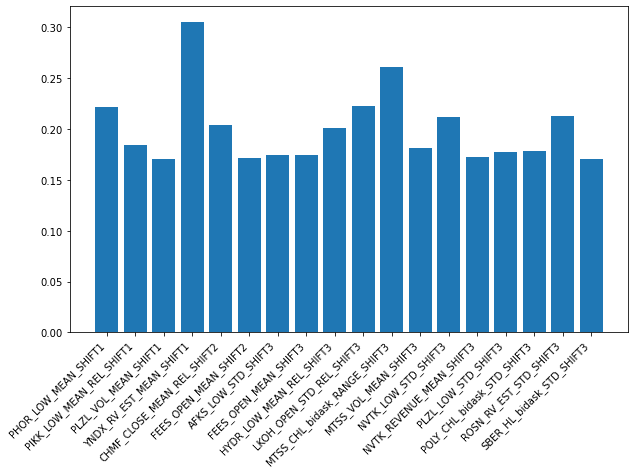

In [126]:
features = X_train.columns
plt.figure(figsize=(10, 6))
plt.bar(X_train.columns[col_indexes], model.feature_importances_[col_indexes])
plt.xticks(X_train.columns[col_indexes], X_train.columns[col_indexes], rotation=45, horizontalalignment='right')
plt.show()

In [93]:
# fit model on train
model = MultiOutputRegressor(xgb.XGBRegressor(booster='gbtree', max_depth=5,
                        learning_rate=0.05, n_estimators=400,
                        colsample_bytree=0.005, colsample_bylevel=0.5,
                        subsample=1, seed=123, gpu_id=0, tree_method='gpu_hist', eval_metric='rmse'))
model.fit(X_train, y_train, verbose=True)

{'rmse': 0.00021360427952852175, 'mape': 7707964411.935061, 'r2': 0.15745439896077437}


In [ ]:
# make predictions on test
y_pred = model.predict(X_val)

# evaluate predictions
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred, multioutput='uniform_average'))
val_mape = mean_absolute_percentage_error(y_val, y_pred, multioutput='uniform_average')
val_r2 = r2_score(y_val, y_pred, multioutput='uniform_average')
val_metrics = {"rmse": val_rmse, "mape": val_mape, "r2": val_r2}
print(val_metrics)

In [107]:
r2_score(y_val, y_pred, multioutput='raw_values')[np.argpartition(r2_score(y_val, y_pred, multioutput='raw_values'), -3)[-3:]]

array([0.24226882, 0.25658555, 0.28590407])

In [108]:
names.TICKER.unique()[np.argpartition(r2_score(y_val, y_pred, multioutput='raw_values'), -3)[-3:]]

array(['FIVE', 'HHRU', 'POGR'], dtype=object)

In [94]:
y_pred = model.predict(X_test)

# evaluate predictions
val_rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='uniform_average'))
val_mape = mean_absolute_percentage_error(y_test, y_pred, multioutput='uniform_average')
val_r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
val_metrics = {"rmse": val_rmse, "mape": val_mape, "r2": val_r2}
print(val_metrics)

{'rmse': 0.0002011897255128058, 'mape': 7668944246.740344, 'r2': 0.0411938503351632}


In [106]:
r2_score(y_test, y_pred, multioutput='raw_values')[np.argpartition(r2_score(y_test, y_pred, multioutput='raw_values'), -3)[-3:]]

array([0.37198931, 0.6312389 , 0.39938372])

In [105]:
names.TICKER.unique()[np.argpartition(r2_score(y_test, y_pred, multioutput='raw_values'), -3)[-3:]]

array(['HHRU', 'OZON', 'FEES'], dtype=object)

In [109]:
xg_coefs = model.estimators_[0].feature_importances_
for i in range(len(model.estimators_)-1):
    xg_coefs = np.vstack([xg_coefs, model.estimators_[i+1].feature_importances_,])
xg_coefs

array([[0.00104847, 0.        , 0.        , ..., 0.        , 0.00011878,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00014594,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.02936668],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [110]:
xgboost_feature_importance = pd.DataFrame(np.argpartition(xg_coefs, -3)[:, -3:], columns=['feature_1', 'feature_2', 'feature_3']).set_index(names.TICKER.unique())

In [111]:
xgboost_feature_importance['feature_1'] = X_train.columns[xgboost_feature_importance.feature_1]
xgboost_feature_importance['feature_2'] = X_train.columns[xgboost_feature_importance.feature_2]
xgboost_feature_importance['feature_3'] = X_train.columns[xgboost_feature_importance.feature_3]
xgboost_feature_importance

,feature_1,feature_2,feature_3
AFKS,POLY_LOW_MEAN_SHIFT1,TRNFP_LOW_RANGE_SHIFT1,SNGSP_CHL_bidask_STD_SHIFT3
AFLT,YNDX_CLOSE_STD_REL_SHIFT3,SBERP_VOL_STD_SHIFT3,SBERP_VOL_RANGE_SHIFT2
ALRS,HYDR_LOW_MEAN_SHIFT1,ROSN_RV_EST_STD_REL_SHIFT2,SBER_REVENUE_RANGE_SHIFT1
CBOM,MTSS_VOL_STD_SHIFT1,NVTK_HL_bidask_RANGE_SHIFT1,FEES_HL_bidask_STD_SHIFT1
CHMF,NVTK_LOW_RANGE_SHIFT2,NLMK_HL_bidask_MEAN_REL_SHIFT3,IRAO_CLOSE_MEAN_REL_SHIFT2
DSKY,POLY_RV_EST_MEAN_SHIFT2,MOEX_REVENUE_RANGE_REL_SHIFT1,MOEX_HIGH_STD_SHIFT1
ENPG,ROSN_HL_bidask_MEAN_REL_SHIFT2,TATN_RV_EST_MEAN_SHIFT3,TRNFP_HL_bidask_STD_SHIFT3
FEES,MTSS_HL_bidask_RANGE_SHIFT1,GAZP_REVENUE_STD_REL_SHIFT1,GMKN_RV_EST_MEAN_REL_SHIFT1
FIVE,FEES_RV_EST_RANGE_SHIFT2,FIVE_RV_EST_STD_SHIFT3,RTKM_HL_bidask_MEAN_REL_SHIFT2
FIXP,HHRU_OPEN_RANGE_SHIFT1,IRAO_CHL_bidask_STD_REL_SHIFT1,TATNP_CLOSE_STD_SHIFT3


In [127]:
xgboost_feature_importance.to_excel('xgboost_features.xlsx')

In [39]:
X_train.columns[np.argmax(xg_coefs, axis=1)]

Index(['SNGSP_CHL_bidask_STD_SHIFT3', 'SBERP_VOL_STD_SHIFT3',
       'SBER_REVENUE_RANGE_SHIFT1', 'FEES_HL_bidask_STD_SHIFT1',
       'IRAO_CLOSE_MEAN_REL_SHIFT2', 'FEES_CHL_bidask_MEAN_REL_SHIFT2',
       'DSKY_VOL_STD_SHIFT1', 'GMKN_RV_EST_MEAN_REL_SHIFT1',
       'RTKM_HL_bidask_MEAN_REL_SHIFT2', 'MOEX_LOW_MEAN_SHIFT1',
       'PLZL_HIGH_STD_SHIFT1', 'GLTR_VOL_RANGE_SHIFT1',
       'TATN_RV_EST_STD_REL_SHIFT2', 'NVTK_CHL_bidask_RANGE_REL_SHIFT3',
       'SNGS_CHL_bidask_STD_SHIFT1', 'AFLT_VOL_MEAN_REL_SHIFT1',
       'TRNFP_OPEN_RANGE_SHIFT2', 'AFLT_REVENUE_MEAN_SHIFT3',
       'PLZL_OPEN_RANGE_SHIFT3', 'MGNT_HL_bidask_STD_SHIFT1',
       'FEES_CLOSE_MEAN_SHIFT2', 'TATN_CHL_bidask_RANGE_SHIFT3',
       'GAZP_HIGH_RANGE_REL_SHIFT3', 'OZON_LOW_STD_SHIFT1',
       'MTSS_HL_bidask_MEAN_SHIFT1', 'YNDX_VOL_STD_SHIFT3',
       'SNGS_HIGH_RANGE_SHIFT2', 'AFLT_HL_bidask_STD_REL_SHIFT1',
       'AFKS_CHL_bidask_STD_SHIFT3', 'GMKN_REVENUE_STD_REL_SHIFT2',
       'MTSS_HIGH_STD_SHIFT3', 'YNDX_R

In [112]:
xg_coefs_avg = np.mean(xg_coefs, axis=0)*100
xg_coefs_avg

array([0.009896  , 0.03483489, 0.0464016 , ..., 0.        , 0.01003509,
       0.1471838 ], dtype=float32)

In [113]:
xg_coefs_avg[xg_coefs_avg>0.15]

array([0.24144492, 0.29563627, 0.1858907 , 2.3255813 , 0.1570508 ,
       0.15925485, 0.16147697, 0.15651084, 0.27302837, 0.21915857,
       0.15706822, 0.17712998, 0.15972984, 0.15139881, 0.20705268,
       0.15948787, 0.15426967, 0.23551421, 0.1542105 , 0.22031036,
       0.20248803, 0.21724406, 0.20096898, 0.16644505, 0.15550363],
      dtype=float32)

In [114]:
col_indexes = [i for i in range(len(xg_coefs_avg)) if xg_coefs_avg[i]>0.15]
X_train.columns[col_indexes]

Index(['FEES_HL_bidask_STD_SHIFT1', 'FEES_OPEN_MEAN_SHIFT1',
       'GAZP_RV_EST_MEAN_SHIFT1', 'GLTR_VOL_RANGE_SHIFT1',
       'HHRU_LOW_RANGE_SHIFT1', 'HYDR_LOW_MEAN_SHIFT1',
       'PIKK_CLOSE_MEAN_SHIFT1', 'SBER_REVENUE_RANGE_SHIFT1',
       'TCSG_HIGH_STD_SHIFT1', 'VTBR_REVENUE_STD_SHIFT1',
       'HYDR_HIGH_MEAN_SHIFT2', 'NVTK_LOW_RANGE_SHIFT2',
       'PIKK_CHL_bidask_STD_SHIFT2', 'POLY_CLOSE_MEAN_REL_SHIFT2',
       'AFLT_HL_bidask_STD_REL_SHIFT3', 'ALRS_OPEN_MEAN_SHIFT3',
       'GMKN_CHL_bidask_MEAN_SHIFT3', 'MTSS_REVENUE_MEAN_SHIFT3',
       'POGR_OPEN_RANGE_SHIFT3', 'POGR_REVENUE_STD_SHIFT3',
       'POGR_VOL_MEAN_SHIFT3', 'TATN_RV_EST_MEAN_SHIFT3',
       'TATNP_CLOSE_STD_SHIFT3', 'VKCO_RV_EST_MEAN_SHIFT3',
       'VKCO_RV_EST_RANGE_SHIFT3'],
      dtype='object')

In [115]:
word_list = []

for w in X_train.columns[col_indexes]:
    for k in w.split('_'):
        word_list.append(k)

pd.Series(word_list).value_counts()

MEAN       12
SHIFT3     11
SHIFT1     10
STD         7
RANGE       6
EST         4
bidask      4
SHIFT2      4
RV          4
REVENUE     4
LOW         3
CLOSE       3
POGR        3
OPEN        3
REL         2
CHL         2
HIGH        2
FEES        2
VKCO        2
HL          2
PIKK        2
HYDR        2
VOL         2
ALRS        1
TATNP       1
TATN        1
GAZP        1
MTSS        1
GMKN        1
AFLT        1
GLTR        1
TCSG        1
POLY        1
HHRU        1
NVTK        1
VTBR        1
SBER        1
dtype: int64

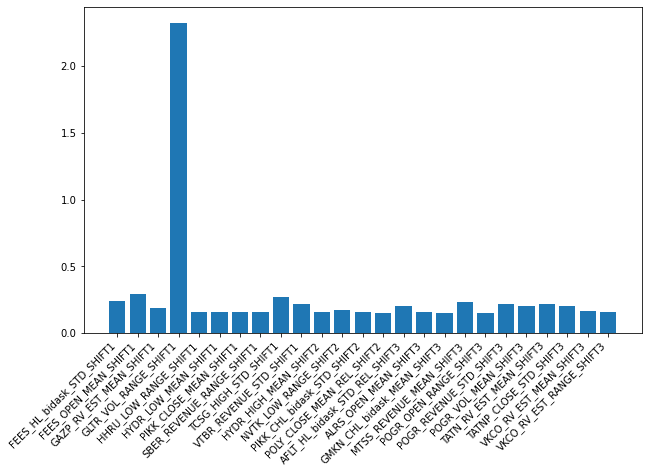

In [116]:
features = X_train.columns
plt.figure(figsize=(10, 6))
plt.bar(X_train.columns[col_indexes], xg_coefs_avg[col_indexes])
plt.xticks(X_train.columns[col_indexes], X_train.columns[col_indexes], rotation=45, horizontalalignment='right')
plt.show()

In [76]:
X_train.loc[:, X_train.columns[(X_train.columns.str.endswith('SHIFT1')) & 
                               (~X_train.columns.str.endswith('REL_SHIFT1')) &
                             (~X_train.columns.str.startswith('year')) &
                            (~X_train.columns.str.startswith('month')) &
                            (~X_train.columns.str.startswith('day'))&
                            (~X_train.columns.str.startswith('weekday'))]] = X_train.loc[:, X_train.columns[(X_train.columns.str.endswith('SHIFT1')) & 
                               (~X_train.columns.str.endswith('REL_SHIFT1')) &
                             (~X_train.columns.str.startswith('year')) &
                            (~X_train.columns.str.startswith('month')) &
                            (~X_train.columns.str.startswith('day'))&
                            (~X_train.columns.str.startswith('weekday'))]].replace(1, 0)

In [77]:
X_val.loc[:, X_val.columns[(X_val.columns.str.endswith('SHIFT1')) & 
                               (~X_val.columns.str.endswith('REL_SHIFT1')) &
                             (~X_val.columns.str.startswith('year')) &
                            (~X_val.columns.str.startswith('month')) &
                            (~X_val.columns.str.startswith('day'))&
                            (~X_val.columns.str.startswith('weekday'))]] = X_val.loc[:, X_val.columns[(X_val.columns.str.endswith('SHIFT1')) & 
                               (~X_val.columns.str.endswith('REL_SHIFT1')) &
                             (~X_val.columns.str.startswith('year')) &
                            (~X_val.columns.str.startswith('month')) &
                            (~X_val.columns.str.startswith('day'))&
                            (~X_val.columns.str.startswith('weekday'))]].replace(1, 0)

In [78]:
X_test.loc[:, X_test.columns[(X_test.columns.str.endswith('SHIFT1')) & 
                              (~X_train.columns.str.endswith('REL_SHIFT1')) &
                             (~X_test.columns.str.startswith('year')) & 
                            (~X_test.columns.str.startswith('month')) &
                            (~X_test.columns.str.startswith('day'))&
                            (~X_test.columns.str.startswith('weekday'))]] = X_test.loc[:, X_test.columns[(X_test.columns.str.endswith('SHIFT1')) & 
                              (~X_train.columns.str.endswith('REL_SHIFT1')) &
                            (~X_test.columns.str.startswith('year')) &
                            (~X_test.columns.str.startswith('month')) &
                            (~X_test.columns.str.startswith('day'))&
                            (~X_test.columns.str.startswith('weekday'))]].replace(1, 0)

In [128]:
model = cb_reg(iterations=400, max_depth=8,
                        learning_rate=0.025, l2_leaf_reg=3, 
                        colsample_bylevel = 0.001, random_state=123,
                        loss_function='MultiRMSE', eval_metric='MultiRMSE')
model.fit(train_pool, plot=True, 
   eval_set=val_pool, verbose=True, metric_period=20, early_stopping_rounds=20)

# make predictions on test
y_pred = model.predict(X_val)

# evaluate predictions
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred, multioutput='uniform_average'))
val_mape = mean_absolute_percentage_error(y_val, y_pred, multioutput='uniform_average')
val_r2 = r2_score(y_val, y_pred, multioutput='uniform_average')
val_metrics = {"rmse": val_rmse, "mape": val_mape, "r2": val_r2}
print(val_metrics)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0017644	test: 0.0014270	best: 0.0014270 (0)	total: 159ms	remaining: 1m 3s
20:	learn: 0.0017136	test: 0.0014192	best: 0.0014192 (20)	total: 3.28s	remaining: 59.2s
40:	learn: 0.0016668	test: 0.0014125	best: 0.0014125 (40)	total: 6.33s	remaining: 55.4s
60:	learn: 0.0016251	test: 0.0014075	best: 0.0014075 (60)	total: 9.33s	remaining: 51.9s
80:	learn: 0.0015895	test: 0.0014040	best: 0.0014040 (80)	total: 12.4s	remaining: 48.8s
100:	learn: 0.0015530	test: 0.0013987	best: 0.0013987 (100)	total: 15.2s	remaining: 44.9s
120:	learn: 0.0015208	test: 0.0013962	best: 0.0013962 (120)	total: 18.2s	remaining: 42s
140:	learn: 0.0014872	test: 0.0013937	best: 0.0013937 (140)	total: 21.3s	remaining: 39.2s
160:	learn: 0.0014553	test: 0.0013916	best: 0.0013916 (160)	total: 24.3s	remaining: 36.1s
180:	learn: 0.0014295	test: 0.0013902	best: 0.0013902 (180)	total: 27.3s	remaining: 33s
200:	learn: 0.0014070	test: 0.0013876	best: 0.0013876 (200)	total: 30.3s	remaining: 30s
220:	learn: 0.0013803	test: 

In [129]:
# make predictions on test
y_pred = model.predict(X_val)

# evaluate predictions
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred, multioutput='uniform_average'))
val_mape = mean_absolute_percentage_error(y_val, y_pred, multioutput='uniform_average')
val_r2 = r2_score(y_val, y_pred, multioutput='uniform_average')
val_metrics = {"rmse": val_rmse, "mape": val_mape, "r2": val_r2}
print(val_metrics)

{'rmse': 0.00021034367338944578, 'mape': 9549885683.068766, 'r2': 0.28103595787862723}


In [130]:
r2_score(y_val, y_pred, multioutput='raw_values')[np.argpartition(r2_score(y_val, y_pred, multioutput='raw_values'), -3)[-3:]]

array([0.47430837, 0.48308195, 0.50683613])

In [131]:
names.TICKER.unique()[np.argpartition(r2_score(y_test, y_pred, multioutput='raw_values'), -3)[-3:]]

array(['VKCO', 'HHRU', 'OZON'], dtype=object)

In [118]:
y_pred = model.predict(X_test)

# evaluate predictions
val_rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='uniform_average'))
val_mape = mean_absolute_percentage_error(y_test, y_pred, multioutput='uniform_average')
val_r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
val_metrics = {"rmse": val_rmse, "mape": val_mape, "r2": val_r2}
print(val_metrics)

{'rmse': 0.00019819732994586655, 'mape': 9247090183.67304, 'r2': 0.214059900050233}


In [119]:
r2_score(y_test, y_pred, multioutput='raw_values')[np.argpartition(r2_score(y_test, y_pred, multioutput='raw_values'), -3)[-3:]]

array([0.41858224, 0.46712526, 0.48305616])

In [120]:
names.TICKER.unique()[np.argpartition(r2_score(y_test, y_pred, multioutput='raw_values'), -3)[-3:]]

array(['GMKN', 'GAZP', 'OZON'], dtype=object)

In [132]:
y_pred = X_test.loc[:, X_test.columns[X_test.columns.str.endswith('_RV_EST_MEAN_SHIFT1')]]

# evaluate predictions
val_rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='uniform_average'))
val_mape = mean_absolute_percentage_error(y_test, y_pred, multioutput='uniform_average')
val_r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
val_metrics = {"rmse": val_rmse, "mape": val_mape, "r2": val_r2}
print(val_metrics)

{'rmse': 0.00027206571772071423, 'mape': 197415421.81631342, 'r2': -5.268284670207552}


In [133]:
r2_score(y_val, y_pred, multioutput='raw_values')[np.argpartition(r2_score(y_val, y_pred, multioutput='raw_values'), -3)[-3:]]

array([0.11169797, 0.17198614, 0.37964629])

In [134]:
names.TICKER.unique()[np.argpartition(r2_score(y_test, y_pred, multioutput='raw_values'), -3)[-3:]]

array(['CBOM', 'GLTR', 'VKCO'], dtype=object)

In [135]:
r2_score(y_test, y_pred, multioutput='raw_values')[np.argpartition(r2_score(y_test, y_pred, multioutput='raw_values'), -3)[-3:]]

array([0.04558205, 0.07299255, 0.41191415])

In [136]:
names.TICKER.unique()[np.argpartition(r2_score(y_test, y_pred, multioutput='raw_values'), -3)[-3:]]

array(['CBOM', 'GLTR', 'VKCO'], dtype=object)

# Эконометрические модели

In [31]:
X_train.loc[:, X_train.columns.str.contains('REVENUE_MEAN_SHIFT1')]

,AFKS_REVENUE_MEAN_SHIFT1,AFLT_REVENUE_MEAN_SHIFT1,ALRS_REVENUE_MEAN_SHIFT1,CBOM_REVENUE_MEAN_SHIFT1,CHMF_REVENUE_MEAN_SHIFT1,DSKY_REVENUE_MEAN_SHIFT1,ENPG_REVENUE_MEAN_SHIFT1,FEES_REVENUE_MEAN_SHIFT1,FIVE_REVENUE_MEAN_SHIFT1,FIXP_REVENUE_MEAN_SHIFT1,...,SBERP_REVENUE_MEAN_SHIFT1,SNGS_REVENUE_MEAN_SHIFT1,SNGSP_REVENUE_MEAN_SHIFT1,TATN_REVENUE_MEAN_SHIFT1,TATNP_REVENUE_MEAN_SHIFT1,TCSG_REVENUE_MEAN_SHIFT1,TRNFP_REVENUE_MEAN_SHIFT1,VKCO_REVENUE_MEAN_SHIFT1,VTBR_REVENUE_MEAN_SHIFT1,YNDX_REVENUE_MEAN_SHIFT1
0,0.000015,-0.001861,1.000000,1.000000,-0.005182,1.000000,1.000000,0.000000,1.000000,1.000000,...,0.000000,-0.002083,-0.000334,0.000213,-0.000473,1.000000,0.000057,1.000000,-0.002140,1.000000
1,0.001781,0.008026,1.000000,1.000000,0.007065,1.000000,1.000000,0.002941,1.000000,1.000000,...,0.000347,0.005307,0.001456,0.000388,0.003148,1.000000,0.004506,1.000000,0.002677,1.000000
2,0.001405,0.003169,1.000000,1.000000,0.010847,1.000000,1.000000,0.001468,1.000000,1.000000,...,0.001378,0.003778,0.003348,0.003597,0.003528,1.000000,0.006423,1.000000,0.007296,1.000000
3,-0.000130,-0.003634,1.000000,1.000000,0.007892,1.000000,1.000000,0.001451,1.000000,1.000000,...,-0.000754,-0.000730,-0.000682,-0.002648,0.000711,1.000000,0.001819,1.000000,-0.001962,1.000000
4,-0.003082,-0.005703,1.000000,1.000000,0.001455,1.000000,1.000000,-0.001166,1.000000,1.000000,...,-0.000742,-0.000971,-0.001598,-0.001684,-0.001764,1.000000,-0.002520,1.000000,-0.001049,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5071,-0.005583,0.003508,-0.001585,-0.004492,0.001378,-0.001476,-0.003310,-0.003706,-0.000057,0.002358,...,-0.001149,-0.000879,-0.000505,-0.002223,-0.000396,-0.000380,-0.000135,0.000461,-0.003063,0.000837
5072,0.004206,-0.000397,-0.001119,-0.000496,-0.000568,0.000556,0.000471,0.001169,-0.001224,0.002632,...,0.001072,0.000725,-0.000439,-0.000515,-0.000033,0.000300,0.000050,0.003724,0.000981,0.005821
5073,-0.000524,-0.000560,0.000788,-0.000889,0.001028,0.001005,-0.000779,0.001712,-0.001601,0.000494,...,-0.002462,-0.000463,-0.000749,0.000157,-0.000931,0.001880,0.000269,0.004634,-0.003385,0.004292
5074,0.001074,0.000072,0.001622,-0.001032,0.001834,-0.000812,-0.002349,-0.002327,-0.000633,-0.001172,...,-0.000222,-0.000577,-0.000617,-0.001241,-0.000578,0.000123,0.002081,0.001981,-0.000023,-0.000793


In [32]:
X_train.AFKS_REVENUE_MEAN_SHIFT1

0       0.000015
1       0.001781
2       0.001405
3      -0.000130
4      -0.003082
          ...   
5071   -0.005583
5072    0.004206
5073   -0.000524
5074    0.001074
5075   -0.000551
Name: AFKS_REVENUE_MEAN_SHIFT1, Length: 5076, dtype: float64

## GARCH

In [53]:
from statsmodels.graphics.tsaplots import plot_acf

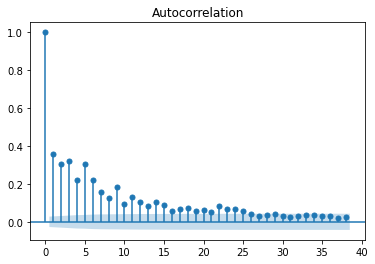

In [57]:
plot_acf(y_train.GAZP_RV_EST_MEAN_TARGET)
plt.show()

In [60]:
from statsmodels.tsa.api import VAR
model = VAR(y_train)
results = model.fit(1)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 29, Apr, 2022
Time:                     03:13:33
--------------------------------------------------------------------
No. of Equations:         43.0000    BIC:                   -769.735
Nobs:                     5075.00    HQIC:                  -771.317
Log likelihood:       1.65162e+06    FPE:                    0.00000
AIC:                     -772.170    Det(Omega_mle):         0.00000
--------------------------------------------------------------------
Results for equation AFKS_RV_EST_MEAN_TARGET
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                               0.000037         0.000009            4.233           0.000
L1.AFKS_RV_EST_MEAN_TARGET          0.086638         0.014431            6.004   

In [34]:
from arch import arch_model, unitroot, covariance

In [47]:
X_train.loc[:, X_train.columns.str.startswith('AFKS')]

Index(['AFKS_CHL_bidask_MEAN_SHIFT1', 'AFKS_CHL_bidask_MEAN_REL_SHIFT1',
       'AFKS_CHL_bidask_RANGE_SHIFT1', 'AFKS_CHL_bidask_RANGE_REL_SHIFT1',
       'AFKS_CHL_bidask_STD_SHIFT1', 'AFKS_CHL_bidask_STD_REL_SHIFT1',
       'AFKS_CLOSE_MEAN_SHIFT1', 'AFKS_CLOSE_MEAN_REL_SHIFT1',
       'AFKS_CLOSE_RANGE_SHIFT1', 'AFKS_CLOSE_RANGE_REL_SHIFT1',
       ...
       'AFKS_RV_EST_RANGE_SHIFT3', 'AFKS_RV_EST_RANGE_REL_SHIFT3',
       'AFKS_RV_EST_STD_SHIFT3', 'AFKS_RV_EST_STD_REL_SHIFT3',
       'AFKS_VOL_MEAN_SHIFT3', 'AFKS_VOL_MEAN_REL_SHIFT3',
       'AFKS_VOL_RANGE_SHIFT3', 'AFKS_VOL_RANGE_REL_SHIFT3',
       'AFKS_VOL_STD_SHIFT3', 'AFKS_VOL_STD_REL_SHIFT3'],
      dtype='object', length=162)

In [74]:
am = arch_model(100*X_train.AFKS_REVENUE_MEAN_SHIFT1, x=[X_train.loc[:, X_train.columns.str.startswith('AFKS')]], p=1, q=1, vol='GARCH')
res = am.fit(update_freq=1)
print(res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 74238.52192749137
Iteration:      2,   Func. Count:     16,   Neg. LLF: 3788087.9396683923
Iteration:      3,   Func. Count:     23,   Neg. LLF: 5883.7912926155805
Iteration:      4,   Func. Count:     31,   Neg. LLF: 11039.271930779596
Iteration:      5,   Func. Count:     37,   Neg. LLF: 3645.5854497725018
Iteration:      6,   Func. Count:     42,   Neg. LLF: 3648.0856582901342
Iteration:      7,   Func. Count:     48,   Neg. LLF: 3645.028838599819
Iteration:      8,   Func. Count:     53,   Neg. LLF: 3645.011094292159
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3645.011081451473
Iteration:     10,   Func. Count:     62,   Neg. LLF: 3645.011075515214
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3645.011081451473
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10
                        Constant Mean - GARCH Model Results       

In [78]:
forecasts = res.forecast(horizon=3, reindex=False)
print(forecasts.variance.dropna().head())

           h.1       h.2       h.3
5075  0.210841  0.216982  0.223123


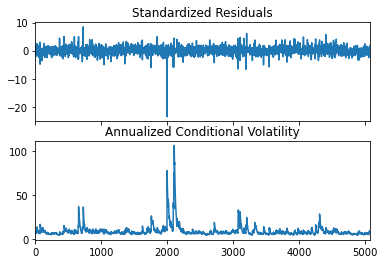

In [52]:
fig = res.plot(annualize="D")

## EGARCH

## QGARCH

# Глубинное обучение

In [80]:
!pip install torch

## CNN

## LSTM